<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/dtp_stat/dpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Вводная часть**

In [ ]:
import pandas as pd
import math as mth
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import folium
import datetime
import pytz
from folium.plugins import MarkerCluster
from sklearn.linear_model import LinearRegression

In [ ]:
#tz = pytz.timezone('Europe/Moscow')
tz = pytz.timezone('Europe/Samara')
start = datetime.datetime.now(tz)
pd.options.display.max_colwidth = 9000

In [ ]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dtp/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/dtp/

/content/drive/My Drive/Colab Notebooks/dtp


# **Получение данных**

In [ ]:
def dtp_json_parser(filename):
#Парсер json данных о ДТП с сайта https://dtp-stat.ru/opendata
#Парсер переводит данные в три датасета - по дтп, по ТС и по людям
#Данные сохраняются в формат cvs для последующего использования
    import warnings
    warnings.filterwarnings("ignore")
    #-------------- Чтение json данных из фала -----------

    if not os.path.isfile(filename):
        print('Нет такого файла - ', filename)
        return

    path, filename_out = os.path.split(filename)
    path = path + '/'
    filename_out = filename_out.split('.')[0]
    with open(filename, 'r', encoding='utf-8') as file:
        jdata = json.load(file)

    # ------------- Объявление датасетов для принятия данных -----------
    data = pd.DataFrame(columns=['dtp_id', 'date_time', 'okrug', 'oblast', 'region', 'address', 'lat', 'lng', 'nearby',
                            'weather', 'road_conditions', 'category', 'severity',
                            'dead_count', 'injured_count', 'participants_count', 'cars_count', 'participant_categories'])
    cars = pd.DataFrame(columns=['car_id', 'dtp_id', 'year', 'brand', 'color', 'model', 'category'])
    partic = pd.DataFrame(columns=['partic_id', 'car_id', 'dtp_id', 'role', 'gender', 'violations',
                            'health_status', 'years_of_driving_experience'])

    #-------------- Разбор json данных -----------------
    d = 1
    c = 1
    p = 1
    print('Начинаю обработку файла', filename)
    print('Обработано тысяч записей ДТП: ', end='')

    for jj in jdata['features']:
        dtp = jj['properties']

        #Добавление ДТП
        data.loc[d] = {'dtp_id': dtp['id'], 'date_time': dtp['datetime'],
                   'okrug':'ПФО', 'oblast': filename_out, 'region': dtp['region'], 'address': dtp['address'],
                   'lat': dtp['point']['lat'], 'lng': dtp['point']['long'], 'nearby' : '; '.join(dtp['nearby']),
                   'weather' : '; '.join(dtp['weather']), 'road_conditions' : '; '.join(dtp['road_conditions']),
                   'category': dtp['category'], 'severity' : dtp['severity'], 'dead_count': dtp['dead_count'],
                   'injured_count': dtp['injured_count'], 'participants_count': dtp['participants_count'],
                   'participant_categories' : '; '.join(dtp['participant_categories'])}

        #Добавление траснпортного средства
        cars_in_dtp = 0
        for cc in dtp['vehicles']:
            cars.loc[c] = {'car_id' : c, 'dtp_id' : dtp['id'], 'year' : cc['year'], 'brand' : cc['brand'],
                           'color' : cc['color'], 'model' : cc['model'], 'category' : cc['category']}
            #Добавление людей из ТС
            for pp in cc['participants']:
                partic.loc[p] = {'partic_id' : p, 'car_id' : c, 'dtp_id' : dtp['id'], 'role' : pp['role'],
                                 'gender' : pp['gender'], 'violations' : '; '.join(pp['violations']),
                                 'health_status' : pp['health_status'],
                                 'years_of_driving_experience' : pp['years_of_driving_experience']}
                p +=1 #счетчик людей
            c +=1 #счетчик ТС
            cars_in_dtp +=1

        data.loc[d,'cars_count'] = cars_in_dtp

        #Добавление людей без ТС
        for pp in dtp['participants']:
            partic.loc[p] = {'partic_id' : p, 'car_id' : 0, 'dtp_id' : dtp['id'], 'role' : pp['role'],
                             'gender' : pp['gender'], 'violations' : '; '.join(pp['violations']),
                                 'health_status' : pp['health_status'], 'years_of_driving_experience' : None}
            p +=1 #счетчик людей

        d +=1 #счетчик ДТП
        if d % 1000 == 0: print('..', d//1000, end='')

        #if d > 100: break #брейк для отладки =)
    #------------ конец разбора json ----------------

    data['cars_count'] = data['cars_count'].astype('int')
    print('..все!')
    print('Полчуено записей о ДТП -', len(data))
    print('Получено записей о ТС, участвоваващих в ДТП -', len(cars))
    print('Получено записей о людях, участвовавщих в ДТП -', len(partic))

    # ----------- Запись данных в CVS ----------------

    if len(data) < 111: filename_out = 'test-' + filename_out
    data.to_csv(path + filename_out + '-data.csv', index=False)
    partic.to_csv(path + filename_out + '-partic.csv', index=False)
    cars.to_csv(path + filename_out + '-cars.csv', index=False)
    print('Даныне сохранены по адрeсу ', path + filename_out + '-xxxx.csv')

In [ ]:
%%time
json_path = 'datasets/'
#dtp_json_parser(json_path + 'samarskaia-oblast.geojson')
#dtp_json_parser(json_path + 'ulianovskaia-oblast.geojson')
#dtp_json_parser(json_path + 'saratovskaia-oblast.geojson')
#dtp_json_parser(json_path + 'penzenskaia-oblast.geojson')
#dtp_json_parser(json_path + 'orenburgskaia-oblast.geojson')
#dtp_json_parser(json_path + 'chuvashskaia-respublika-chuvashiia.geojson')
#dtp_json_parser(json_path + 'kirovskaia-oblast.geojson')
#dtp_json_parser(json_path + 'nizhegorodskaia-oblast.geojson')
#dtp_json_parser(json_path + 'permskii-krai.geojson')
#dtp_json_parser(json_path + 'respublika-bashkortostan.geojson')
#dtp_json_parser(json_path + 'respublika-marii-el.geojson')
#dtp_json_parser(json_path + 'respublika-mordoviia.geojson')
#dtp_json_parser(json_path + 'respublika-tatarstan-tatarstan.geojson')
#---------- не распарсил еще --------------

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [ ]:
data = pd.DataFrame(columns=[])
cars = pd.DataFrame(columns=[])
partic = pd.DataFrame(columns=[])

csv_path = 'datasets/'

#regions = ('test-samarskaia-oblast', )

regions = ('samarskaia-oblast',
           'saratovskaia-oblast',
           'ulianovskaia-oblast' ,
           'penzenskaia-oblast',
           'orenburgskaia-oblast',
           'chuvashskaia-respublika-chuvashiia',
           'respublika-bashkortostan',
           'respublika-marii-el',
           'respublika-mordoviia',
           'respublika-tatarstan-tatarstan',
           'kirovskaia-oblast',
           'nizhegorodskaia-oblast',
           'permskii-krai',
           )
for i in range(0, len(regions)):
    filename = csv_path + regions[i] + '-data.csv'
    if not os.path.isfile(filename):
        print('нет файла ', filename)
        continue
    new_base = pd.read_csv(filename)
    #правим ключвые поля для сохранения уникальности при слияния баз из разных областей
    new_base['dtp_id'] = new_base['dtp_id'].astype('string')
    new_base['dtp_id'] = str(i+1) + '_' + new_base['dtp_id']

    data = pd.concat([data, new_base])


    filename = csv_path + regions[i] + '-cars.csv'
    if not os.path.isfile(filename):
        print('нет файла ', filename)
        continue
    new_base = pd.read_csv(filename)

    #правим ключвые поля для сохранения уникальности при слияния баз из разных областей
    new_base['dtp_id'] = new_base['dtp_id'].astype('string')
    new_base['dtp_id'] = str(i+1) + '_' + new_base['dtp_id']
    new_base['car_id'] = new_base['car_id'].astype('string')
    new_base['car_id'] = str(i+1) + '_' + new_base['car_id']

    cars = pd.concat([cars, new_base])


    filename = csv_path + regions[i] + '-partic.csv'
    if not os.path.isfile(filename):
        print('нет файла ', filename)
        continue
    new_base = pd.read_csv(filename)

    #правим ключвые поля для сохранения уникальности при слияния баз из разных областей
    new_base['dtp_id'] = new_base['dtp_id'].astype('string')
    new_base['dtp_id'] = str(i+1) + '_' + new_base['dtp_id']
    new_base['car_id'] = new_base['car_id'].astype('string')
    new_base['car_id'] = str(i+1) + '_' + new_base['car_id']
    new_base['partic_id'] = new_base['partic_id'].astype('string')
    new_base['partic_id'] = str(i+1)  + '_' + new_base['partic_id']

    partic = pd.concat([partic, new_base])


In [ ]:
data.name = 'ДТП'
cars.name = 'Мaшины'
partic.name = 'Люди'

# **Подготовка данных**

## *Общие данные по ДТП*

In [ ]:
data.head()

dtp_id            date_time okrug             oblast           region  \
0  1_2264955  2016-05-21 20:00:00   ПФО  samarskaia-oblast  Шигонский район   
1  1_2265512  2017-04-21 12:30:00   ПФО  samarskaia-oblast  Шигонский район   
2  1_2600364  2021-07-25 02:20:00   ПФО  samarskaia-oblast  Шигонский район   
3  1_2597350  2021-07-09 18:20:00   ПФО  samarskaia-oblast  Шигонский район   
4  1_2591104  2021-07-02 17:30:00   ПФО  samarskaia-oblast  Шигонский район   

                                   address        lat        lng nearby  \
0  Сызрань - Шигоны - Волжский Утес, 20 км  53.372615  48.641316    NaN   
1  Сызрань - Шигоны - Волжский Утес, 37 км  53.354715  48.857092    NaN   
2  Сызрань - Шигоны - Волжский Утес, 37 км  53.345347  48.835815    NaN   
3  Сызрань - Шигоны - Волжский Утес, 16 км  53.344672  48.636078    АЗС   
4  Сызрань - Шигоны - Волжский Утес, 15 км  53.328105  48.637247    NaN   

  weather road_conditions              category severity  dead_count  \
0    Ясно           Сухое     Наезд на пешехода  Тяжёлый           0   
1    Ясно           Сухое  Наезд на препятствие  Тяжёлый           0   
2    Ясно           Сухое        Съезд с дороги   Легкий           0   
3    Ясно           Сухое          Столкновение   Легкий           0   
4    Ясно          Мокрое          Столкновение   Легкий           0   

   injured_count  participants_count  cars_count   participant_categories  
0              2                   3           1  Все участники; Пешеходы  
1              2                   2           1            Все участники  
2              1                   1           1            Все участники  
3              1                   3           2            Все участники  
4              1                   2           2            Все участники

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311373 entries, 0 to 27889
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dtp_id                  311373 non-null  string 
 1   date_time               311373 non-null  object 
 2   okrug                   311373 non-null  object 
 3   oblast                  311373 non-null  object 
 4   region                  311373 non-null  object 
 5   address                 297420 non-null  object 
 6   lat                     309686 non-null  float64
 7   lng                     309686 non-null  float64
 8   nearby                  233646 non-null  object 
 9   weather                 311373 non-null  object 
 10  road_conditions         311373 non-null  object 
 11  category                311373 non-null  object 
 12  severity                311373 non-null  object 
 13  dead_count              311373 non-null  int64  
 14  injured_count           31

Доля пропусков по колонкам

In [ ]:
data.isna().sum() / len(data)

dtp_id                    0.000000
date_time                 0.000000
okrug                     0.000000
oblast                    0.000000
region                    0.000000
address                   0.044811
lat                       0.005418
lng                       0.005418
nearby                    0.249627
weather                   0.000000
road_conditions           0.000000
category                  0.000000
severity                  0.000000
dead_count                0.000000
injured_count             0.000000
participants_count        0.000000
cars_count                0.000000
participant_categories    0.000000
dtype: float64

Дубликаты

In [ ]:
print(f"Полных дубликатов {data.duplicated().sum()}, дубликатов в dtp_id {data['dtp_id'].duplicated().sum()}")

Полных дубликатов 0, дубликатов в dtp_id 0


Записи в которых нет ни погибших ни пострадавших. По идее, не должно быть таких... но встечается.

In [ ]:
data[(data['dead_count'] + data['injured_count'] == 0)]

dtp_id            date_time okrug                    oblast  \
6168  7_2477936  2020-09-26 13:55:00   ПФО  respublika-bashkortostan   

             region                                            address  \
6168  Краснокамский  Нефтекамск-Янаул(Кувакино,Султыево,Айбуляк), 6 км   

            lat        lng nearby weather road_conditions        category  \
6168  56.148896  54.397645    NaN    Ясно           Сухое  Съезд с дороги   

     severity  dead_count  injured_count  participants_count  cars_count  \
6168   Легкий           0              0                   4           0   

     participant_categories  
6168          Все участники

In [ ]:
dtp_0pactik = data[(data['dead_count'] == 0) & (data['injured_count'] == 0)]['dtp_id'].unique()
partic[partic['dtp_id'].isin(dtp_0pactik)]

Empty DataFrame
Columns: [partic_id, car_id, dtp_id, role, gender, violations, health_status, years_of_driving_experience]
Index: []

In [ ]:
cars[cars['dtp_id'].isin(dtp_0pactik)]

Empty DataFrame
Columns: [car_id, dtp_id, year, brand, color, model, category]
Index: []

Создание новых колонок для дальнейшего анализа

In [ ]:
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data['date'] = data['date_time'].dt.date
data['year'] = data['date_time'].dt.year
data['month'] = data['date_time'].dt.month
data['day'] = data['date_time'].dt.day
data['weekday'] = data['date_time'].dt.weekday
data['hour'] = data['date_time'].dt.hour
data['severity_id'] = data['severity'].replace({'Легкий': 1, 'Тяжёлый': 2, 'С погибшими': 3})

<ipython-input-15-867b46e97733>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['severity_id'] = data['severity'].replace({'Легкий': 1, 'Тяжёлый': 2, 'С погибшими': 3})


Замена пропусков на 'заглушки'

In [ ]:
data['address'] = data['address'].fillna('Не заполнено')
data['nearby'] = data['nearby'].fillna('Не заполнено')
data['lat'] = data['lat'].fillna(56) #целое число гдето в середине ПФО - потом легче отфильтровать
data['lng'] = data['lng'].fillna(44)

Приведение к одному виду похожых категориальных значений

In [ ]:
#замена отдельных фраз внутри ячейки
data['nearby'] = data['nearby'].replace({'ё': 'е',
        'иного детского учреждения': 'иной детской организации',
        'Иное образовательное учреждение' : 'Иная образовательная организация',
        'Лечебные учреждения' : 'Медицинские (лечебные) организации',
        'Мост, эстакада, путепровод' : 'Мост',
        'Эстакада, путепровод' : 'Мост',
        'иное детское \(в т.ч. дошкольное\) учреждение': 'иная детская (в т.ч. дошкольная) организация'
                    }
        , regex=True)

#замена всей ячейки
data.loc[data['nearby'].str.contains('Мост'), 'nearby'] =  'Мост, эстакада, путепровод'
data.loc[data['nearby'].str.contains('торговый объект'), 'nearby'] = 'Крупный торговый объект'
data.loc[data['nearby'].str.contains('Остановка'), 'nearby'] = 'Остановка'

data.loc[data['category'].str.contains('Наезд на лицо'), 'category'] = 'Наезд на сотрудника служб'
data.loc[data['category'].str.contains('Возгорание'), 'category'] = 'Возгорание'

In [ ]:
#замена названий областей
data['oblast'] = data['oblast'].replace({
           'samarskaia-oblast' : 'Самарская обл.',
           'saratovskaia-oblast' : 'Саратовская обл.',
           'ulianovskaia-oblast' : 'Ульяновская обл.' ,
           'penzenskaia-oblast' : 'Пензенская обл.',
           'orenburgskaia-oblast' : 'Оренбургская обл.',
           'chuvashskaia-respublika-chuvashiia' : 'Чуващия',
           'respublika-bashkortostan' : 'Башкирия',
           'respublika-marii-el' : 'Марий-Эл',
           'respublika-mordoviia' : 'Мордовия',
           'respublika-tatarstan-tatarstan' : 'Татарстан',
           'kirovskaia-oblast' : 'Кировская обл.',
           'nizhegorodskaia-oblast' : 'Нижегородская обл.',
           'permskii-krai' : 'Пермский край'
            })

In [ ]:
#sorted(set('; '.join(data['nearby'].unique()).split('; ')))

## *Данные по транспортным средствам*

In [ ]:
cars.head()

car_id     dtp_id    year   brand       color  \
0    1_1  1_2264955  2008.0  JAGUAR      Черный   
1    1_2  1_2265512  2004.0     ВАЗ  Фиолетовый   
2    1_3  1_2600364  2004.0     ВАЗ     Зеленый   
3    1_4  1_2597350  2012.0     ВАЗ       Белый   
4    1_5  1_2597350  2018.0     ВАЗ      Черный   

                           model                                      category  
0           Прочие модели Jaguar                      В-класс (малый) до 3,9 м  
1   Жигули  ВАЗ-2105 модификации  С-класс (малый средний, компактный) до 4,3 м  
2    Ока  ВАЗ-1111 и модификации                А-класс (особо малый) до 3,5 м  
3                         Kalina                      В-класс (малый) до 3,9 м  
4                         Kalina                      В-класс (малый) до 3,9 м

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487608 entries, 0 to 41429
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   car_id    487608 non-null  string 
 1   dtp_id    487608 non-null  string 
 2   year      467462 non-null  float64
 3   brand     469599 non-null  object 
 4   color     475308 non-null  object 
 5   model     469597 non-null  object 
 6   category  487608 non-null  object 
dtypes: float64(1), object(4), string(2)
memory usage: 29.8+ MB


Доля пропусков по колонкам

In [ ]:
cars.isna().sum() / len(cars)

car_id      0.000000
dtp_id      0.000000
year        0.041316
brand       0.036933
color       0.025225
model       0.036937
category    0.000000
dtype: float64

Дубликаты

In [ ]:
print(f"Полных дубликатов {cars.duplicated().sum()}, дубликатов в car_id {cars['car_id'].duplicated().sum()}")

Полных дубликатов 0, дубликатов в car_id 0


Замена пропусков на 'заглушки'

In [ ]:
cars['year'] = cars['year'].fillna(0)
cars['brand'] = cars['brand'].fillna('Прочие марки ТС')
cars['color'] = cars['color'].fillna('Не заполнено')
cars['model'] = cars['model'].fillna('Прочие марки ТС')

Приведение к одному виду похожых категориальных значений

In [ ]:
#замена отдельных фраз внутри ячейки
cars['category'] = cars['category'].replace({'  ': ' ',
        '^A-класс': 'Легковые автомобили A-класс',
        '^B-класс': 'Легковые автомобили B-класс',
        '^C-класс': 'Легковые автомобили C-класс',
        '^D-класс': 'Легковые автомобили D-класс',
        '^E-класс': 'Легковые автомобили E-класс',
        '^S-класс': 'Легковые автомобили S-класс',
        #А, В, С, Е - русскими
        '^А-класс': 'Легковые автомобили A-класс',
        '^В-класс': 'Легковые автомобили B-класс',
        '^С-класс': 'Легковые автомобили C-класс',
        '^Е-класс': 'Легковые автомобили E-класс',
        '^Одноэтажные': 'Автобусы Одноэтажные',
                   }
        , regex=True)


Сокращаем количество моделей

In [ ]:
cars['model'].nunique()

2129

In [ ]:
#удаление лишних пробелов
cars['model'] = cars['model'].str.strip()
cars['model'] = cars['model'].replace({'\s+': ' '}, regex=True)

#замена отдельных фраз внутри ячейки
cars['model'] = cars['model'].replace({
         ' и модификации': '',
         'Жигули ВАЗ-' : 'ВАЗ ',
         'Нива ' : 'ВАЗ ',
         'Ока ВАЗ-' : 'ВАЗ ',
                   }
        , regex=True)

#замена всей ячейки
cars.loc[cars['model'].str.contains('Патриот'), 'model'] =  'Patriot'
cars.loc[cars['model'].str.contains('Гранта'), 'model'] =  'Granta'
cars.loc[cars['model'].str.contains('Веста'), 'model'] =  'Vesta'
cars.loc[cars['model'].str.contains('Ларгус'), 'model'] =  'Largus'
cars.loc[cars['model'].str.contains('Прочие модели', case=False), 'model'] =  'Прочие модели'
cars.loc[cars['model'].str.contains('Прочи модели', case=False), 'model'] =  'Прочие модели'
cars.loc[cars['model'].str.contains('Прочие марки', case=False), 'model'] =  'Прочие модели'

In [ ]:
cars['model'].nunique()

1729

Редкие модели (машин, которых в базе меньше 10) переводим в "Прочие модели"

In [ ]:
%%time
bradcars = cars.groupby(['brand', 'model'], as_index = False)['car_id'].count()
bradcars_less10 = bradcars.query('car_id < 10')
bradcars_less10 = bradcars_less10.reset_index()
for i in range(0, len(bradcars_less10)):
  b = bradcars_less10.loc[i, 'brand']
  m = bradcars_less10.loc[i, 'model']
  cars.loc[(cars['brand'] == b) & (cars['model'] == m), 'model'] = 'Прочие модели'
  #if i > 100: break

CPU times: user 1min 52s, sys: 359 ms, total: 1min 52s
Wall time: 1min 55s


In [ ]:
cars.query('model == "Прочие модели"')['car_id'].count() / len(cars)

0.23618357369034143

In [ ]:
cars['model'].nunique()

793

In [ ]:
#sorted(set(cars['model'].unique()))

## *Данные по людям*

In [ ]:
partic.head()

partic_id car_id     dtp_id      role   gender  \
0       1_1    1_1  1_2264955  Водитель  Мужской   
1       1_2    1_0  1_2264955   Пешеход  Мужской   
2       1_3    1_0  1_2264955   Пешеход  Мужской   
3       1_4    1_2  1_2265512  Водитель  Мужской   
4       1_5    1_2  1_2265512  Пассажир  Женский   

                                                                                 violations  \
0  Несоблюдение условий, разрешающих движение транспорта задним ходом; Оставление места ДТП   
1                                                                                       NaN   
2                                                                                       NaN   
3                                                            Другие нарушения ПДД водителем   
4                                                                                       NaN   

                                                                                                                                                                                                health_status  \
0                                                                                                                                                                                                Не пострадал   
1                                                                                                                                                 Раненый, находящийся (находившийся) на стационарном лечении   
2  Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)   
3                                                                                                                                                 Раненый, находящийся (находившийся) на стационарном лечении   
4                                                                                                                                                 Раненый, находящийся (находившийся) на стационарном лечении   

   years_of_driving_experience  
0                         12.0  
1                          NaN  
2                          NaN  
3                         17.0  
4                          NaN

In [ ]:
partic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765301 entries, 0 to 66835
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   partic_id                    765301 non-null  string 
 1   car_id                       765301 non-null  string 
 2   dtp_id                       765301 non-null  string 
 3   role                         765301 non-null  object 
 4   gender                       742621 non-null  object 
 5   violations                   369836 non-null  object 
 6   health_status                764093 non-null  object 
 7   years_of_driving_experience  425207 non-null  float64
dtypes: float64(1), object(4), string(3)
memory usage: 52.5+ MB


Доля пропусков по колонкам

In [ ]:
partic.isna().sum() / len(partic)

partic_id                      0.000000
car_id                         0.000000
dtp_id                         0.000000
role                           0.000000
gender                         0.029635
violations                     0.516744
health_status                  0.001578
years_of_driving_experience    0.444392
dtype: float64

Дубликаты

In [ ]:
print(f"Полных дубликатов {partic.duplicated().sum()}, дубликатов в partic_id {partic['partic_id'].duplicated().sum()}")

Полных дубликатов 0, дубликатов в partic_id 0


Замена пропусков на 'заглушки'

In [ ]:
partic['gender'] = partic['gender'].fillna('Не заполнено')
partic['violations'] = partic['violations'].fillna('Не заполнено')
partic['health_status'] = partic['health_status'].fillna('Не заполнено')
partic['years_of_driving_experience'] = partic['years_of_driving_experience'].fillna(0)
partic['years_of_driving_experience'] = partic['years_of_driving_experience'].astype('int')

Приведение к одному виду похожых категориальных значений

In [ ]:
#удаление лишних пробелов
partic['health_status'] = partic['health_status'].str.strip()
partic['health_status'] = partic['health_status'].replace({'\s+': ' '}, regex=True)

#замена отдельных фраз внутри ячейки
partic['health_status'] = partic['health_status'].replace({
         'медицинское учреждение': 'мед. организацию',
         'телесные повреждения' : 'травмы',
                   }
        , regex=True)

In [ ]:
#sorted(set('; '.join(partic['health_status'].unique()).split('; ')))

In [ ]:
#удаление лишних пробелов
partic['violations'] = partic['violations'].str.strip()
partic['violations'] = partic['violations'].replace({'\s+': ' '}, regex=True)

#замена отдельных фраз внутри ячейки
partic['violations'] = partic['violations'].replace({
        '\xa0': ' ',
        'ё' : 'е',
        ' \(не применяется с 12.2020\)' : '',
        'Движение вдоль проезжей части' : 'Ходьба вдоль проезжей части',
                   }
        , regex=True)

#замена всей ячейки
partic.loc[partic['violations'].str.contains('Другие нарушения ПДД водителем', case=False), 'violations'] =  'Иные нарушения'
partic.loc[partic['role'].str.contains('Пешеход, перед ДТП', case=False), 'role'] =  'Пешеход'

In [ ]:
#sorted(set('; '.join(partic['violations'].unique()).split('; ')))

Итоговый результат ДТП приводим к 4 исходам

In [ ]:
partic['result'] = partic['health_status']
partic.loc[partic['result'].str.contains('Не пострадал'), 'result'] = 'Не пострадал'
partic.loc[partic['result'].str.contains('Раненый'), 'result'] = 'Пострадал'
partic.loc[partic['result'].str.contains('телесные повреждения'), 'result'] = 'Пострадал'
partic.loc[partic['result'].str.contains('травмы'), 'result'] = 'Пострадал'
partic.loc[partic['result'].str.contains('Скончался'), 'result'] = 'Погиб'

## *Проверка целостности связей датасетов*

Распределение ДТП по количеству участвовавших в них ТС. Нет в исходных данных!

In [ ]:
%%time
# -------- Первая долгая ячейка =)
# расчет количества ТС в каждом из ДТП
# Перенес этот подсчет в парсер, но оставлю тут, для старых датасетов

#data['cars_count'] = 0
#cc = cars.groupby('dtp_id', as_index=False)['car_id'].count()
#i = 0
#for dd in set(cc['dtp_id']):
#    data.loc[data['dtp_id'] == dd, 'cars_count'] = cc.loc[cc['dtp_id'] == dd, 'car_id'].values[0]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


Перекресные проверки на вхождение дтп без ТС и участников, ТС без дтп, ТС без участников, участников без дтп, участников без ТС

In [ ]:
for i in [data, cars, partic]:
    for k in  [data, cars, partic]:
        if i.name == k.name : continue
        print(i[~i['dtp_id'].isin(k['dtp_id'])]['dtp_id'].count(), 'значений dtp_id из таблицы', i.name, 'нет в таблице', k.name)

2816 значений dtp_id из таблицы ДТП нет в таблице Мaшины
437 значений dtp_id из таблицы ДТП нет в таблице Люди
0 значений dtp_id из таблицы Мaшины нет в таблице ДТП
0 значений dtp_id из таблицы Мaшины нет в таблице Люди
0 значений dtp_id из таблицы Люди нет в таблице ДТП
2519 значений dtp_id из таблицы Люди нет в таблице Мaшины


ТС, у которых указано ДТП, в которых нет ТС. Не должно быть таких!

In [ ]:
cars[cars['dtp_id'].isin(set(data[data['cars_count'] == 0]['dtp_id']))]

Empty DataFrame
Columns: [car_id, dtp_id, year, brand, color, model, category]
Index: []

Есть ДТП без ТС. Это могут быть наезды на пешеходов со скрывшимися водителями

In [ ]:
partic_0cars = partic[partic['dtp_id'].isin(set(data[data['cars_count'] == 0]['dtp_id']))]

Водители, попавшие в ДТП, для которых нет ТС в базе

In [ ]:
partic_0cars[partic_0cars['role'] == "Водитель"]

partic_id car_id      dtp_id      role        gender  \
10940   1_10941    1_0   1_2608940  Водитель  Не заполнено   
19302   1_19303    1_0   1_2603716  Водитель  Не заполнено   
19303   1_19304    1_0   1_2603716  Водитель  Не заполнено   
11089   2_11090    2_0   2_2567945  Водитель  Не заполнено   
15820   2_15821    2_0   2_2587021  Водитель  Не заполнено   
...         ...    ...         ...       ...           ...   
47948  13_47949   13_0  13_2609077  Водитель  Не заполнено   
50966  13_50967   13_0  13_2615601  Водитель  Не заполнено   
50967  13_50968   13_0  13_2615601  Водитель  Не заполнено   
52904  13_52905   13_0  13_2606917  Водитель  Не заполнено   
52906  13_52907   13_0  13_2610429  Водитель  Не заполнено   

                                                                                                                                                            violations  \
10940  Нарушение правил расположения ТС на проезжей части; Нарушение водителем правил применения ремней безопасности (ставится в случае, когда не пристегнут водитель)   
19302                                                                                                  Выезд на полосу встречного движения в местах, где это запрещено   
19303                                                                                                                                                     Не заполнено   
11089                                                                                Нарушение правил расположения ТС на проезжей части; Несоблюдение требований ОСАГО   
15820                                                                                                                                                     Не заполнено   
...                                                                                                                                                                ...   
47948                                                                                       Несоответствие скорости конкретным условиям движения; Оставление места ДТП   
50966                                                                                                                                    Нарушение правил перестроения   
50967                                                                                                                                                     Не заполнено   
52904                                                                                                                                                     Не заполнено   
52906                                                                                       Несоответствие скорости конкретным условиям движения; Оставление места ДТП   

                                                                                             health_status  \
10940                                          Скончался на месте ДТП до приезда скорой медицинской помощи   
19302                                                                                         Не пострадал   
19303  Получил травмы с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)   
11089                                                                          Скончался в течение 1 суток   
15820                                                                                         Не пострадал   
...                                                                                                    ...   
47948                                                                                         Не пострадал   
50966  Получил травмы с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)   
50967                                                                                         Не пострадал   
52904                                                                                         Не пострадал   
52906     

Три случайных ДТП в в которых для водителей нет ТС в базе

In [ ]:
rnd_partic_0cars_dtpid = partic_0cars[partic_0cars['role'] == "Водитель"].sample(n=3)['dtp_id']

In [ ]:
data[data['dtp_id'].isin(rnd_partic_0cars_dtpid)]

dtp_id           date_time okrug            oblast  \
11978   2_2585311 2021-06-20 13:25:00   ПФО  Саратовская обл.   
3389   10_2582462 2021-06-08 06:50:00   ПФО         Татарстан   
22664  10_2613125 2021-08-23 18:56:00   ПФО         Татарстан   

                 region                         address        lat        lng  \
11978  Энгельский район     г Энгельс, ул Ломоносова, 2  51.469375  46.136345   
3389     Заинский район     с Федоровка, ул Клубная, 40  55.209879  52.265353   
22664            Казань  г Казань, ул Чистопольская, 75  55.819431  49.149281   

                                    nearby weather  ... participants_count  \
11978                            Остановка    Ясно  ...                  2   
3389   Жилые дома индивидуальной застройки    Ясно  ...                  1   
22664              Крупный торговый объект    Ясно  ...                  3   

      cars_count participant_categories        date  year  month  day weekday  \
11978          0          Все участники  2021-06-20  2021      6   20       6   
3389           0          Все участники  2021-06-08  2021      6    8       1   
22664          0          Все участники  2021-08-23  2021      8   23       0   

      hour  severity_id  
11978   13            1  
3389     6            2  
22664   18            1  

[3 rows x 25 columns]

In [ ]:
cars[cars['dtp_id'].isin(rnd_partic_0cars_dtpid)]

Empty DataFrame
Columns: [car_id, dtp_id, year, brand, color, model, category]
Index: []

In [ ]:
partic[partic['dtp_id'].isin(rnd_partic_0cars_dtpid)]

partic_id car_id      dtp_id      role        gender  \
29398   2_29399    2_0   2_2585311  Пассажир  Не заполнено   
29399   2_29400    2_0   2_2585311  Водитель  Не заполнено   
8210    10_8211   10_0  10_2582462  Водитель  Не заполнено   
56011  10_56012   10_0  10_2613125  Водитель  Не заполнено   
56012  10_56013   10_0  10_2613125  Водитель  Не заполнено   
56013  10_56014   10_0  10_2613125  Пассажир  Не заполнено   

                                                                                                                                                                                                violations  \
29398                                                                                                                                                Нарушение правил пользования общественным транспортом   
29399                                                                                                                                                                                         Не заполнено   
8210   Нарушение правил расположения ТС на проезжей части; Управление ТС в состоянии алкогольного опьянения; Управление ТС лицом, не имеющим права на управление ТС; Нарушение правил применения мотошлема   
56011                                                                                                                                                                                         Не заполнено   
56012                                                                                                                                          Неправильный выбор дистанции; Несоблюдение требований ОСАГО   
56013                                                                                                                                                                                         Не заполнено   

                                                                                             health_status  \
29398     Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара   
29399                                                                                         Не пострадал   
8210                                           Раненый, находящийся (находившийся) на стационарном лечении   
56011                                                                                         Не пострадал   
56012                                                                                         Не пострадал   
56013  Получил травмы с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)   

       years_of_driving_experience        result  
29398                            0     Пострадал  
29399                            0  Не пострадал  
8210                             0     Пострадал  
56011                            0  Не пострадал  
56012                            0  Не пострадал  
56013                            0     Пострадал

Водители, пострадавшие в ДТП, для которых нет ТС в базе также не заполнен пол... Видимо, это ошибки при вводе в базу. К счастью, их мало =)

Обратная проверка - ТС с номером ДТП, для которых в датасете пострадавших есть водители без ТС. Не должно быть таких

In [ ]:
cars[cars['dtp_id'].isin(partic_0cars[partic_0cars['role'] == "Водитель"]['dtp_id'])]

Empty DataFrame
Columns: [car_id, dtp_id, year, brand, color, model, category]
Index: []

# **Процедуры и функции**

Процедуры и функции, которые будут использоваться в дальнейшем анализе

In [ ]:
# Z-критерий проверки равенства пропорций
# Из курса Яндекс.Практиум
# С доработкой односторонних гипотез
def z_krit(a1, a2, n1, n2, alt = 'two'):
    #alt - ‘two’, ‘smaller’, ‘larger’
    p1 = a1 / n1
    p2 = a2 / n2
    p_combined = (a1 + a2) / (n1 + n2)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    distr = stats.norm(0,1)
#    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if alt == 'two':   p_value = (1 - distr.cdf(abs(z_value))) * 2
    if alt == 'larger':   p_value = (1 - distr.cdf(z_value)) * 2
    if alt == 'smaller':   p_value = (1 - distr.cdf(-z_value)) * 2

    if p_value > 1: p_value = 1

    return p_value

In [ ]:
#процедура расчета z-критерия для всей переданной в процедуру таблицы
def zkrit_to_all (dd):
    for i in range(0, len(dd)):
        dd.loc[i, 'zkrit_dead'] = z_krit(dd.loc[i, 'dead_count'], all_dead_count,
            dd.loc[i, 'participants_count'],  all_participants_count, 'larger')
        dd.loc[i, 'zkrit_injured'] = z_krit(dd.loc[i, 'injured_count'], all_injured_count,
            dd.loc[i, 'participants_count'],  all_participants_count, 'larger')

In [ ]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_stat(s, color='orange'):
    return ['background-color: '+color if val < 0.05 else 'background-color: none' for val in s]

In [ ]:
#вывод красивой таблицы факторов повышенной смертности
def factor_dead_table(dd):
  if 'type' in dd:
    dd.loc[dd['type'] == 'road_conditions', 'type'] = 'Сосояние дороги'
    dd.loc[dd['type'] == 'nearby', 'type'] = 'Соседство с'
    dd.loc[dd['type'] == 'weather', 'type'] = 'Погода'
    dd.loc[dd['type'] == 'category', 'type'] = 'Категория ТС'
    dd.loc[dd['type'] == 'brand', 'type'] = 'Марка'
    dd.loc[dd['type'] == 'violations', 'type'] = 'Нарушение ПДД'
    dd.loc[dd['type'] == 'role', 'type'] = 'Роль в ДТП'
    dd.loc[dd['type'] == 'participant_categories', 'type'] = 'Категория'
    dd.loc[dd['type'] == 'years_of_driving_experience', 'type'] = 'Стаж'

  return dd.rename(columns = {'factor' : 'Фактор', 'type' : 'Тип', 'model' : 'Модель', 'brand' : 'Марка', 'category' : 'Категория', 'cars_count' : 'колво ТС',
                              'dtp_count' : 'колво ДТП', 'dtp_per' : '% от всех ДТП', 'participants_count' : 'Участников', 'dead_count' : 'Погибло',
                              'dead_per' : '% от всех погибших', 'dead_p' : 'Вероятность', 'zkrit_dead' : 'Z-критерий'})\
        .style.apply(highlight_stat, subset='Z-критерий')\
        .format({'колво ДТП': '{:.0f}'.format, '% от всех ДТП': '{:,.2f}'.format, 'Участников': '{:.0f}'.format, 'Погибло': '{:.0f}'.format, '% от всех погибших': '{:,.2f}'.format, 'Вероятность': '{:,.2f}'.format, 'Z-критерий': '{:.4f}'.format})
#        .format({'dtp_count': '{:.0f}'.format, 'dtp_per': '{:,.2f}'.format, 'dead_count': '{:.0f}'.format, 'dead_per': '{:,.2f}'.format, 'zkrit_dead': '{:.4f}'.format})


In [ ]:
#График динамики факторов
def factor_dynamics(dd, col='', fact = ''):

    fig, ax = plt.subplots(figsize=(15,8))

    dd['dead_p'] = round( 100 * dd['dead_count'] / dd['participants_count'] , 2 )
    dd['injured_p'] = dd['injured_count'] / dd['participants_count']


    col = col.replace('weather', 'Погода').replace('road_conditions', 'Состояние дороги')\
             .replace('nearby', 'Соседство с').replace('brand', 'Марка').replace('model', 'Модель')\
             .replace('violations', 'Нарушение ПДД').replace('role', 'Роль').replace('years_of_driving_experience', 'Стаж')

    kline_data = dd.reset_index()
    model = LinearRegression()
    kline_x = kline_data[['year']]
    kline_y = kline_data['dead_p']
    model.fit(kline_x, kline_y)
    y_pred = model.predict(kline_x)
    k_label = ' (тенденция ' + str(round(model.coef_[0], 3)) + ')'


    ax1 = dd['dtp_id'].plot(label='ДТП', color='tab:blue')
    ax1 = dd['dead_count'].plot(label='Погибло', color='tab:red', linewidth = 3)
    ax1 = dd['injured_count'].plot(label='Ранено', color='tab:orange')
    ax1.set_xlabel('Годы', fontsize=14 )
    ax1.set_ylabel('Количество', fontsize= 16 )
    ax1.legend(loc='upper right')

    ax2 = ax.twinx ()
    ax2.plot(kline_x, y_pred, color='black', linewidth = 1, linestyle = 'dotted')

    if col == '':
        ax2 = dd['dead_p'].plot(label='Вероятность погибнуть' + k_label, color='black', linewidth = 2, linestyle = 'dashed')
    else:
        ax2 = dd['dead_p'].plot(label='Вероятность погибнуть при наличии фактора' + k_label, color='black', linewidth = 2, linestyle = 'dashed')

    ax2.set_ylabel('Вероятность (%)', color='black', fontsize=16 )
    ax2.axline((2015, dead_p), (2024, dead_p), linewidth=1, color='black', linestyle = '--')
    ax2.text(2015, 0.9 * dead_p, 'Средняя вероятность погибнуть в ДТП - ' + str(dead_p) + '%')
    ax2.legend(loc='upper left')
    plt.title('Динамика фактора ' + col + ' - ' + fact)
    if col == '': plt.title('Динамика по годам')
    plt.show()



In [ ]:
# Расчет факторов по основному датасету
def factors(col='road_conditions'):
    f_set = set('; '.join(data[col].unique()).split('; '))
    fd = pd.DataFrame(columns=['type', 'dtp_id', 'participants_count', 'injured_count', 'dead_count'])
    for ff in f_set:
        if ff == '': continue
        fd.loc[ff] = (data[data[col].str.contains(ff, case=False, flags=0, na=False, regex=False)]
                     .agg({'dtp_id': 'count',
                           'dead_count' : 'sum',
                           'injured_count' : 'sum',
                           'participants_count' : 'sum'}))
    fd['type'] = col
    fd = fd.reset_index()
    fd.rename(columns = {'index':'factor', 'dtp_id':'dtp_count'}, inplace = True)
    return fd

In [ ]:
# Расчет факторов по датасету с ТС
def cars_factors(col = 'brand'):

    cars_set = set(cars[col])
    if col == 'category': cars_set = set(cars[col]).union(group_car_cat)
    cd = pd.DataFrame(columns=['type', 'dtp_id', 'participants_count', 'injured_count', 'dead_count'])
    for cc in cars_set:
        if cc == '' : continue
        if cars[col].dtypes == 'float64': dtps = cars[cars[col] == cc]['dtp_id']
        if cars[col].dtypes == 'O': dtps = cars[cars[col].str.contains(cc, case=False, flags=0, na=False, regex=False)]['dtp_id']
        cd.loc[str(cc)] = data[data['dtp_id'].isin(dtps)].agg({'dtp_id': 'count',
                                                               'dead_count' : 'sum',
                                                               'injured_count' : 'sum',
                                                               'participants_count' : 'sum'})
    cd['type'] = col
    cd = cd.reset_index()
    cd.rename(columns = {'index':'factor', 'dtp_id':'dtp_count'}, inplace = True)
    return cd



In [ ]:
# Расчет факторов по датасету с людьми
def partic_factors(col = 'violations'):
    if col == 'violations' : violat_set = set('; '.join(partic[col].unique()).split('; ')).union(group_violat)
    else: violat_set = partic[col].unique()

    vd = pd.DataFrame(columns=['type', 'dtp_id', 'participants_count', 'injured_count', 'dead_count'])
    for vv in violat_set:
        if vv == '' : continue
        dtps = partic[partic[col].str.contains(vv, case=False, flags=0, na=False, regex=False)]['dtp_id']
        #if vv in group_violat: vv = 'group ' + vv
        vd.loc[vv] = data[data['dtp_id'].isin(dtps)].agg({'dtp_id': 'count',
                                                          'dead_count' : 'sum',
                                                          'injured_count' : 'sum',
                                                          'participants_count' : 'sum'})
    vd['type'] = col
    vd = vd.reset_index()
    vd.rename(columns = {'index':'factor', 'dtp_id':'dtp_count'}, inplace = True)
    return vd

In [ ]:
# Расчет коэффициента тенденции ( + роста / - спад )
def k_linear(x = [[1]], y = [1]):
    model = LinearRegression()
    model.fit(x, y)
    return round(model.coef_[0], 3)

In [ ]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
  norm1 = False
  norm2 = False
  pval = stats.normaltest(d_test1)[1]
  if pval < 0.05:
     print(f'Первая выборка НЕ прошла проверку на нормальное распределение. pval = {pval}')

  else:
      print(f'Первая выборка прошла проверку на нормальное распределение. pval = {pval}')
      norm1 = True

  pval = stats.normaltest(d_test2)[1]
  if pval < 0.05:
      print(f'Вторая выборка НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Вторая выборка прошла проверку на нормальное распределение. pval = {pval}')
      norm2 = True

  equal_var = False
  pval = stats.levene(d_test1, d_test2)[1]
  if pval < 0.05:
      print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
  else:
      print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
      equal_var = True
  return norm1, norm2, equal_var

In [ ]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m',h1, '\033[0m')
    else:
        print('НЕ можем отвегнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m',h0, '\033[0m')

In [ ]:
# Тестирование сравнения двух выборок
def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
  norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
  l1 = (len(d_test1) > 30)
  l2 = (len(d_test2) > 30)
  print()
  if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
  if ((l1 or norm1) and (l2 or norm2)) :
    if (l1 & l2): print(f'Выборки имеют размер > 30, либо нормально распределены можно применить ttest')
    print('--- Проводим TTest ---')
    pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
    pval_print(pval, h0, h1)
    print()
    print('Для сравнения проведем и параметрический тест Манна-Уитни')
    print()
  else:
    print(f'Выборки маленькие ({len(d_test2)} / {len(d_test2)}) - нельзя применять ttest')

  print('---- Проводим Test Mann-Whitneyu ----')
  pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
  pval_print(pval, h0, h1)


# **Исследовательский анализ данных**

## *Общая статистика по ДТП, скончавшимся и травмированным по всей выборке*

In [ ]:
all_dtp_count = data['dtp_id'].count()
all_cars_count = data['cars_count'].sum()
all_dead_count = data['dead_count'].sum()
all_injured_count = data['injured_count'].sum()
all_participants_count = data['participants_count'].sum()
all_dead_dtp = data.query('dead_count > 0')['dtp_id'].count()
all_injured_dtp = data.query('injured_count > 0')['dtp_id'].count()
all_days = data['date'].nunique()

dead_p = round(100 * all_dead_count / all_participants_count, 2)
injured_p = round(100 * all_injured_count / all_participants_count, 2)

dead_dtp_p = round(100 * all_dead_dtp / all_dtp_count, 2)
injured_dtp_p = round(100 * all_injured_dtp / all_dtp_count, 2)

dead_in_1dtp = all_dead_count / all_dtp_count
injured_in_1dtp = all_injured_count / all_dtp_count
cars_in_1dtp = all_cars_count / all_dtp_count

dtp_in_1day = all_dtp_count / all_days
dead_in_1day = all_dead_count / all_days
injured_in_1day = all_injured_count / all_days
cars_in_1day = all_cars_count / all_days


print('Всего ДТП', all_dtp_count)
print('Всего ТС', all_cars_count)
print('Всего участников', all_participants_count)
print('Всего пострадавших', all_injured_count)
print('Всего погибших', all_dead_count)
print('---')
print('Доля погибших от всех людей, попавших в ДТП (%):', dead_p)
print('Доля травмированных от всех людей, попавших в ДТП (%):', injured_p)
print('---')
print('Доля смертельных ДТП (%):', dead_dtp_p)
print('Доля ДТП с травмированными (%):', injured_dtp_p)
print('---')
print('На одно ДТП приходится погибших:', round(dead_in_1dtp, 3))
print('На одно ДТП приходится травмированных:', round(injured_in_1dtp, 3))
print('В одном ДТП участвуют ТС:', round(cars_in_1dtp, 3))
print('---')
print('В среднем каждый день случается', round(dtp_in_1day, 3), 'ДТП')
print('В среднем каждый день травмируется', round(injured_in_1day, 3), 'людей')
print('В среднем каждый день погибает', round(dead_in_1day, 3), 'людей')
print('В среднем каждый день в ДТП попадает', round(cars_in_1day, 3), 'ТС')

Всего ДТП 311373
Всего ТС 487608
Всего участников 769086
Всего пострадавших 398827
Всего погибших 32303
---
Доля погибших от всех людей, попавших в ДТП (%): 4.2
Доля травмированных от всех людей, попавших в ДТП (%): 51.86
---
Доля смертельных ДТП (%): 8.74
Доля ДТП с травмированными (%): 94.62
---
На одно ДТП приходится погибших: 0.104
На одно ДТП приходится травмированных: 1.281
В одном ДТП участвуют ТС: 1.566
---
В среднем каждый день случается 87.44 ДТП
В среднем каждый день травмируется 111.999 людей
В среднем каждый день погибает 9.071 людей
В среднем каждый день в ДТП попадает 136.93 ТС


## *Самые самые*

Максимальное число погибших в одном ДТП

In [ ]:
data[data['dead_count'] == data['dead_count'].max()][['dead_count', 'date_time', 'region', 'address', 'category']]

dead_count           date_time              region  \
1526          16 2022-08-21 13:30:00  Николаевский район   

                                                                                         address  \
1526  М-5 Урал Москва - Рязань - Пенза - Самара - Уфа – Челябинск (основное направление), 807 км   

                 category  
1526  Наезд на стоящее ТС

Максимальное число раненых в одном ДТП

In [ ]:
data[data['injured_count'] == data['injured_count'].max()][['injured_count', 'date_time', 'region', 'address', 'category']]

injured_count           date_time region  \
21051             57 2019-08-17 17:06:00  Пермь   

                               address              category  
21051  г Пермь, ул Ново-Гайвинская, 91  Наезд на препятствие

Максимальное количество ТС в одном ДТП

In [ ]:
maxcar_id = cars.groupby('dtp_id', as_index=False)['car_id'].count().sort_values(by='car_id', ascending=False).head(1)
data[data['dtp_id'] == maxcar_id['dtp_id'].values[0]][['cars_count', 'date_time', 'region', 'address', 'category']]

cars_count           date_time        region  \
14829          17 2021-02-23 16:00:00  Аургазинский   

                                                  address      category  
14829  Р-240 Уфа - Оренбург (основное направление), 80 км  Столкновение

## *Всякие красивые графики =)*

In [ ]:
#Сегментация
#query_str = 'region == "Сызранский район"'
query_str = 'year < 2030'
seg_dtp_id = set(data.query(query_str)['dtp_id'])

### Динамика основных показателей ДТП

Аналогичный график будет ниже часто использоваться.

На графике цветными линиями показаны динамика количества ДТП, раненых и погибших.

 Черная горизонтальная линия - средний уровень вероятности погибнуть в ДТП по всей выборке (все участники / все погибшие). Черная жирная пунктирная линия - динамика вероятности погибнуть по годам при определенном факторе. (Если фатора нет - то просто динамика веротяности погибнуть по годам) Тонка черная линия показывает общую тенденцию вероятности погибность в ДТП - растет или падает.

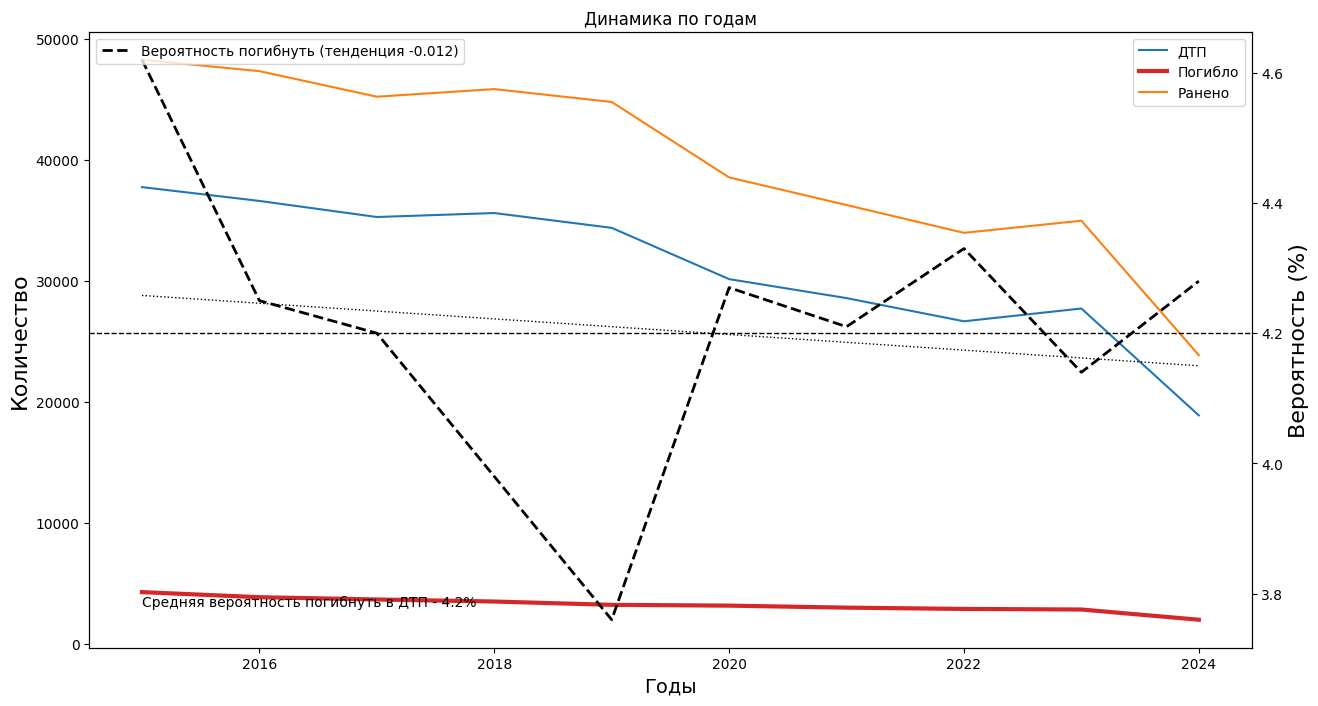

In [ ]:
dd = data.query(query_str).groupby('year').agg({'dtp_id': 'count',
                               'dead_count' : 'sum',
                               'injured_count' : 'sum',
                               'participants_count' : 'sum'})

factor_dynamics(dd)

Динамика осноных показателей по дням не очень наглядна, но видна цикличность основных показателей ДТП. Похоже, есть различия в количестве ДТП по месяцам / дням недели.

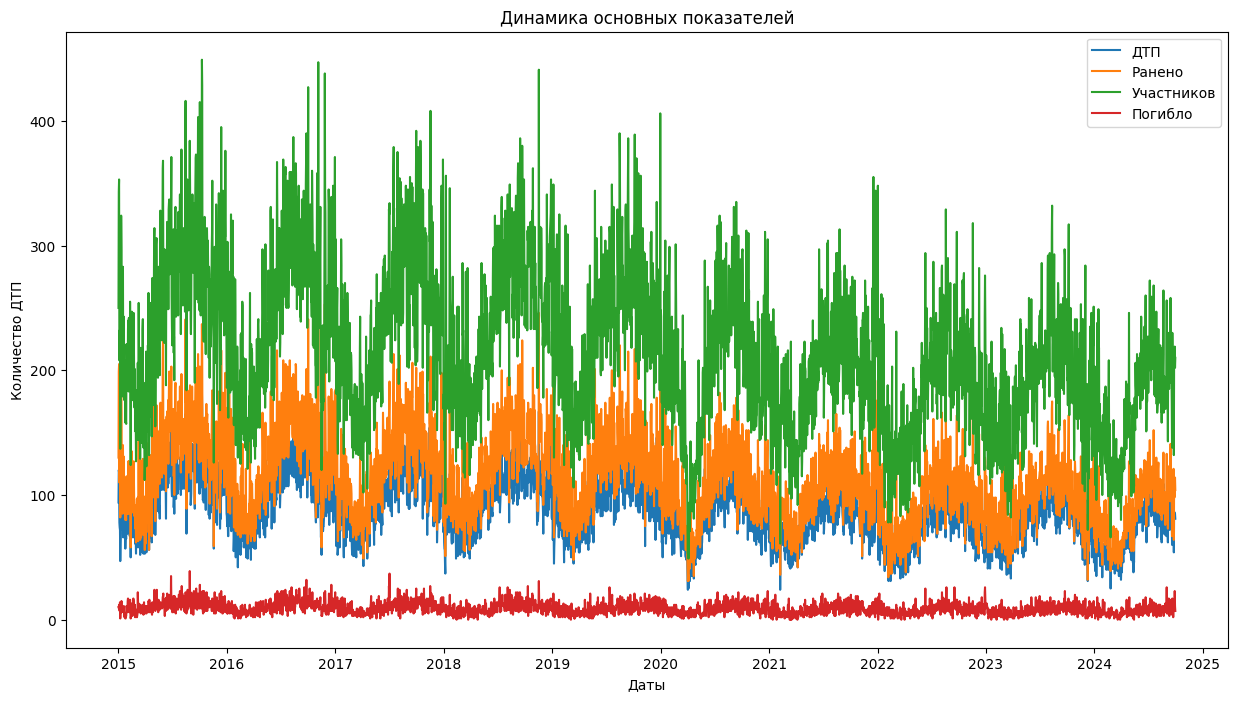

In [ ]:
plt.figure(figsize=(15,8))
dd = data.query(query_str).groupby('date').agg({'dtp_id': 'count',
                               'injured_count' : 'sum',
                               'participants_count' : 'sum',
                               'dead_count' : 'sum'})
plt.plot(dd, label = ['ДТП', 'Ранено', 'Участников', 'Погибло'])
plt.title('Динамика основных показателей')
plt.ylabel('Количество ДТП')
plt.xlabel('Даты')
plt.legend()
plt.show()

### Территории антилидеры по количество ДТП, раненых и погибших

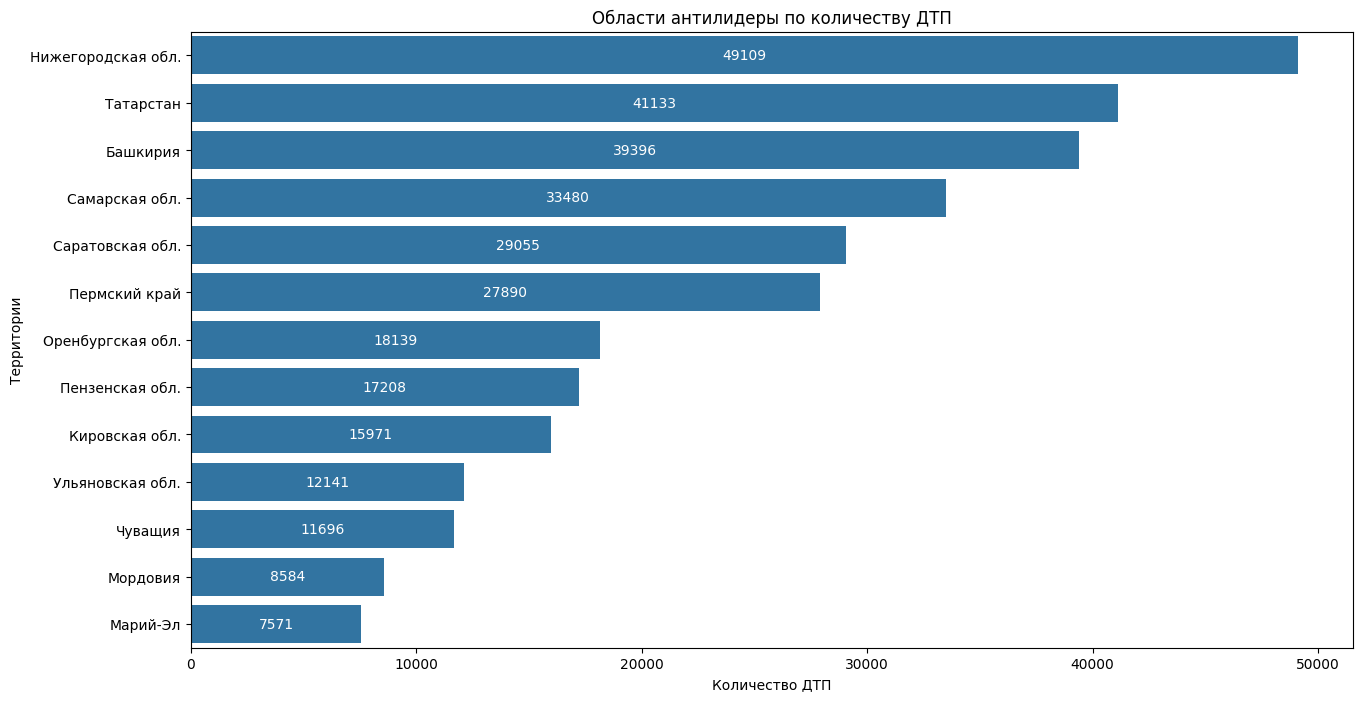

In [ ]:
plt.figure(figsize=(15,8))
dd = data.query(query_str).groupby('oblast', as_index=False)['dtp_id'].count().sort_values(by='dtp_id', ascending=False).head(15)
ax = sns.barplot(x=dd['dtp_id'], y=dd['oblast'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('Области антилидеры по количеству ДТП')
plt.ylabel('Территории')
plt.xlabel('Количество ДТП')
plt.show()

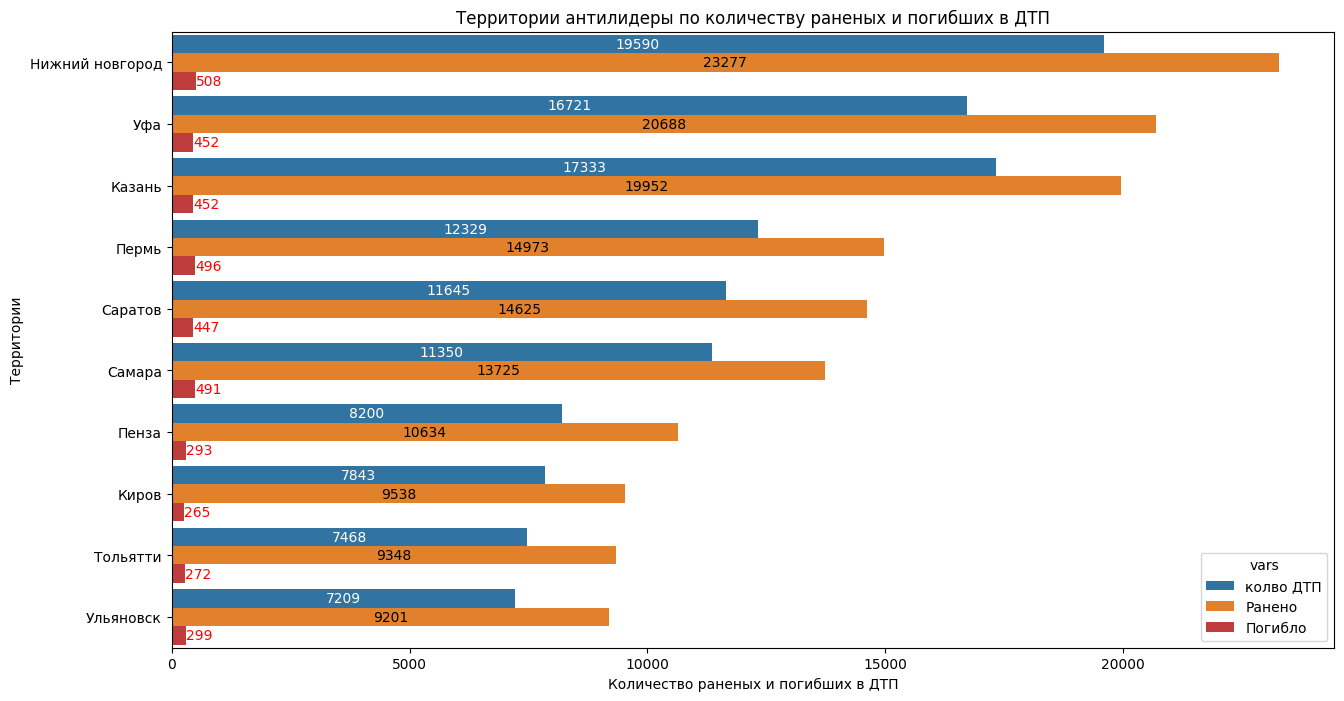

In [ ]:
plt.figure(figsize=(15,8))

dd = data.query(query_str).groupby('region', as_index=False)\
  .agg({'dtp_id' : 'count', 'injured_count' : 'sum', 'dead_count' : 'sum'})\
  .sort_values(by='injured_count', ascending=False).head(10)

dd = dd.rename(columns={'dtp_id' : 'колво ДТП', 'injured_count' : 'Ранено', 'dead_count' : 'Погибло'})
dd = dd.melt(id_vars="region", var_name="vars").reset_index(drop=True)

color = ['tab:blue', 'tab:orange', 'tab:red']

ax = sns.barplot(y='region', x='value', hue="vars", palette = color, width=0.9, data=dd)
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')
ax.bar_label(ax.containers[1], fontsize=10, label_type='center', color='black')
ax.bar_label(ax.containers[2], fontsize=10, label_type='edge', color='red')

plt.title('Территории антилидеры по количеству раненых и погибших в ДТП')
plt.ylabel('Территории')
plt.xlabel('Количество раненых и погибших в ДТП')
plt.show()

### Доли последстий и результатов ДТП

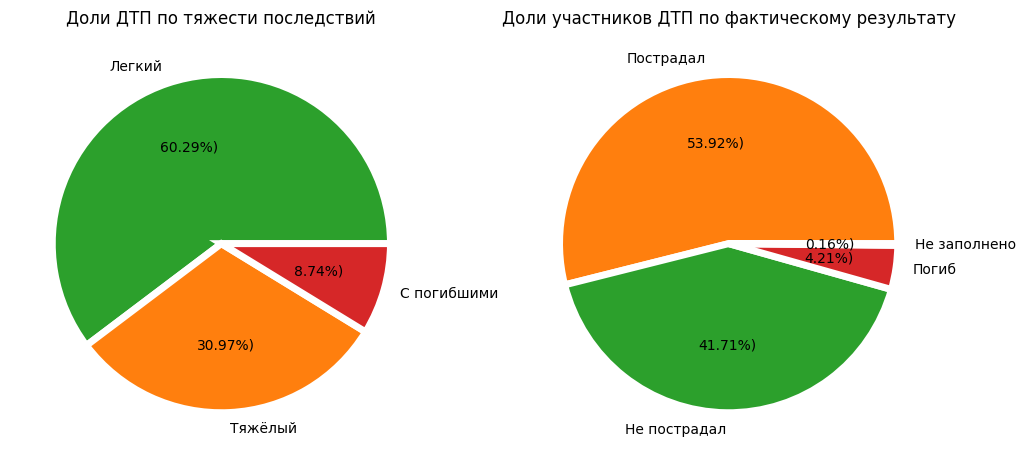

<Figure size 1200x800 with 0 Axes>

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12,8))

dd = data.query(query_str)['severity'].value_counts().reset_index()
dd['color'] = dd['severity'].replace({'С погибшими' : 'tab:red',
                    'Тяжёлый' : 'tab:orange',
                    'Легкий' : 'tab:green',
                    'Не заполнено' : 'tab:blue'}, regex=False)

ax[0].pie(x = dd['count'], labels = dd['severity'], colors = dd['color'], wedgeprops={'linewidth': 5.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
ax[0].set_title('Доли ДТП по тяжести последствий')

dd = partic[partic['dtp_id'].isin(seg_dtp_id)]['result'].value_counts().reset_index()
dd['color'] = dd['result'].replace({'Погиб' : 'tab:red',
                    'Пострадал' : 'tab:orange',
                    'Не пострадал' : 'tab:green',
                    'Не заполнено' : 'tab:blue'}, regex=False)
ax[1].pie(x = dd['count'], labels = dd['result'], colors = dd['color'], wedgeprops={'linewidth': 5.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
ax[1].set_title('Доли участников ДТП по фактическому результату')

plt.figure(figsize=(12,8))

plt.show()

### Распределение ДТП по маркам участвовавших в них ТС

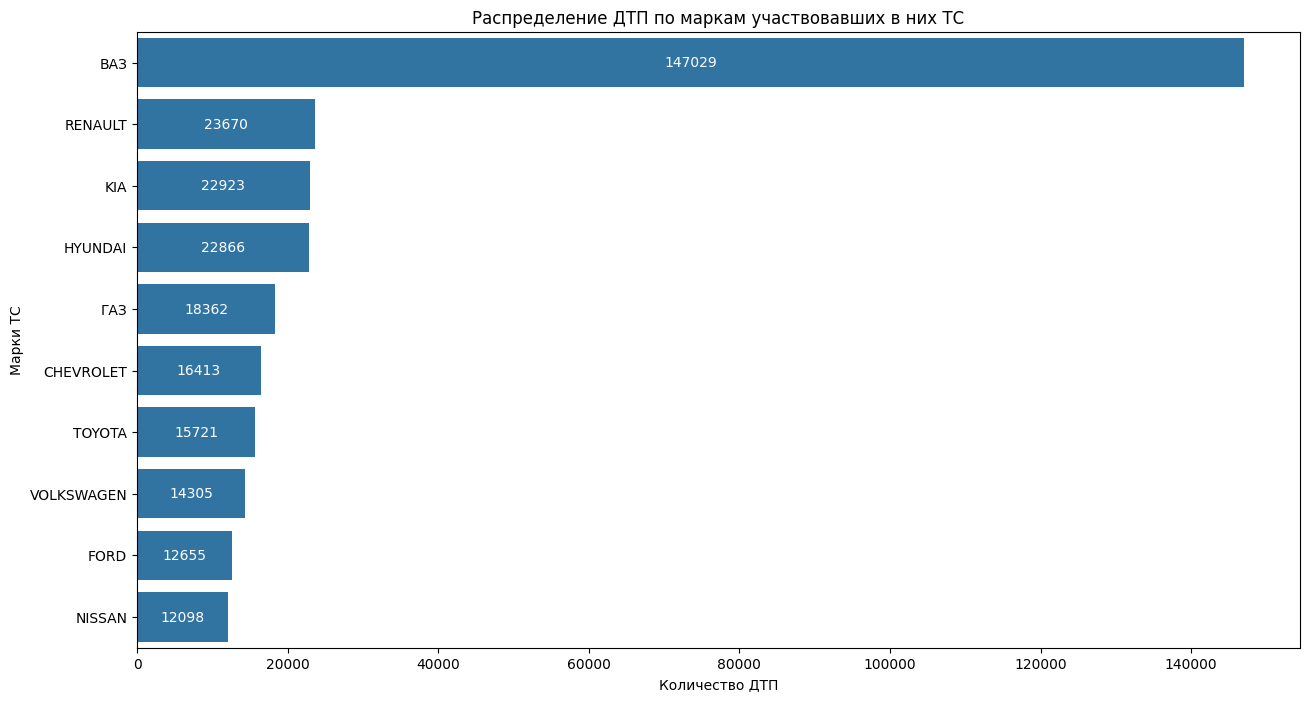

In [ ]:
plt.figure(figsize=(15,8))
dd = cars[cars['dtp_id'].isin(seg_dtp_id)].query('brand != "Прочие марки ТС"')\
      .groupby('brand', as_index=False)['dtp_id'].count()\
      .sort_values(by='dtp_id', ascending=False).head(10)

ax = sns.barplot(x=dd['dtp_id'], y=dd['brand'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('Распределение ДТП по маркам участвовавших в них ТС')
plt.ylabel('Марки ТС')
plt.xlabel('Количество ДТП')
plt.show()

### Модели ТС, наиболее часто попадающие в ДТП

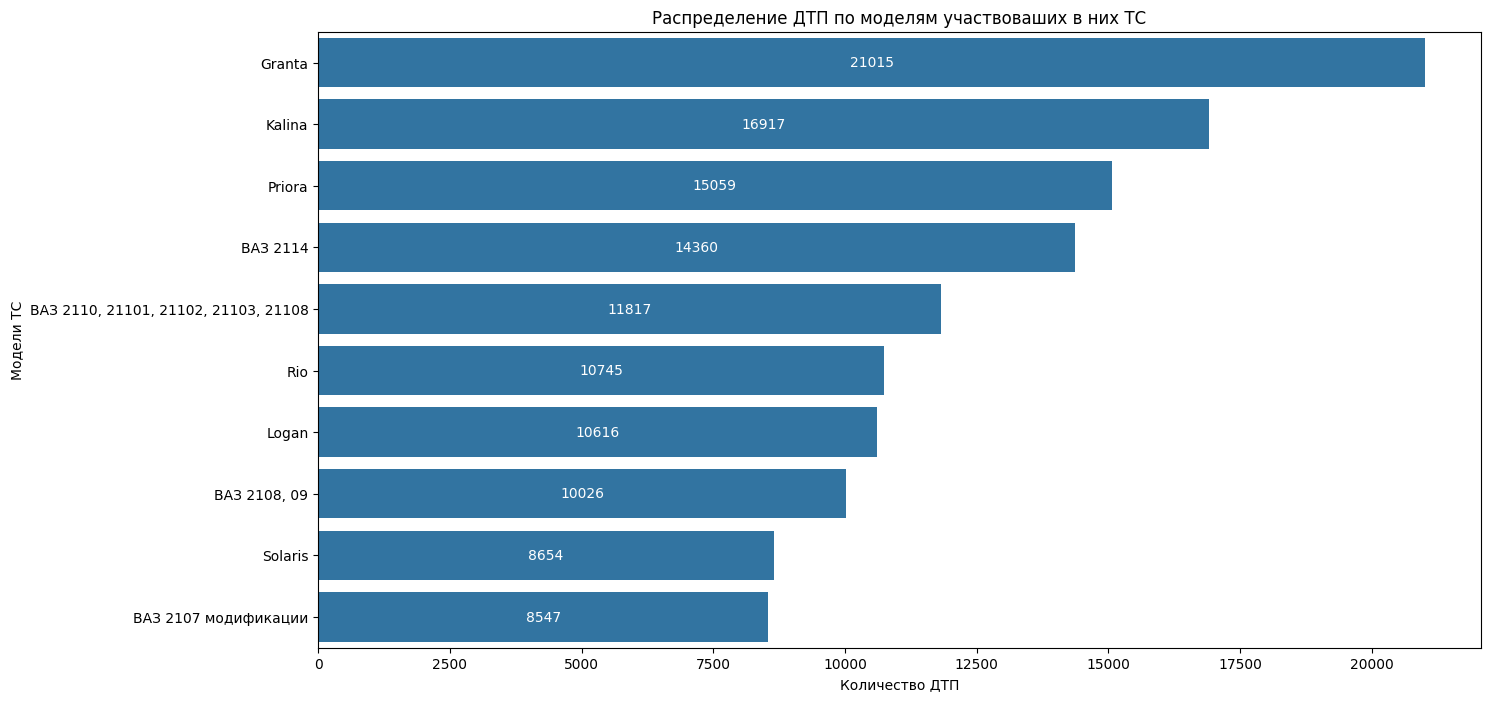

In [ ]:
plt.figure(figsize=(15,8))
dd = cars[cars['dtp_id'].isin(seg_dtp_id)].query('model != "Прочие модели"')\
    .groupby('model', as_index=False)['dtp_id'].count()\
    .sort_values(by='dtp_id', ascending=False).head(10)

ax = sns.barplot(x=dd['dtp_id'], y=dd['model'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('Распределение ДТП по моделям участвоваших в них ТС')
plt.ylabel('Модели ТС')
plt.xlabel('Количество ДТП')
plt.show()

### Распределение ДТП по количеству участвовавших в них ТС

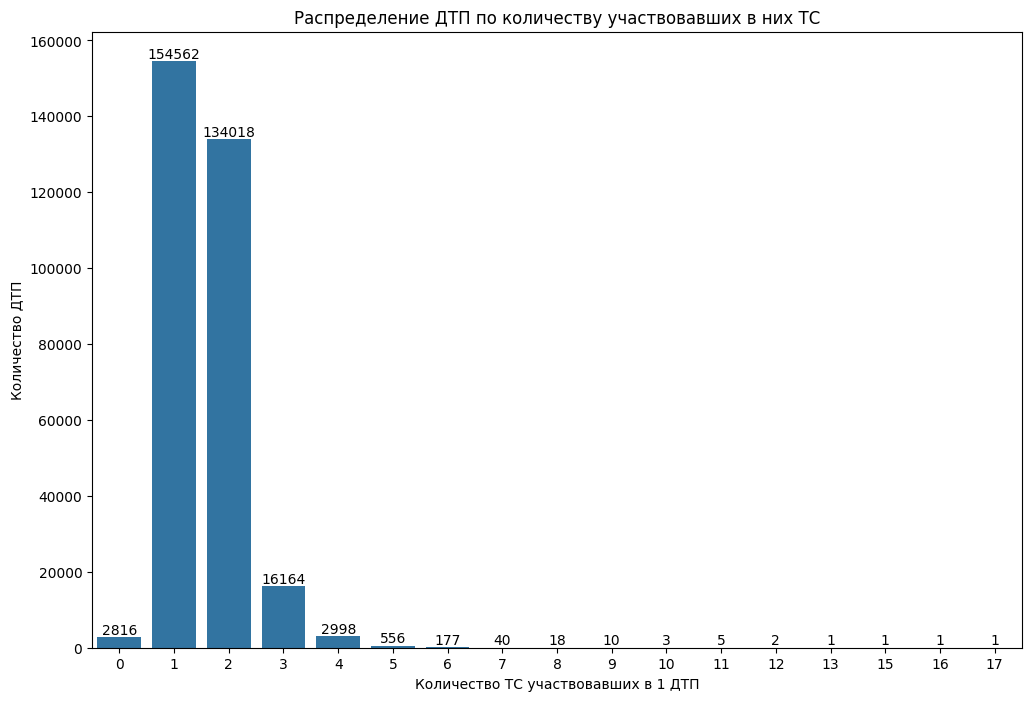

In [ ]:
plt.figure(figsize=(12,8))
dd = data.query(query_str).groupby('cars_count', as_index=False)['dtp_id'].count().sort_values(by='dtp_id', ascending=False)
ax = sns.barplot(x=dd['cars_count'], y=dd['dtp_id'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10,label_type='edge', color='black')

plt.title('Распределение ДТП по количеству участвовавших в них ТС')
plt.ylabel('Количество ДТП')
plt.xlabel('Количество ТС участвовавших в 1 ДТП')
plt.show()

ДТП без ТС это ДТП в большинстве случаев - наезд на пешехода, после которого, видимо, водители скрылись и их так и не нашли

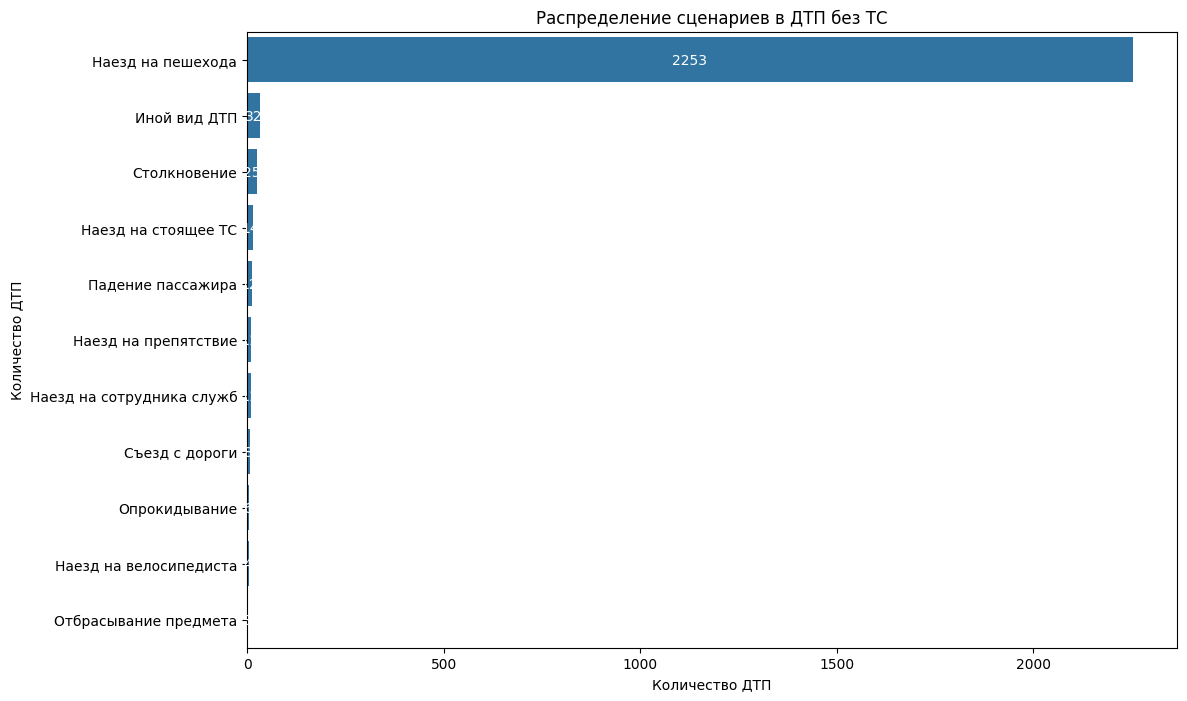

In [ ]:
plt.figure(figsize=(12,8))
partic_0cars = set(partic[partic['dtp_id'].isin(set(data[data['cars_count'] == 0]['dtp_id']))]['dtp_id'])
dd = data[data['dtp_id'].isin(partic_0cars)].groupby('category', as_index=False)['dtp_id'].count().sort_values(by='dtp_id', ascending=False)
ax = sns.barplot(x=dd['dtp_id'], y=dd['category'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10 ,label_type='center', color='white')

plt.title('Распределение сценариев в ДТП без ТС')
plt.ylabel('Количество ДТП')
plt.xlabel('Количество ДТП')
plt.show()


### Распределение раненых и погибших по сценариям ДТП

<Figure size 1200x800 with 0 Axes>

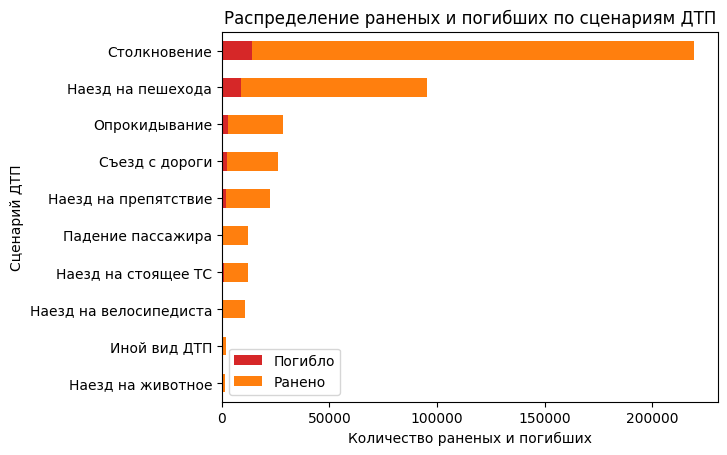

In [ ]:
plt.figure(figsize=(12,8))
dd = data.query(query_str).groupby('category', as_index=False)\
  .agg({'dead_count' : 'sum', 'injured_count' : 'sum'})\
  .sort_values(by='injured_count', ascending=False).head(10). sort_values(by='injured_count', ascending=True)

dd = dd.rename(columns={'injured_count' : 'Ранено', 'dead_count' : 'Погибло'})
dd.set_index('category', inplace=True)
color = ['tab:red', 'tab:orange']

dd.plot.barh(stacked=True, color = color)
plt.legend()

plt.title('Распределение раненых и погибших по сценариям ДТП')
plt.ylabel('Сценарий ДТП')
plt.xlabel('Количество раненых и погибших')
plt.show()

### Доля мужчин и женщин в различных ролях ДТП

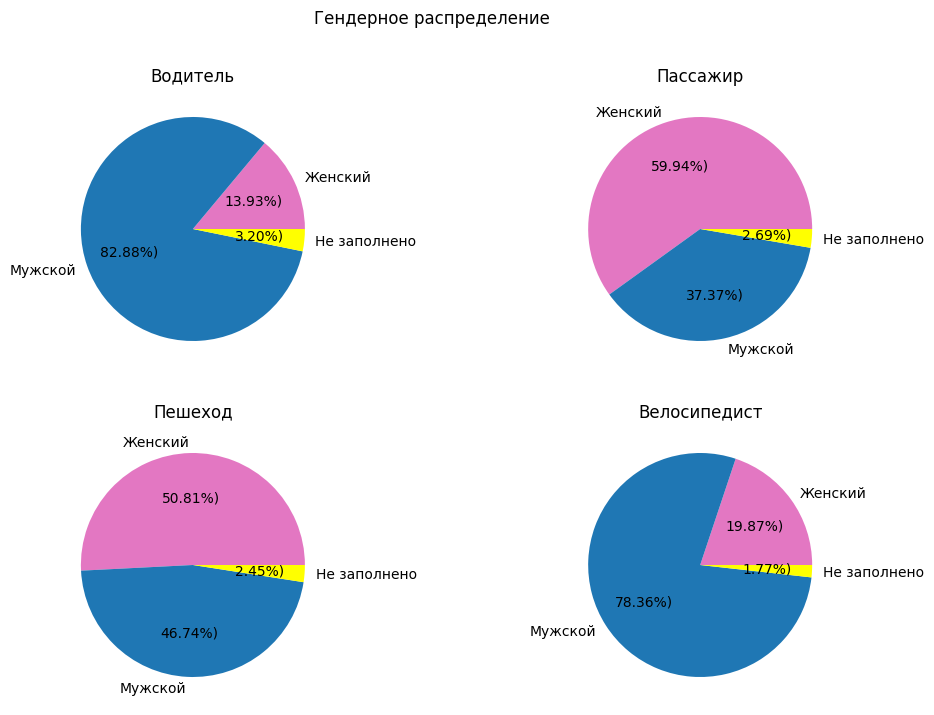

In [ ]:
roles = ('Водитель', 'Пешеход', 'Пассажир', 'Велосипедист')
f, ax = plt.subplots(2, 2, figsize=(12,8))
x = 0
y = 0
colors = ['tab:pink', 'tab:blue', 'yellow']
labels = ['Женский', 'Мужской', 'Не заполнено']
for r in roles:
    dd = partic[partic['dtp_id'].isin(seg_dtp_id)].query('role.str.match(@r)').groupby('gender')['partic_id'].count()
    ax[x, y].pie(x = dd, labels = labels,  autopct=lambda p : '{:.2f}%)'.format(p), colors = colors)
    ax[x, y].set_title(r)

    x +=1
    if x > 1:
        y +=1
        x = 0

plt.suptitle('Гендерное распределение')
plt.show()

Водителей больше мужчин, а пассажиров - женщин. При этом для пешеходов гендерное разделение практические одинакое.

### Доля исходов для различных ролей участников ДТП

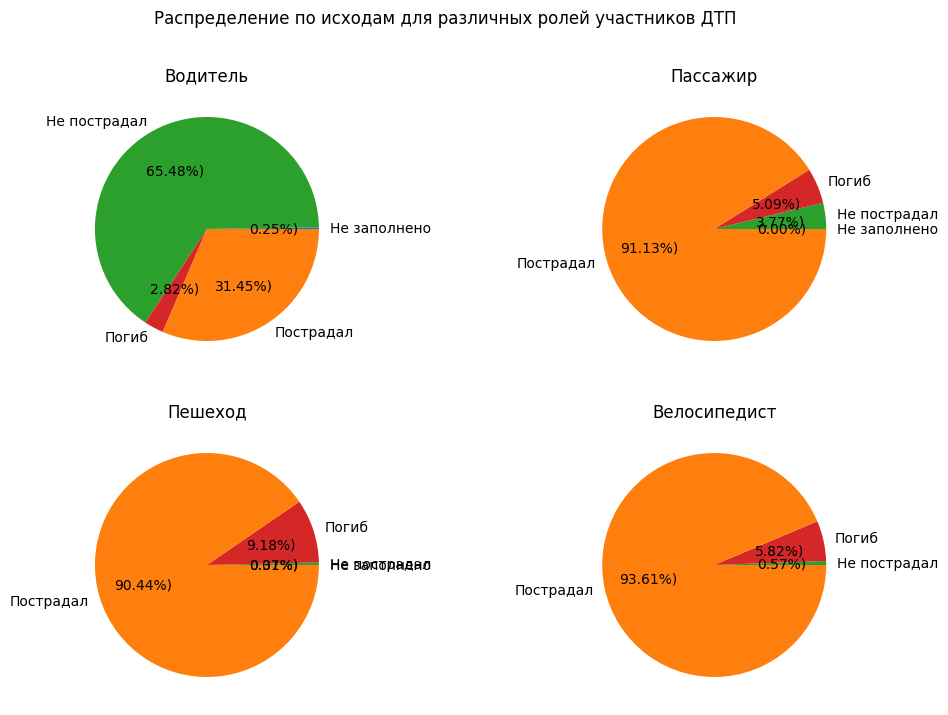

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(12,8))
x = 0
y = 0
#colors = ['tab:red', 'tab:orange', 'tab:green', 'yellow']
labels = ['Погиб', 'Пострадал', 'Не пострадал', 'Не заполнено']
for r in roles:
    dd = partic[partic['dtp_id'].isin(seg_dtp_id)].query('role.str.match(@r)').groupby('result', as_index = False)['partic_id'].count().sort_values(by = 'result')

    dd['color'] = dd['result'].replace({'Погиб' : 'tab:red',
                    'Пострадал' : 'tab:orange',
                    'Не пострадал' : 'tab:green',
                    'Не заполнено' : 'tab:blue'}, regex=True)

    ax[x, y].pie(x = dd['partic_id'], labels = dd['result'], colors = dd['color'], autopct=lambda p : '{:.2f}%)'.format(p))
    ax[x, y].set_title(r)

    x +=1
    if x > 1:
        y +=1
        x = 0

plt.suptitle('Распределение по исходам для различных ролей участников ДТП')
plt.show()

Интересно, что среди водителей так много непострадавший. Наверно, это связно с тем, что они должны остаться на месте ДТП, а пассажиры/пешеходы могут уйти. Или их не включают в протокол, если не пострадали....

### Доля нарушителей среди различных ролей участников ДТП

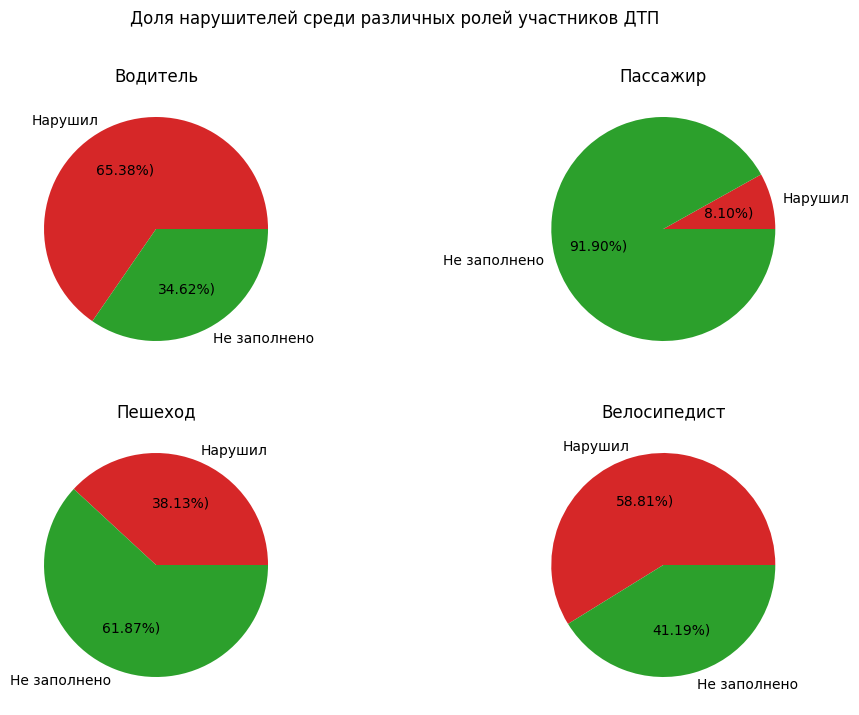

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(12,8))

colors = ['tab:red', 'tab:green', 'yellow']
x = 0
y = 0
for r in roles:
    p1 = partic[partic['dtp_id'].isin(seg_dtp_id)].query('(role.str.match(@r)) & (violations != "Не заполнено")')['partic_id'].count()
    p2 = len(partic[partic['dtp_id'].isin(seg_dtp_id)].query('role.str.match(@r)')) - p1
    ax[x, y].pie(x = [p1, p2], labels = ['Нарушил', 'Не заполнено'],  colors = colors, autopct=lambda p : '{:.2f}%)'.format(p))
    ax[x, y].set_title(r)

    x +=1
    if x > 1:
        y +=1
        x = 0
plt.suptitle('Доля нарушителей среди различных ролей участников ДТП')
plt.show()

Интересно, что у пассажиров тоже бывают нарушения
Посмотрим, что это за нарушения

In [ ]:
dd = partic.query('role == "Пассажир" & violations != "Не заполнено"').groupby('violations', as_index=False)['partic_id'].count().sort_values(by='partic_id', ascending=False).head(15)
dd

violations  \
8                                                                                          Нарушение правил применения ремней безопасности пассажиром   
6                                                                                               Нарушение правил пользования общественным транспортом   
0                                                                                                                                      Иные нарушения   
7                                                                                                    Нарушение правил применения мотошлема пассажиром   
3                                                                          Иные нарушения; Нарушение правил применения ремней безопасности пассажиром   
11                                                              Оставление движущегося транспортного средства (выход или выпрыгивание на ходу и т.д.)   
2                                                                                    Иные нарушения; Нарушение правил применения мотошлема пассажиром   
18                                                                                    Передача управления ТС лицу, находящемуся в состоянии опьянения   
21                                                                                    Создание помех для водителя в управлении транспортным средством   
16  Оставление движущегося транспортного средства (выход или выпрыгивание на ходу и т.д.); Нарушение правил применения ремней безопасности пассажиром   
26                        Создание помех для водителя в управлении транспортным средством; Нарушение правил применения ремней безопасности пассажиром   
1                                                                               Иные нарушения; Нарушение правил пользования общественным транспортом   
12                                              Оставление движущегося транспортного средства (выход или выпрыгивание на ходу и т.д.); Иные нарушения   
9                                   Нарушение правил применения ремней безопасности пассажиром; Нарушение правил пользования общественным транспортом   
20                        Передача управления ТС лицу, находящемуся в состоянии опьянения; Нарушение правил применения ремней безопасности пассажиром   

    partic_id  
8        6843  
6        3387  
0        1757  
7        1657  
3         395  
11        157  
2         121  
18         57  
21         47  
16         43  
26         26  
1          20  
12         19  
9          17  
20         12

### Самые часто встречающиеся нарушения при ДТП

In [ ]:
%%time
vd = pd.DataFrame(columns=['violations', 'dtp_count'])
all_violations = set('; '.join(partic['violations'].unique()).split('; '))
i = 0
for v in all_violations:
    if v == 'Не заполнено' : continue
    if v == 'Иные нарушения' : continue
    vd.loc[i, 'violations'] = str(v)[0:50]+'...'
    vd.loc[i, 'dtp_count'] = partic.query('violations.str.contains(@v, regex=False)')['dtp_id'].nunique()
    vd.loc[i, 'dead_count'] = partic.query('(violations.str.contains(@v, regex=False)) & (result == "Погиб")')['dtp_id'].nunique()
    i +=1

CPU times: user 56.8 s, sys: 274 ms, total: 57.1 s
Wall time: 57.3 s


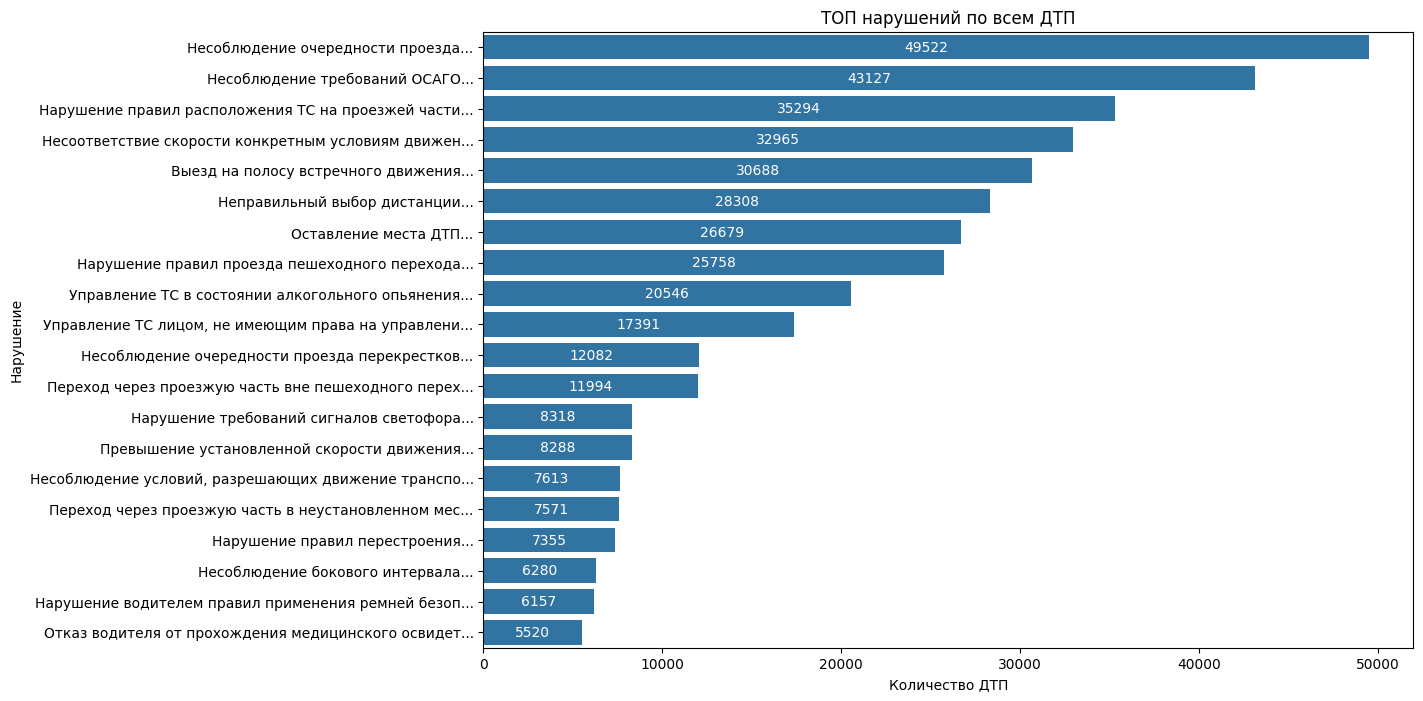

In [ ]:
vd = vd.sort_values(by = 'dtp_count', ascending=False).head(20)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=vd['dtp_count'], y=vd['violations'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('ТОП нарушений по всем ДТП')
plt.ylabel('Нарушение')
plt.xlabel('Количество ДТП')
plt.show()

### ТОП нарушений при смертельных ДТП

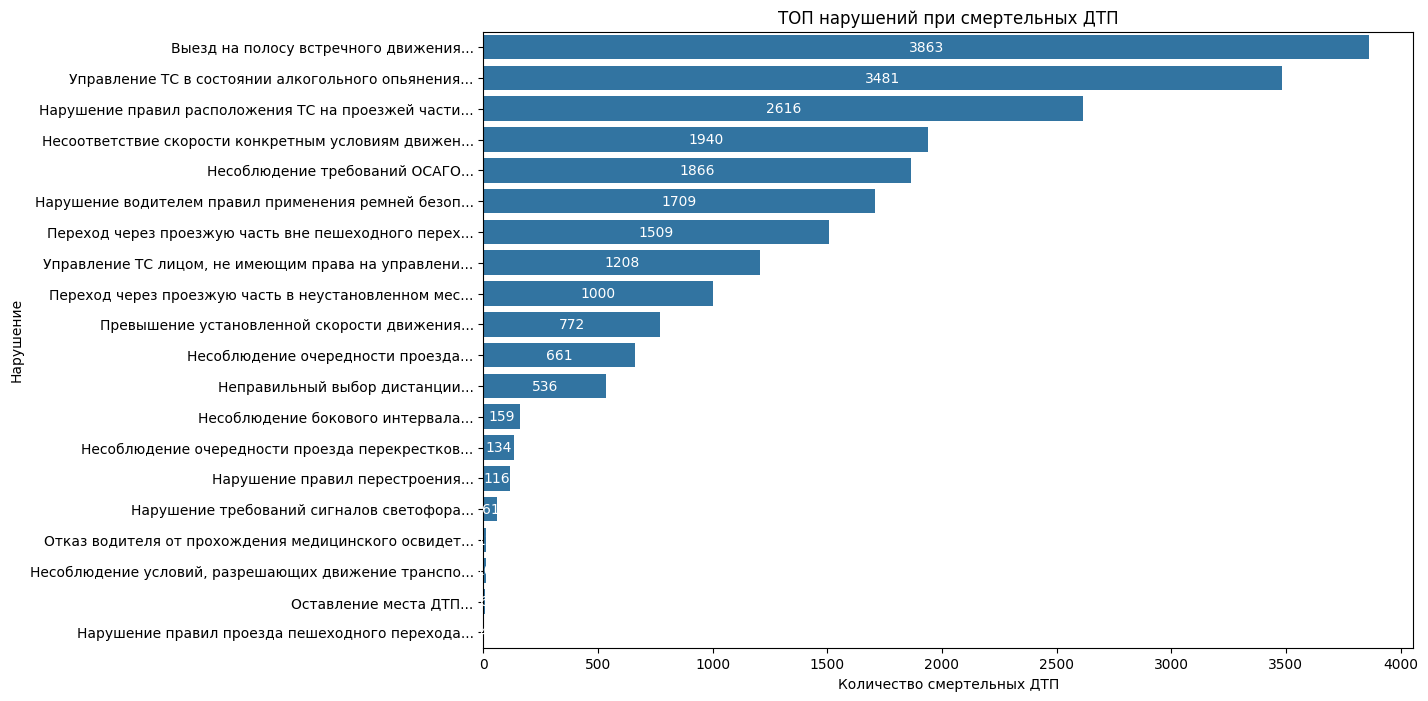

In [ ]:
vd = vd.sort_values(by = 'dead_count', ascending=False).head(20)
plt.figure(figsize=(12,8))

ax = sns.barplot(x=vd['dead_count'], y=vd['violations'], color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='center', color='white')

plt.title('ТОП нарушений при смертельных ДТП')
plt.ylabel('Нарушение')
plt.xlabel('Количество смертельных ДТП')
plt.show()

### Динамика "пьяных" ДТП и последствий от них

In [ ]:
alco_dtp_drivers = partic.query('(role == "Водитель") & (violations.str.contains("опьянения"))')['dtp_id'].unique()
alco_dtp_all = partic.query('violations.str.contains("опьянения")')['dtp_id'].unique()

In [ ]:
alco_dtp_by_month = data[data['dtp_id'].isin(alco_dtp_all)].groupby(['year','month']).agg({'dtp_id': 'count', 'severity_id': 'sum'})
notalco_dtp_by_month = data[~data['dtp_id'].isin(alco_dtp_all)].groupby(['year','month']).agg({'dtp_id': 'count', 'severity_id': 'sum'})

In [ ]:
alco_dtp_by_month.columns = ['dtp_count', 'severity_sum']
notalco_dtp_by_month.columns = ['dtp_count', 'severity_sum']
alco_dtp_by_month['severity_1dtp'] = alco_dtp_by_month['severity_sum'] / alco_dtp_by_month['dtp_count']
notalco_dtp_by_month['severity_1dtp'] = notalco_dtp_by_month['severity_sum'] / notalco_dtp_by_month['dtp_count']

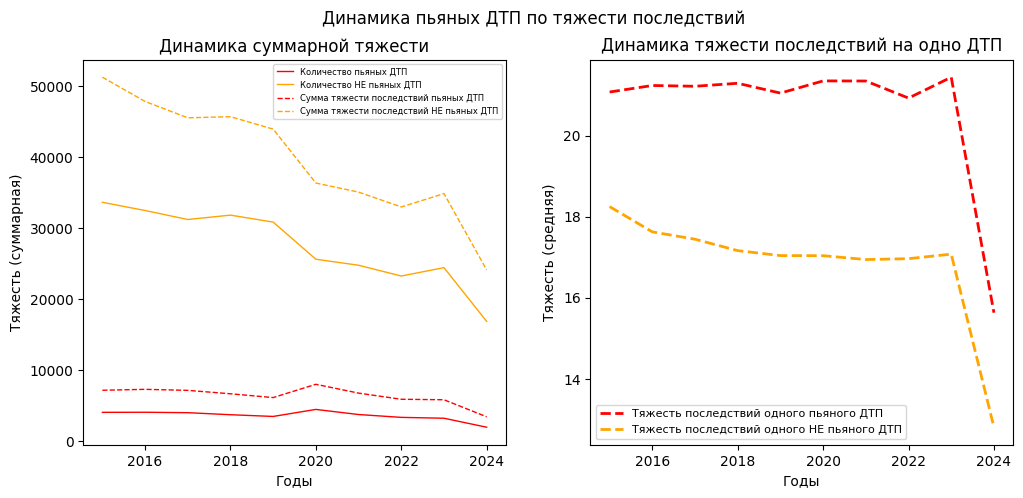

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

alco_dtp_by_month.groupby(['year'])['dtp_count'].sum().plot(ax=axes[0],
                label = "Количество пьяных ДТП", color='red', linestyle = 'solid', linewidth = 1)
notalco_dtp_by_month.groupby(['year'])['dtp_count'].sum().plot(ax=axes[0],
                label = "Количество НЕ пьяных ДТП", color='orange', linestyle = 'solid', linewidth = 1)
alco_dtp_by_month.groupby(['year'])['severity_sum'].sum().plot(ax=axes[0],
                label = "Сумма тяжести последствий пьяных ДТП", color='red', linestyle = '--',  linewidth = 1)
notalco_dtp_by_month.groupby(['year'])['severity_sum'].sum().plot(ax=axes[0],
                label = "Сумма тяжести последствий НЕ пьяных ДТП", color='orange',linestyle = '--',  linewidth = 1)
axes[0].set_xlabel('Годы')
axes[0].set_ylabel('Тяжесть (суммарная)')
axes[0].legend(loc='upper right', fontsize = 6)
axes[0].set_title('Динамика суммарной тяжести')

#ax3 = ax.twinx ()
axes[1] = alco_dtp_by_month.groupby(['year'])['severity_1dtp'].sum().plot(ax=axes[1],
              label = "Тяжесть последствий одного пьяного ДТП", color='red', linewidth = 2, linestyle = '--')
axes[1] = notalco_dtp_by_month.groupby(['year'])['severity_1dtp'].sum().plot(ax=axes[1],
               label = "Тяжесть последствий одного НЕ пьяного ДТП", color='orange', linewidth = 2, linestyle = '--')
axes[1].set_xlabel('Годы')
axes[1].set_ylabel('Тяжесть (средняя)')
axes[1].legend(loc='lower left', fontsize = 8)
axes[1].set_title('Динамика тяжести последствий на одно ДТП')
plt.suptitle('Динамика пьяных ДТП по тяжести последствий')
plt.show()

# **Корреляции**

Проверяем кореляции различных параметров в таблицах. Зеленным окрашиваются ячейки с pvalue < 0.05, то есть параметры, образующие ее както коррелириют



Если p-значение меньше уровня значимости (обычно 0.05), то гипотеза о независимости отвергается, и можно заключить, что существует статистически значимая связь между переменными.
Зеленым подкрашивается ячейки в которых pvalue меньге 0.05

In [ ]:
x2_krit = pd.DataFrame(columns = [])
for cy in set({'weekday', 'oblast', 'nearby', 'weather', 'road_conditions', 'category'}):
        for cx in set({'dead_count', 'injured_count', 'severity'}):
            #p = 1
            #if cx != cy:
            contingency_table = pd.crosstab(data[cy], data[cx])
            p = stats.chi2_contingency(contingency_table)[1]
            x2_krit.loc[cy, cx] = p
x2_krit.style.apply(highlight_stat, color='lime')

In [ ]:
dtp_corr = data[['dtp_id', 'dead_count', 'injured_count', 'severity']]
car_corr = cars[['dtp_id', 'car_id', 'brand', 'model', 'color']]
partic_corr = partic[['dtp_id', 'car_id', 'gender', 'role', 'years_of_driving_experience', 'violations', 'health_status', 'result']]

In [ ]:
car_dtp_corr = car_corr.merge(dtp_corr, how='left', on='dtp_id', right_index=False)

x2_krit = pd.DataFrame(columns = [])
for cy in set({'brand', 'model', 'color'}):
        for cx in set({'dead_count', 'injured_count', 'severity'}):
            #p = 1
            #if cx != cy:
            contingency_table = pd.crosstab(car_dtp_corr[cy], car_dtp_corr[cx])
            p = stats.chi2_contingency(contingency_table)[1]
            x2_krit.loc[cy, cx] = p

x2_krit.style.apply(highlight_stat, color='lime')

In [ ]:
partic_dtp_corr = partic_corr.merge(dtp_corr, how='left', on='dtp_id', right_index=False)

x2_krit = pd.DataFrame(columns = [])
for cy in set({'gender', 'role', 'years_of_driving_experience', 'violations'}):
        for cx in set({'dead_count', 'injured_count', 'severity', 'result'}):
            #p = 1
            #if cx != cy:
            contingency_table = pd.crosstab(partic_dtp_corr[cy], partic_dtp_corr[cx])
            p = stats.chi2_contingency(contingency_table)[1]
            x2_krit.loc[cy, cx] = p

x2_krit.style.apply(highlight_stat, color='lime')

In [ ]:
partic_car_corr = partic_corr.merge(car_corr, how='left', on='car_id', right_index=False)

x2_krit = pd.DataFrame(columns = [])
for cy in set({'gender', 'role','years_of_driving_experience', 'violations', 'result'}):
        for cx in set({'brand', 'model', 'color'}):
            #p = 1
            #if cx != cy:
            contingency_table = pd.crosstab(partic_car_corr[cy], partic_car_corr[cx])
            p = stats.chi2_contingency(contingency_table)[1]
            x2_krit.loc[cy, cx] = p

x2_krit.style.apply(highlight_stat, color='lime')

# **Факторы, при которых вероятность погибнуть в ДТП выше среднего**

Вероятность погибнуть рассчитывается как количество погибших в ДТП при определенном факторе деленное на количество всех людей, которые участвовали во ДТП при данном факторе. Затем эта вероятность сравнивается с аналогичнор вычисленной вероятностью по всей выборке без каких либо факторов (около 4%). Получается сравнение двух пропорции. Для сравнения пропорций используется Z-тест.

## *Внешние факторы повышенной вероятности смертельных ДТП (погода, дорожное покрытие, произошло рядом с ... )*

In [ ]:
%%time
factors_all = factors('nearby')
factors_all = pd.concat([factors_all, factors('weather')])
factors_all = pd.concat([factors_all, factors('road_conditions')])
#factors_all = pd.concat([factors_all, factors('category')])
factors_all = factors_all.reset_index(drop = True)

CPU times: user 18.8 s, sys: 53.1 ms, total: 18.8 s
Wall time: 18.9 s


In [ ]:
factors_all['dtp_per'] = round(100 * factors_all['dtp_count'] / all_dtp_count, 2)
factors_all['injured_per'] = round(100 * factors_all['injured_count'] / all_injured_count, 2)
factors_all['dead_per'] = round(100 * factors_all['dead_count'] / all_dead_count, 2)
factors_all['dead_p'] = round(100 * factors_all['dead_count'] / factors_all['participants_count'], 2)
factors_all['injured_p'] = round(100 * factors_all['injured_count'] / factors_all['participants_count'], 2)

In [ ]:
zkrit_to_all(factors_all)

### ТОП внешних факторов по доли погибших при ДТП

In [ ]:
top_dead_factors = factors_all[(factors_all['factor'] != 'Не заполнено')\
            & (factors_all['dtp_count'] > 100)\
            & (factors_all['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop = True)

factor_dead_table(top_dead_factors[['factor', 'type', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

Оранжевым подсвечивается z-критерий для которого p-value < 0.05. То есть превышение средней вероятности смерти для фактора этой строчки - стастический достоверно

В топе внешних факторов часто встречаются факторы связанные с освещением. Посмотрим, ктого чаще касатся такие ДТП

In [ ]:
dark_dtp = set(data.query('road_conditions.str.contains("освещен")')['dtp_id'])

In [ ]:
dark_dtpresult = partic[partic['dtp_id'].isin(dark_dtp)].groupby(['role', 'result'], as_index = False)['partic_id'].count()

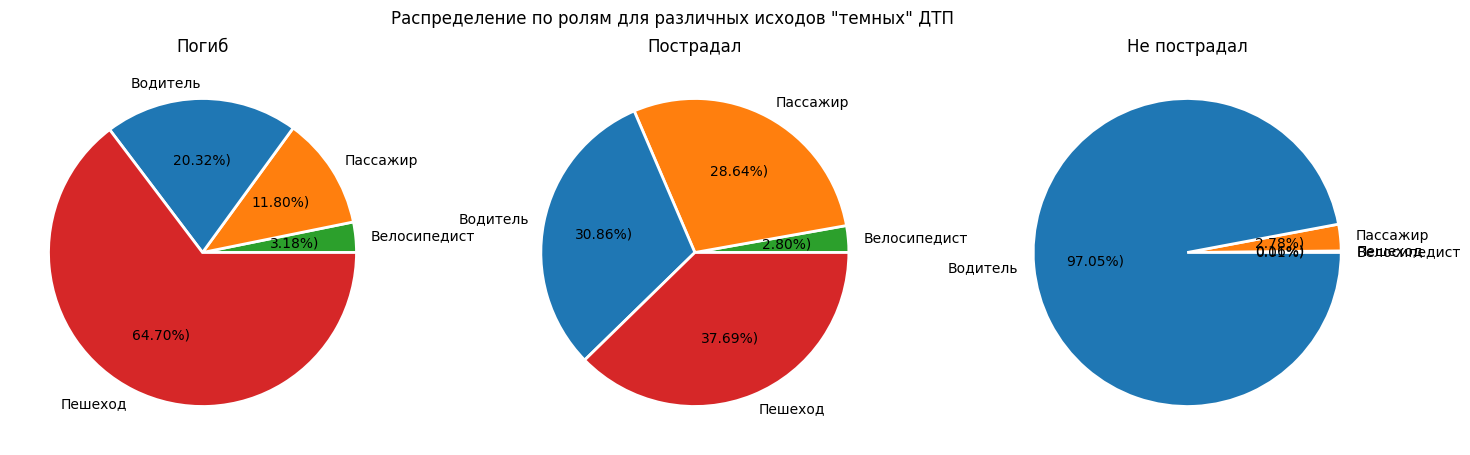

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(18,5))
x = 0
results = ('Погиб', 'Пострадал', 'Не пострадал')
for r in results:
    dd = dark_dtpresult.query('result == @r').sort_values(by = 'partic_id')


    dd['color'] = dd['role'].replace({'Водитель' : 'tab:blue',
                    'Пассажир' : 'tab:orange',
                    'Пешеход' : 'tab:red',
                    'Велосипедист' : 'tab:green'}, regex=True)

    ax[x].pie(x = dd['partic_id'], labels = dd['role'], colors = dd['color'],
              wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
              autopct=lambda p : '{:.2f}%)'.format(p))
    ax[x].set_title(r)

    x +=1

plt.suptitle('Распределение по ролям для различных исходов "темных" ДТП')
plt.show()

### Динамика ТОП внешних факторов по доли погибших в ДТП по годам

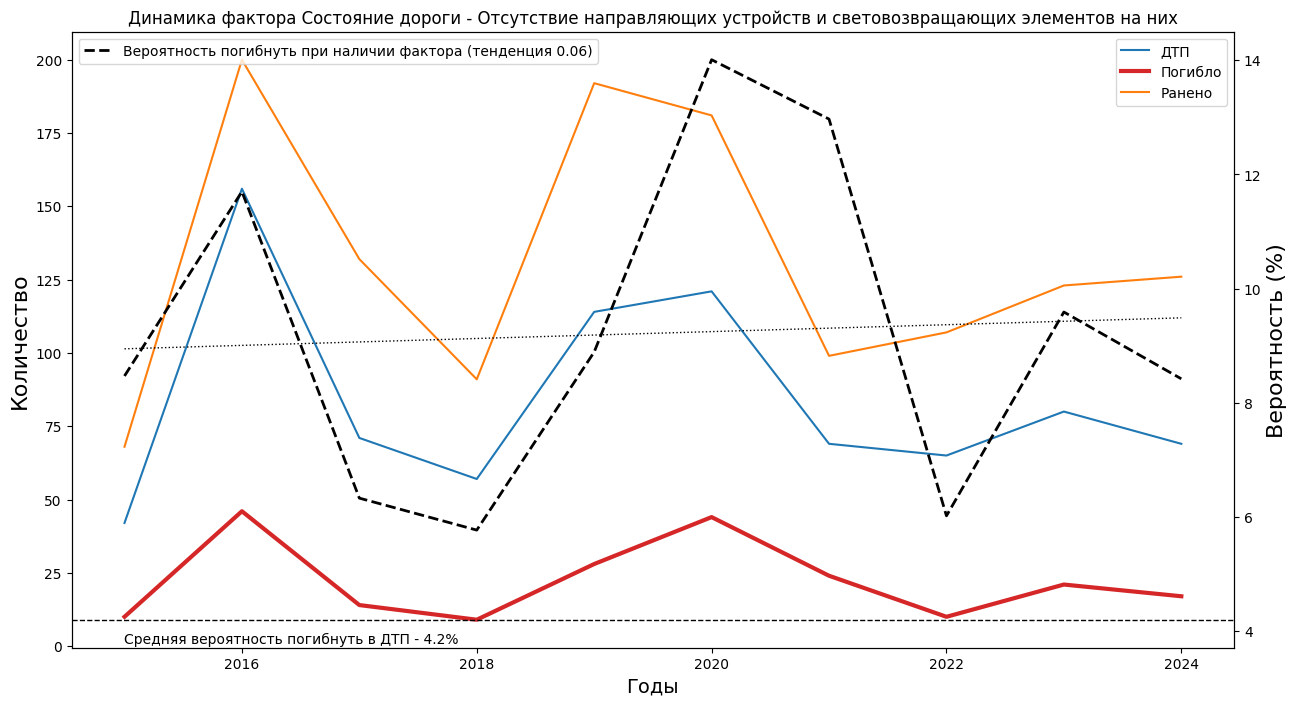

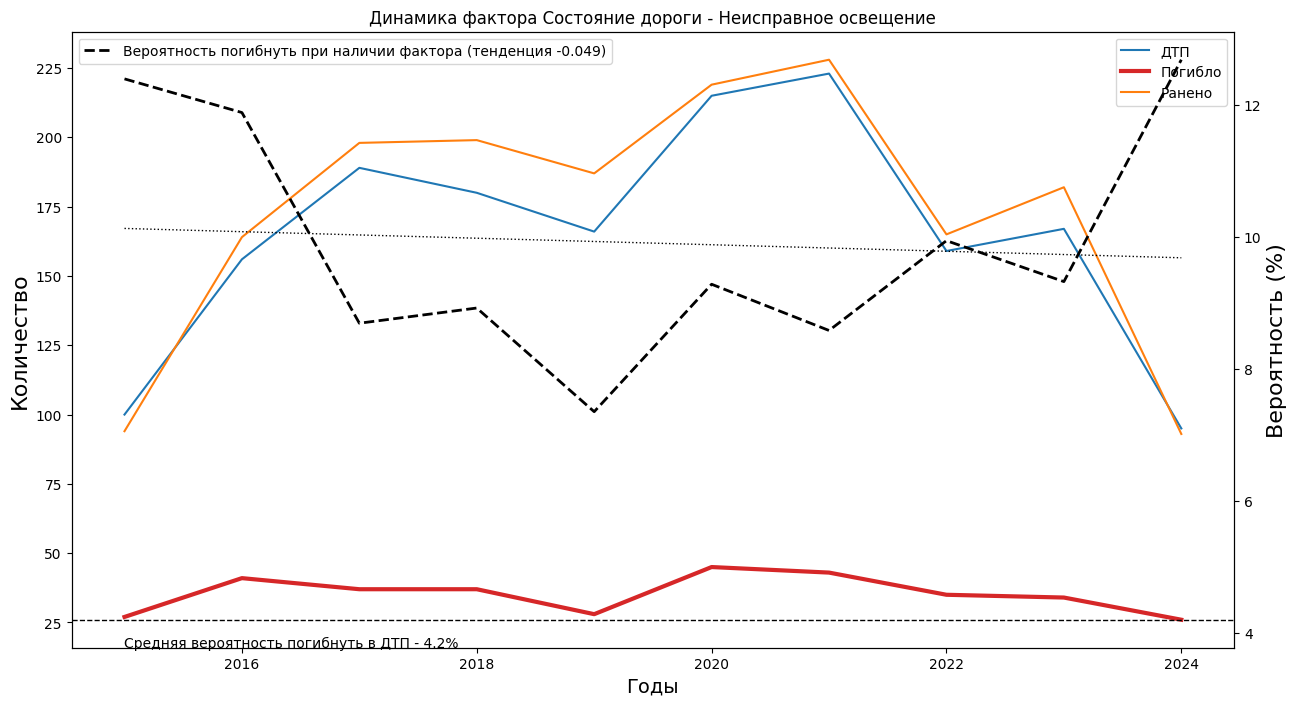

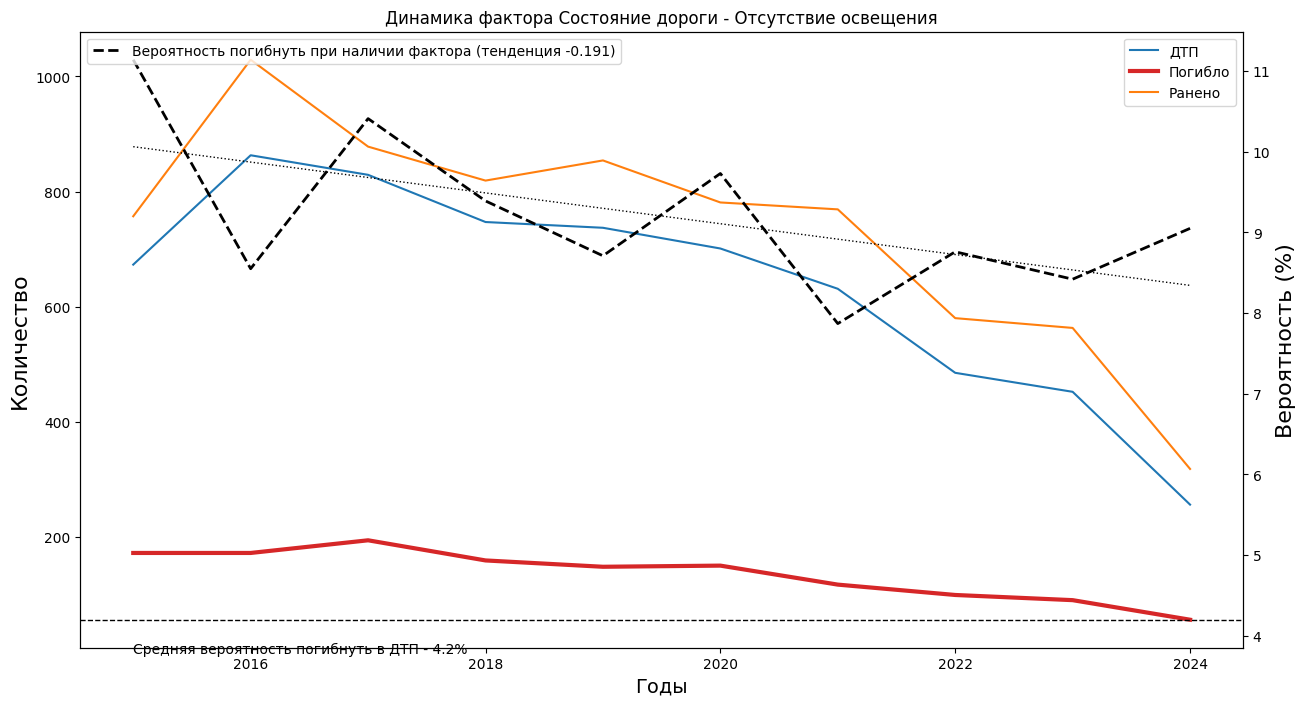

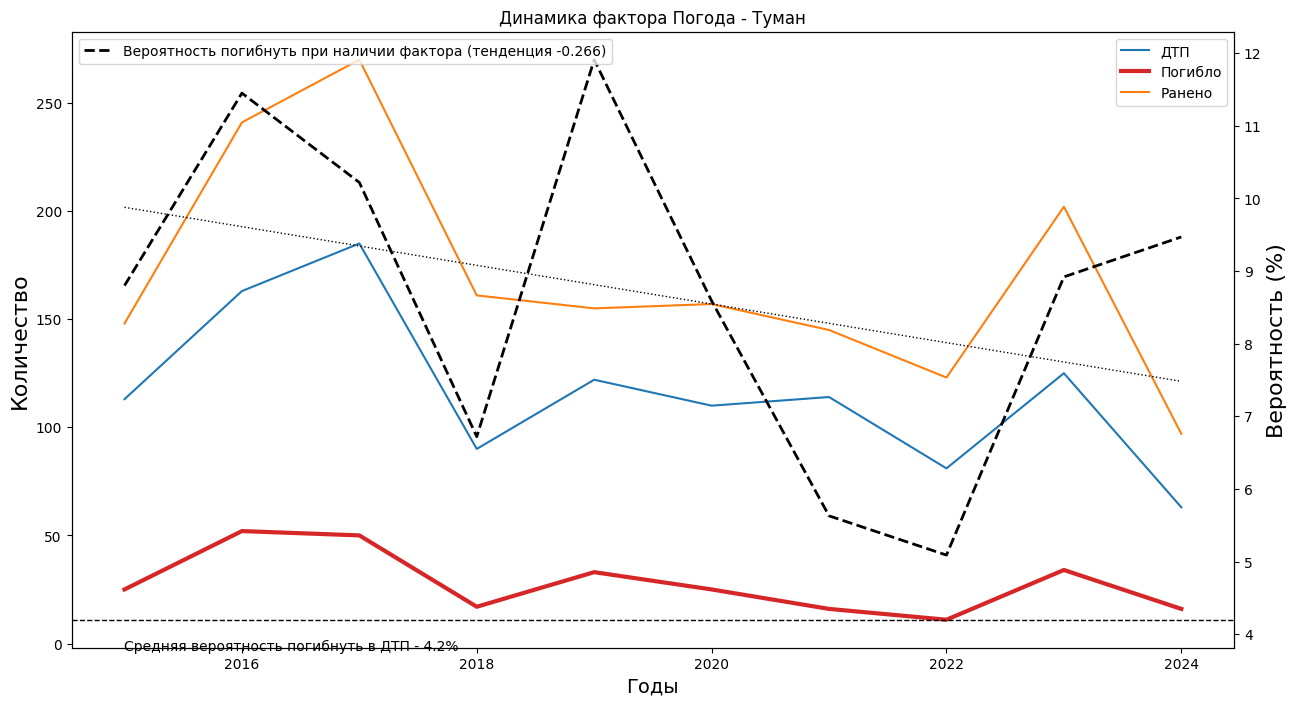

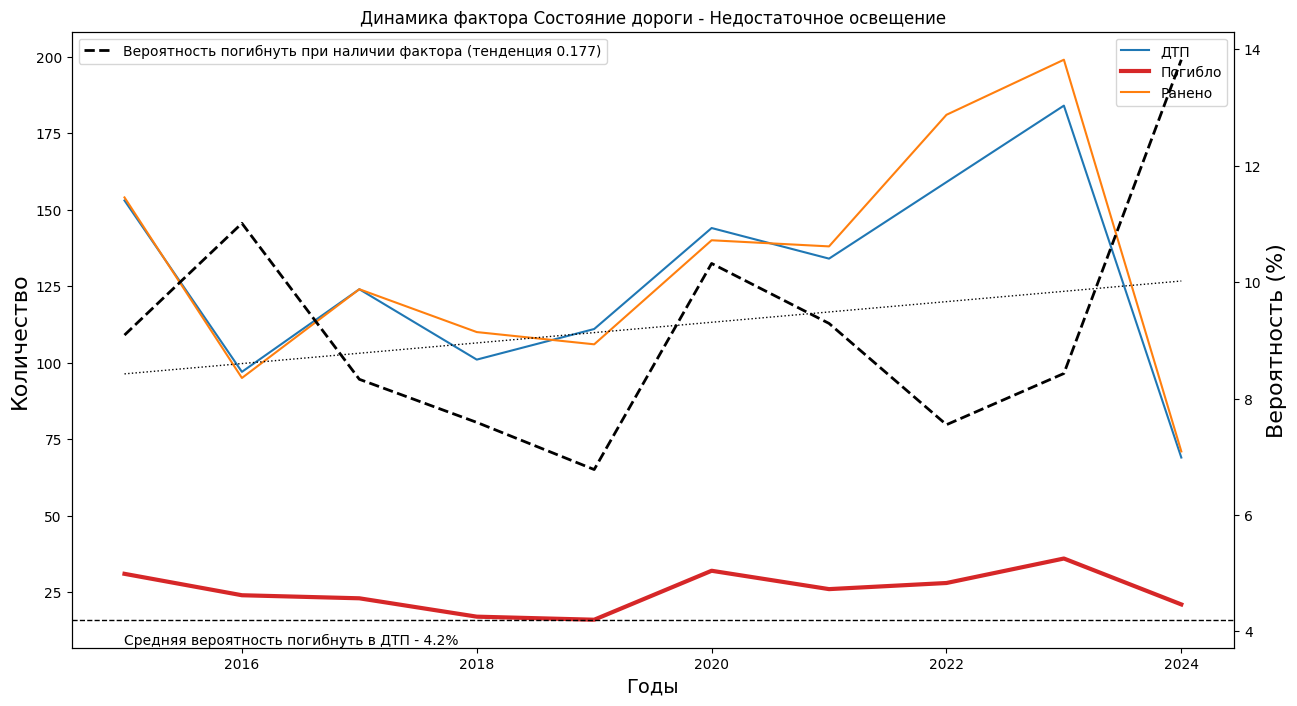

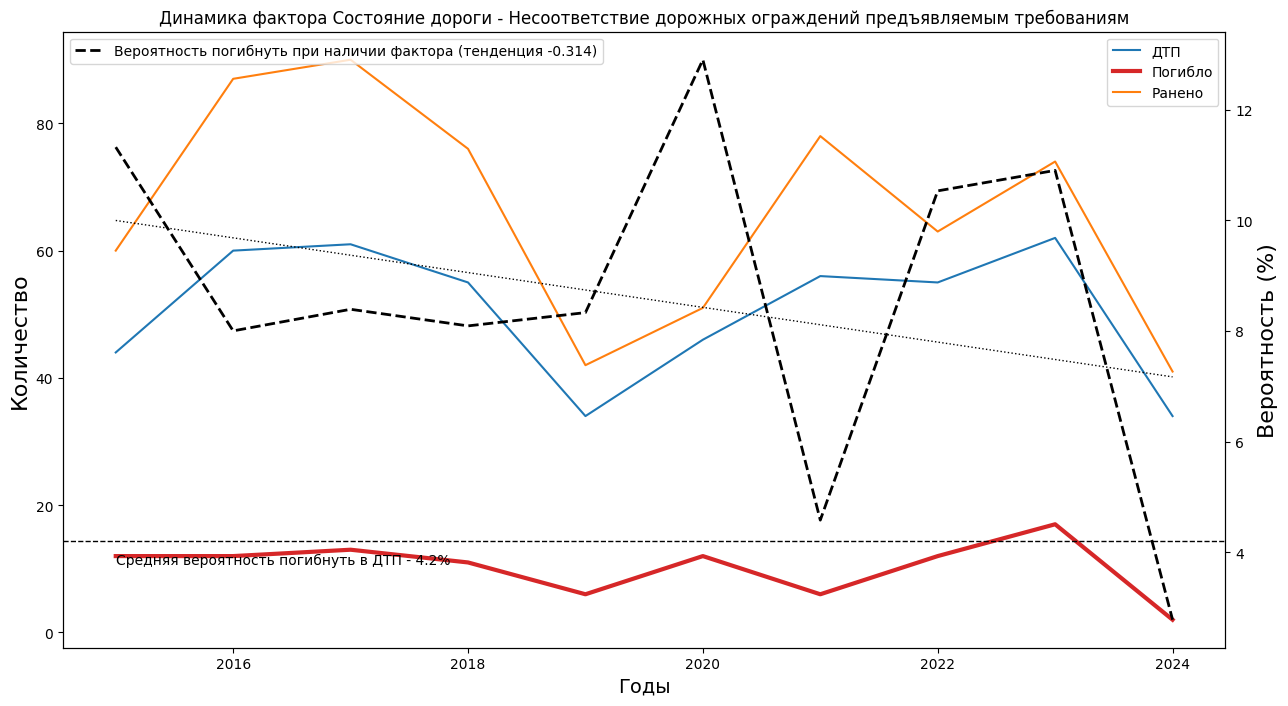

In [ ]:
for i in range(0, len(top_dead_factors)):
    if (top_dead_factors.loc[i, 'zkrit_dead'] < 0.05) & (top_dead_factors.loc[i, 'dead_count'] > 100):
        col = top_dead_factors.loc[i, 'type']
        fact = top_dead_factors.loc[i, 'factor']
        q_str = col + '.str.contains("' + fact + '", regex = False)'
        dd = data.query( q_str).groupby('year')\
            .agg({'dtp_id': 'count', 'dead_count' : 'sum', 'injured_count' : 'sum', 'participants_count' : 'sum'})

        if len(dd) > 5:
            factor_dynamics(dd, col, fact)
    if i > 5: break


## *Транспортные средства, участвовавшие в ДТП, как фактор повышенной вероятности смертельных ДТП*

In [ ]:
group_car_cat = {'Легковые', 'Автобусы', 'грузовые', 'спецтехн'}

In [ ]:
%%time
cars_all = cars_factors('brand')
#cars_all = pd.concat([cars_all, cars_factors('model')])
cars_all = pd.concat([cars_all, cars_factors('category')])
cars_all = cars_all.reset_index(drop = True)

CPU times: user 1min 40s, sys: 259 ms, total: 1min 40s
Wall time: 1min 42s


In [ ]:
cars_all['dtp_per'] = round(100 * cars_all['dtp_count'] / all_dtp_count, 2)
cars_all['injured_per'] = round(100 * cars_all['injured_count'] / all_injured_count, 2)
cars_all['dead_per'] = round(100 * cars_all['dead_count'] / all_dead_count, 2)
cars_all['dead_p'] = round(100 *cars_all['dead_count'] / cars_all['participants_count'], 2)
cars_all['injured_p'] = round(100 *cars_all['injured_count'] / cars_all['participants_count'], 2)

In [ ]:
zkrit_to_all(cars_all)

### ТОП марок и категорий ТС, попавших в ДТП, по вероятности смертельного ДТП

Рассматриваются все ТС, участвовавшие в ДТП, как бы в сумме для всех участников ДТП

In [ ]:
top_dead_cars = cars_all[(cars_all['dtp_count'] > 100) & (cars_all['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop=True)

factor_dead_table(top_dead_cars[['factor', 'type', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

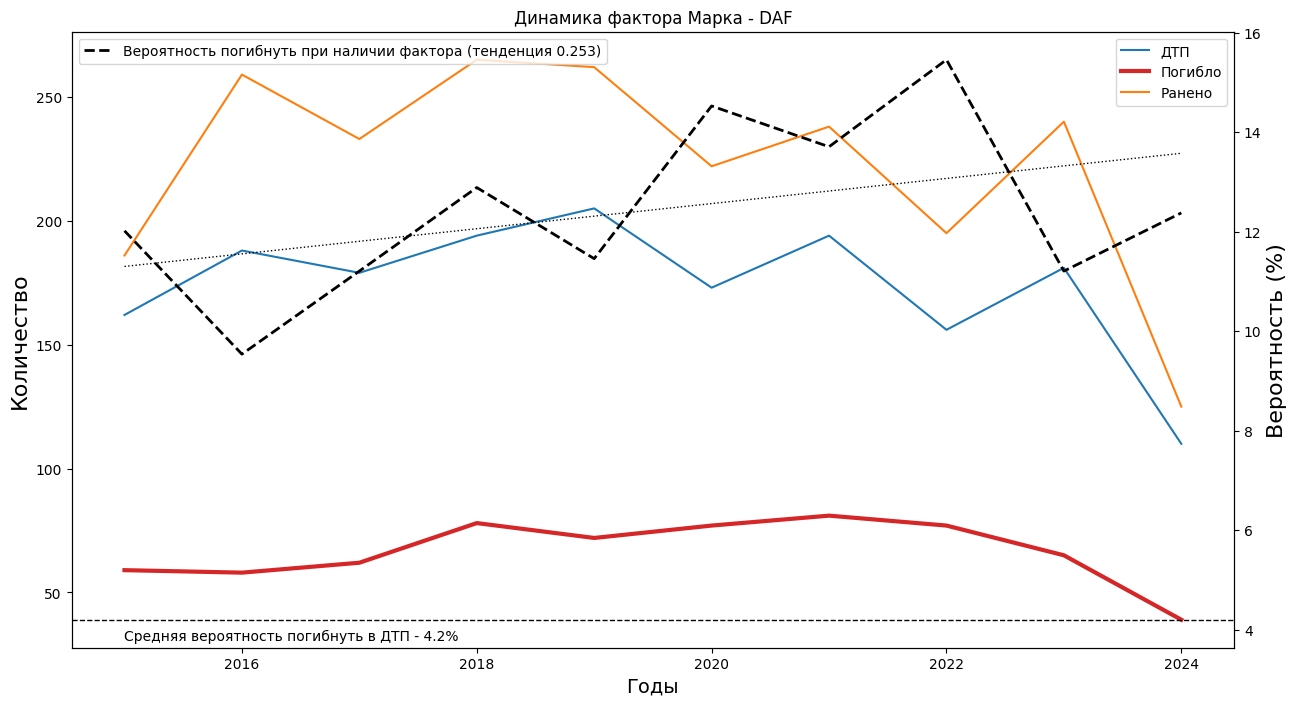

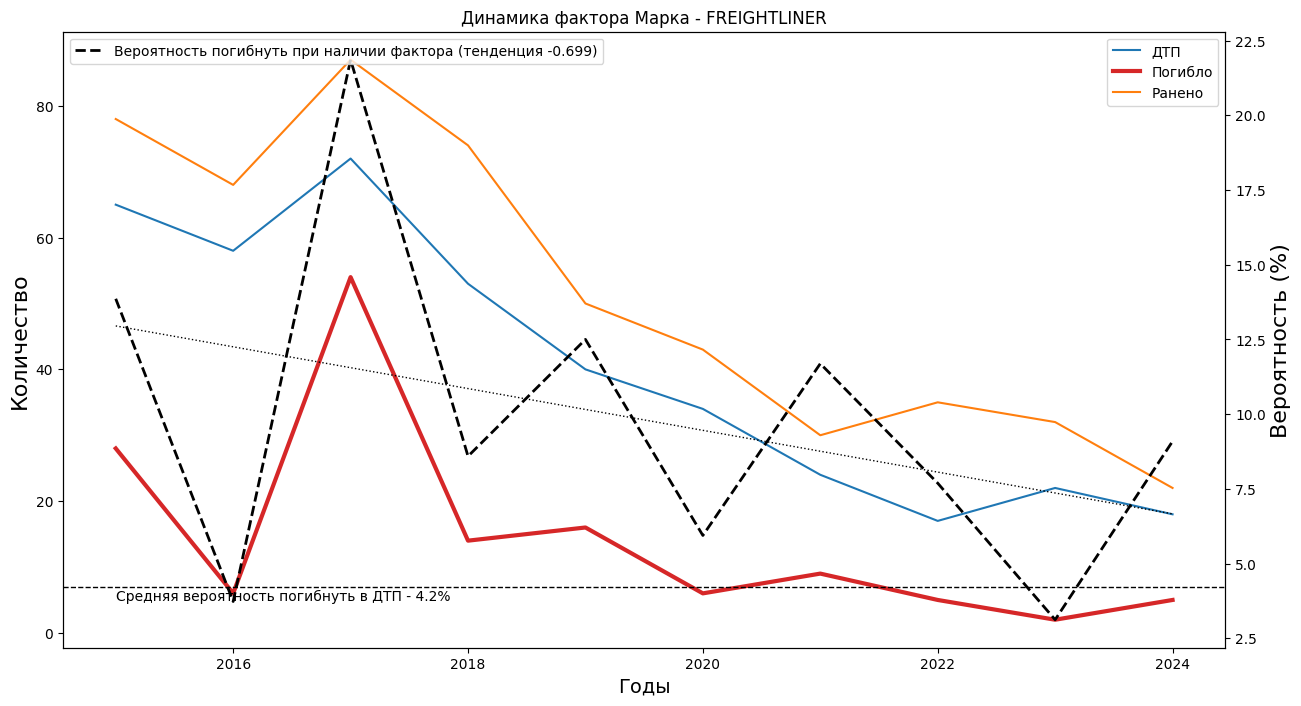

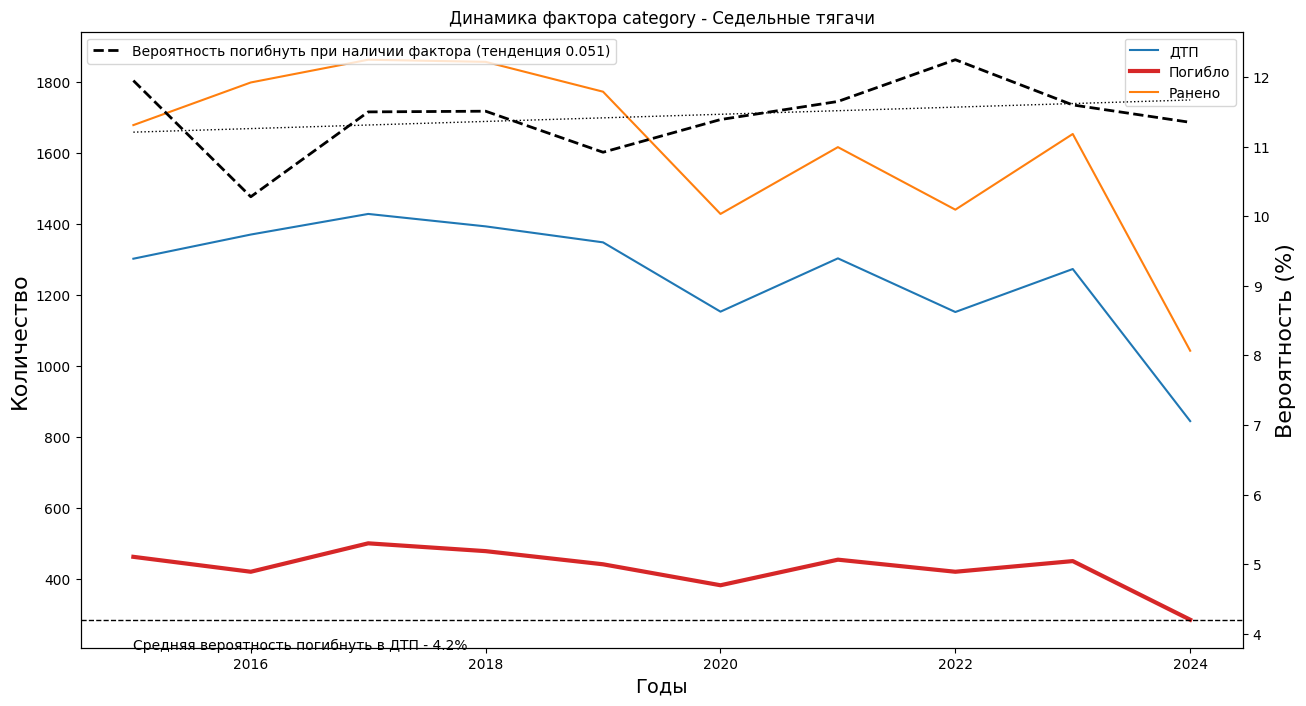

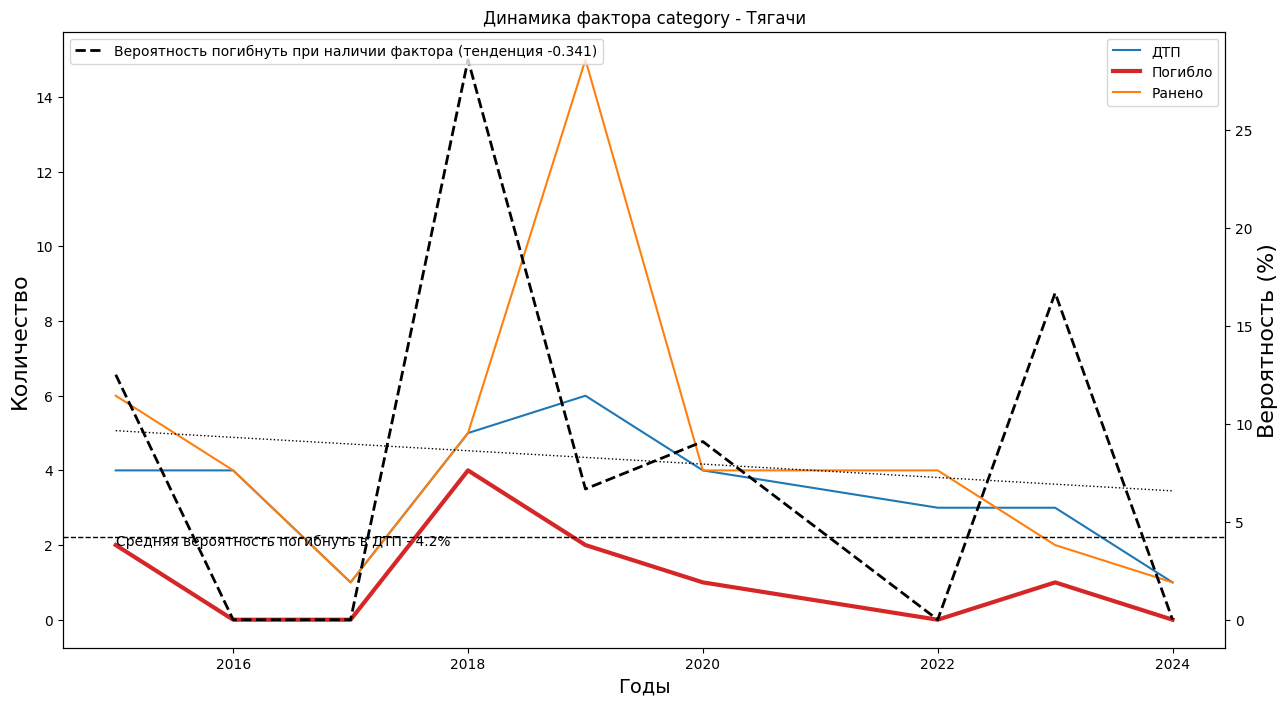

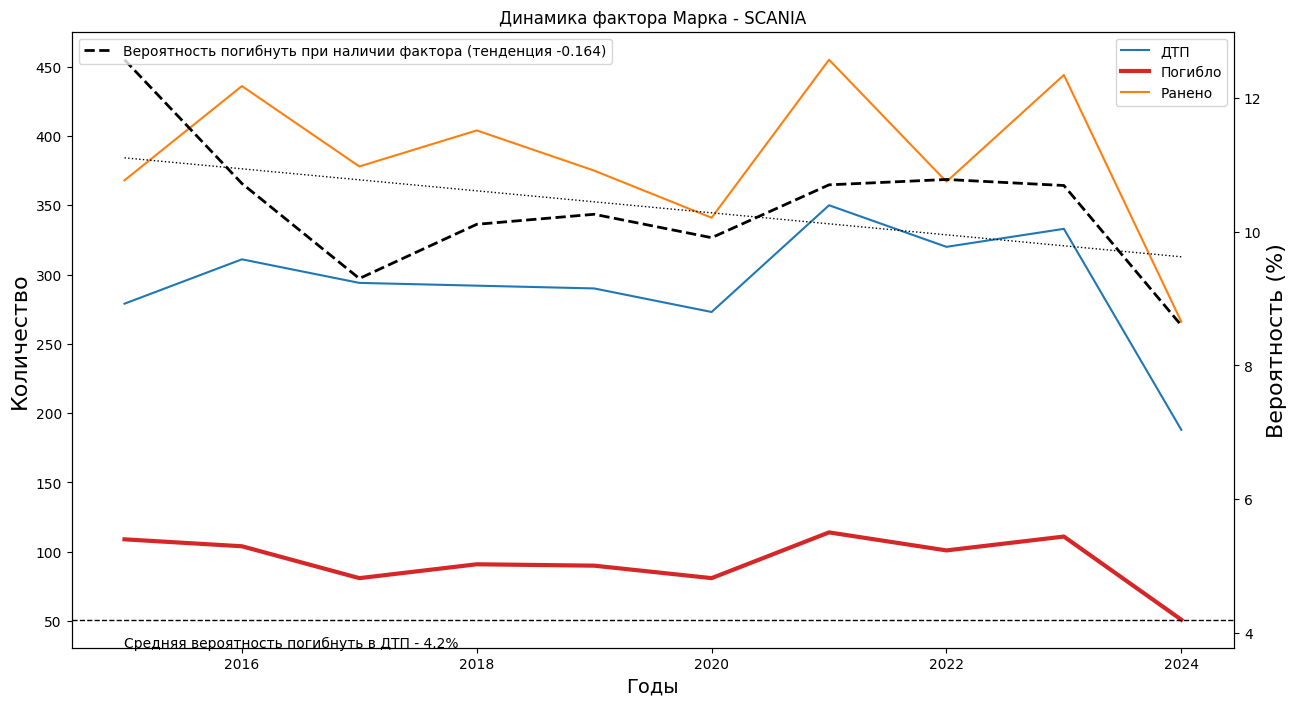

In [ ]:
for i in range(0, len(top_dead_cars)):
    if (top_dead_cars.loc[i, 'zkrit_dead'] < 0.05) & (top_dead_cars.loc[i, 'dead_count'] > 100):
        col = top_dead_cars.loc[i, 'type']
        fact = top_dead_cars.loc[i, 'factor']
        q_str = col + '.str.contains("' + fact + '", regex = False)'
        dd = data[data['dtp_id'].isin(cars.query(q_str)['dtp_id'])].groupby('year')\
            .agg({'dtp_id': 'count', 'dead_count' : 'sum', 'injured_count' : 'sum', 'participants_count' : 'sum'})
        if len(dd) > 5:
            factor_dynamics(dd, col, fact)
    if i > 5: break


### Категории ТС, для водителей и пассажиров которых вероятность погибгнуть в ДТП - выше среднего

Рассматривается связь ТС, попавших в ДТП, и только участников, находившихся внутри

In [ ]:
dead_cat = cars.groupby('category', as_index = False).agg({'car_id': 'count', 'dtp_id' : 'nunique'}).sort_values(by='car_id', ascending = False)

In [ ]:
group_car_cat = ('Легковые', 'Автобусы', 'грузовые', 'спецтехн')
dead_cat.reset_index(drop = True)
for gr in group_car_cat:
    gg = cars.query('category.str.contains(@gr)').agg({'car_id': 'count', 'dtp_id' : 'nunique'})
    dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]

<ipython-input-112-e1da6e8c7dd8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]
<ipython-input-112-e1da6e8c7dd8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]
<ipython-input-112-e1da6e8c7dd8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dead_cat.loc[len(dead_cat)] = [gr, gg[0], gg[1]]
<ipython-input-112-e1da6e8c7dd8>:5: FutureW

In [ ]:
%%time
for i in range(0, len(dead_cat)):
    mdl = dead_cat.loc[i, 'category']

    cars_in_seg = set(cars[cars['category'].str.contains(mdl, regex=False)]['car_id'].unique())
    partic_in_cars_seg = set(partic[partic['car_id'].isin(cars_in_seg)]['partic_id'].unique())
    injured_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Пострадал", regex=False)')['partic_id'].nunique()
    daed_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Погиб", regex=False)')['partic_id'].nunique()

    dead_cat.loc[i, 'participants_count'] = len(partic_in_cars_seg)
    dead_cat.loc[i, 'injured_count'] = injured_in_cars_seg
    dead_cat.loc[i, 'dead_count'] = daed_in_cars_seg

CPU times: user 1min 17s, sys: 154 ms, total: 1min 18s
Wall time: 1min 18s


In [ ]:
dead_cat.columns = ['category', 'cars_count', 'dtp_count', 'participants_count', 'injured_count', 'dead_count']
#dead_cat['type'] = 'category'
dead_cat['dead_p'] = round(100 * dead_cat['dead_count'] / dead_cat['participants_count'], 2)
dead_cat['dtp_per'] = round(100 * dead_cat['dtp_count'] / all_dtp_count, 2)
dead_cat['dead_per'] = round(100 * dead_cat['dead_count'] / all_dead_count, 2)
dead_cat['injured_per'] = round(100 * dead_cat['injured_count'] / all_injured_count, 2)

In [ ]:
zkrit_to_all(dead_cat)

In [ ]:
top_dead_cat = dead_cat[
                        (dead_cat['dtp_count'] > 100)
                        & (dead_cat['dead_p'] > dead_p)
                        #& (dead_cat['zkrit_dead'] < 0.05)
                       ]\
        .sort_values(by='dead_p', ascending = False).head(30).reset_index(drop=True)

factor_dead_table(top_dead_cat[['category', 'cars_count', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

### Марки ТС, для водителей и пассажиров которых вероятность погибнуть в ДТП - выше среднего

In [ ]:
dead_brand = cars.groupby('brand', as_index = False).agg({'category' : 'first', 'car_id': 'count', 'dtp_id' : 'nunique'}).sort_values(by='car_id', ascending = False)

In [ ]:
%%time
for i in range(0, len(dead_brand)):
    mdl = dead_brand.loc[i, 'brand']

    cars_in_seg = set(cars[cars['brand'].str.contains(mdl, regex=False)]['car_id'].unique())
    partic_in_cars_seg = set(partic[partic['car_id'].isin(cars_in_seg)]['partic_id'].unique())
    injured_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Пострадал", regex=False)')['partic_id'].nunique()
    daed_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Погиб", regex=False)')['partic_id'].nunique()

    dead_brand.loc[i, 'participants_count'] = len(partic_in_cars_seg)
    dead_brand.loc[i, 'injured_count'] = injured_in_cars_seg
    dead_brand.loc[i, 'dead_count'] = daed_in_cars_seg

CPU times: user 3min 59s, sys: 407 ms, total: 4min
Wall time: 4min 1s


In [ ]:
dead_brand.columns = ['brand','category', 'cars_count', 'dtp_count', 'participants_count', 'injured_count', 'dead_count']
dead_brand['dead_p'] = round(100 * dead_brand['dead_count'] / dead_brand['participants_count'], 2)
dead_brand['dtp_per'] = round( 100 * dead_brand['dtp_count'] / all_dtp_count, 2)
dead_brand['dead_per'] = round( 100 * dead_brand['dead_count'] / all_dead_count, 2)
dead_brand['injured_per'] = round( 100 * dead_brand['injured_count'] / all_injured_count, 2)

In [ ]:
zkrit_to_all(dead_brand)

In [ ]:
top_dead_brand = dead_brand[
                        (dead_brand['dtp_count'] > 100)
                        & (dead_brand['dead_p'] > dead_p)
                        #& (dead_brand['zkrit_dead'] < 0.05)
                       ]\
        .sort_values(by='dead_p', ascending = False).head(50)

top_dead_brand= top_dead_brand.reset_index()

factor_dead_table(top_dead_brand[['brand', 'category', 'cars_count', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])


### Модели  ТС, для водителей и пассажиров которых вероятность погибнуть в ДТП - выше среднего

In [ ]:
dead_model = cars.groupby('model', as_index = False).agg({'category' : 'first', 'brand' : 'first', 'car_id': 'count', 'dtp_id' : 'nunique'}).sort_values(by='car_id', ascending = False)
dead_model = dead_model[dead_model['dtp_id'] > 100]
dead_model = dead_model.reset_index(drop=True)

In [ ]:
%%time
for i in range(0, len(dead_model)):
    mdl = dead_model.loc[i, 'model']

    cars_in_seg = set(cars[cars['model'].str.contains(mdl, regex=False)]['car_id'].unique())
    partic_in_cars_seg = set(partic[partic['car_id'].isin(cars_in_seg)]['partic_id'].unique())
    injured_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Пострадал", regex=False)')['partic_id'].nunique()
    daed_in_cars_seg = partic.query('car_id.isin(@cars_in_seg) & result.str.contains("Погиб", regex=False)')['partic_id'].nunique()

    dead_model.loc[i, 'participants_count'] = len(partic_in_cars_seg)
    dead_model.loc[i, 'injured_count'] = injured_in_cars_seg
    dead_model.loc[i, 'dead_count'] = daed_in_cars_seg

CPU times: user 3min 28s, sys: 326 ms, total: 3min 28s
Wall time: 3min 29s


In [ ]:
dead_model.columns = ['model', 'category', 'brand', 'cars_count', 'dtp_count', 'participants_count', 'injured_count', 'dead_count']
dead_model['dead_p'] = round(100 * dead_model['dead_count'] / dead_model['participants_count'], 2)
dead_model['dtp_per'] = round(100 * dead_model['dtp_count'] / all_dtp_count, 2)
dead_model['dead_per'] = round(100 * dead_model['dead_count'] / all_dead_count, 2)
dead_model['injured_per'] = round(100 *dead_model['injured_count'] / all_injured_count, 2)

In [ ]:
zkrit_to_all(dead_model)

In [ ]:
top_dead_model = dead_model[
                        (dead_model['dtp_count'] > 100)
                        & (dead_model['dead_p'] > dead_p)
                        #& (dead_model['zkrit_dead'] < 0.05)
                       ]\
        .sort_values(by='dead_p', ascending = False).head(30).reset_index(drop=True)

factor_dead_table(top_dead_model[['model', 'brand', 'category', 'cars_count', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

## *Нарушения ПДД, роли и категории людей, попавших в ДТП, как фактор повышенной вероятности смертельного ДТП*

In [ ]:
group_violat = ('скорост', 'ремней', 'опьянения', 'перекрестк', 'Неожидан', 'пешеход', 'велосипед', 'неисправ')

In [ ]:
%%time
partic_all = partic_factors('violations')
partic_all = pd.concat([partic_all, partic_factors('role')])
#partic_all = pd.concat([partic_all, partic_factors('years_of_driving_experience')])
partic_all = pd.concat([partic_all, factors('participant_categories')])
partic_all = partic_all.reset_index(drop=True)

CPU times: user 1min 2s, sys: 115 ms, total: 1min 2s
Wall time: 1min 3s


In [ ]:
partic_all['dtp_per'] = round(100 * partic_all['dtp_count'] / all_dtp_count, 2)
partic_all['injured_per'] = round(100 * partic_all['injured_count'] / all_injured_count, 2)
partic_all['dead_per'] = round(100 * partic_all['dead_count'] / all_dead_count, 2)
partic_all['dead_p'] = round(100 *partic_all['dead_count'] / partic_all['participants_count'], 2)
partic_all['injured_p'] = round(100 *partic_all['injured_count'] / partic_all['participants_count'], 2)

In [ ]:
zkrit_to_all(partic_all)

In [ ]:
top_partic = partic_all[(partic_all['dtp_count'] > 100) & (partic_all['dead_p'] > dead_p)]\
        .sort_values(by='dead_p', ascending=False).head(30).reset_index(drop=True)

factor_dead_table(top_partic[['factor', 'type', 'dtp_count', 'dtp_per', 'participants_count', 'dead_count', 'dead_per', 'dead_p', 'zkrit_dead']])

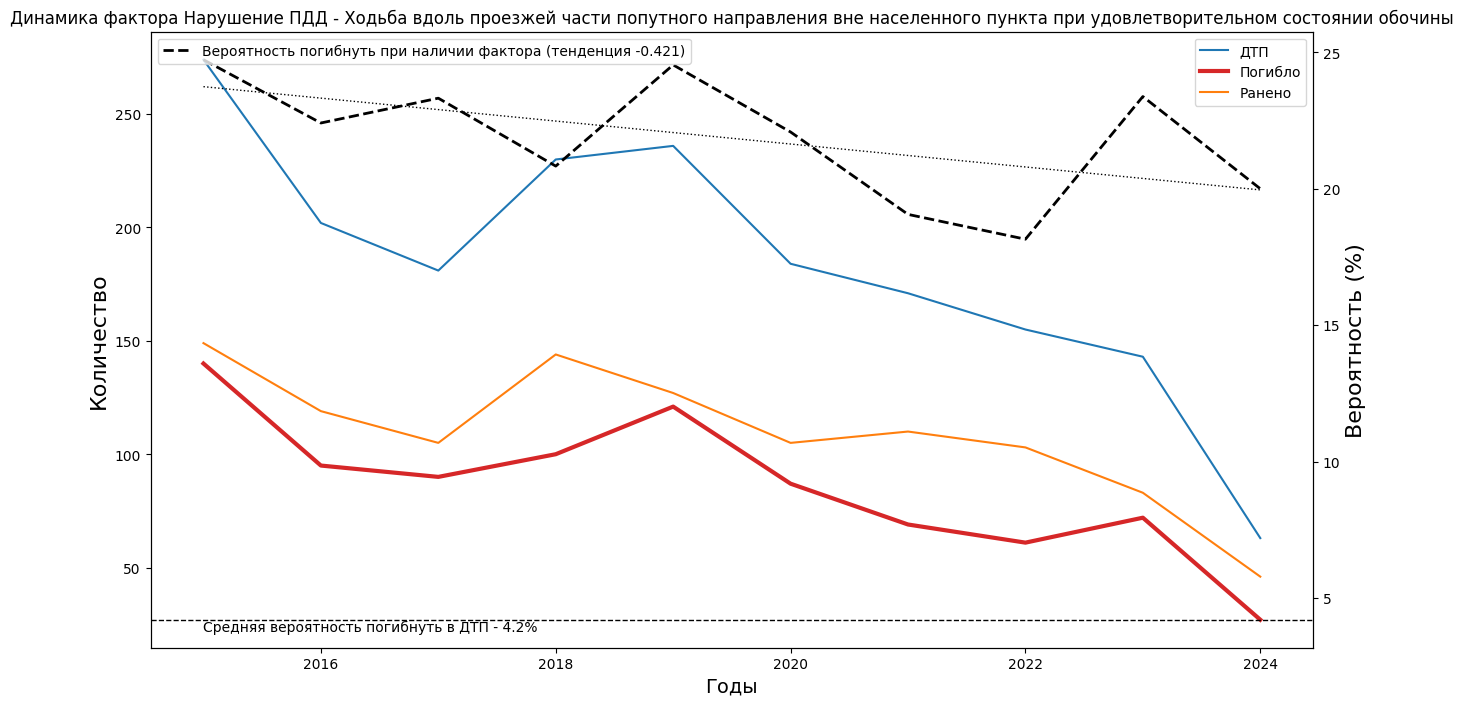

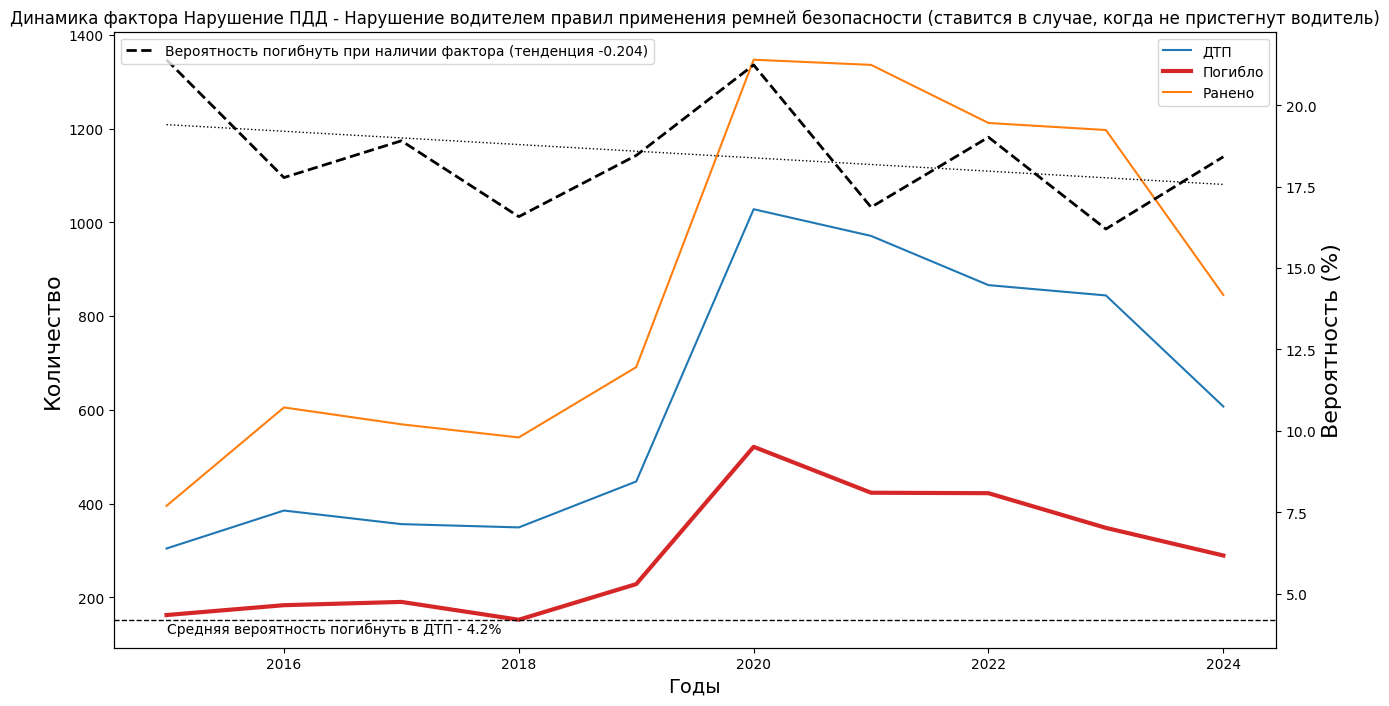

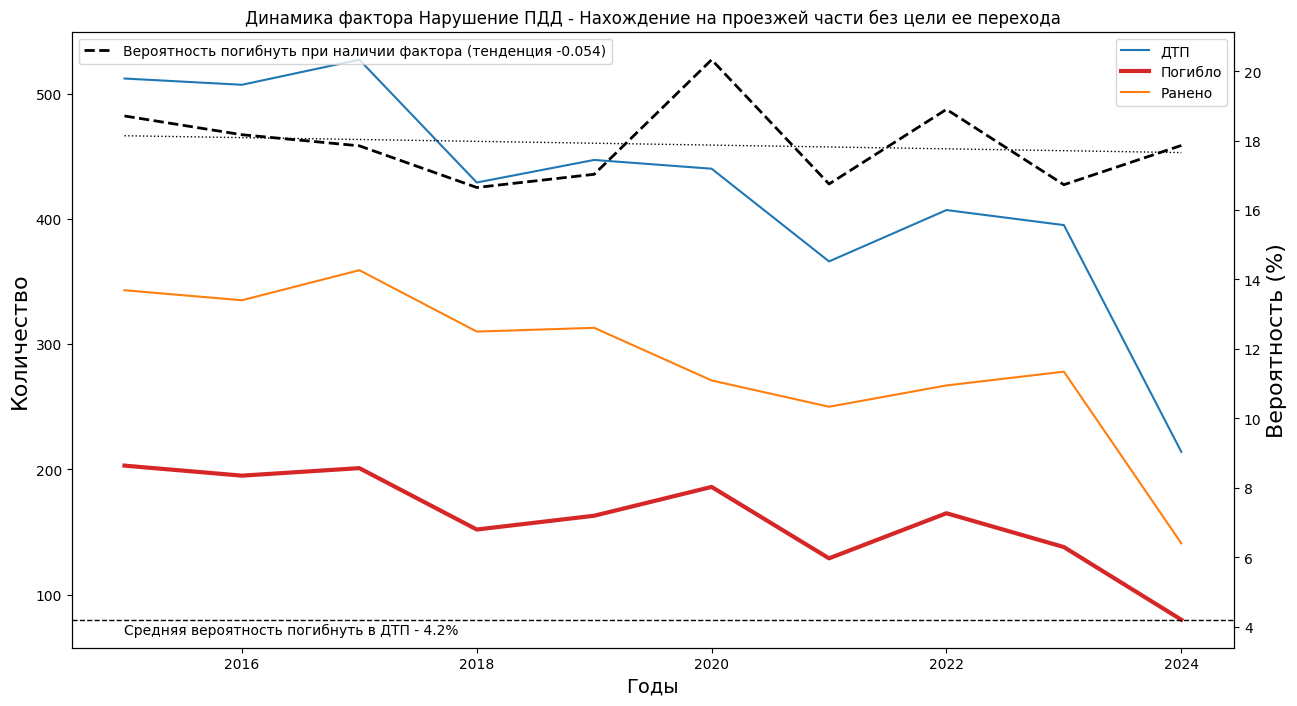

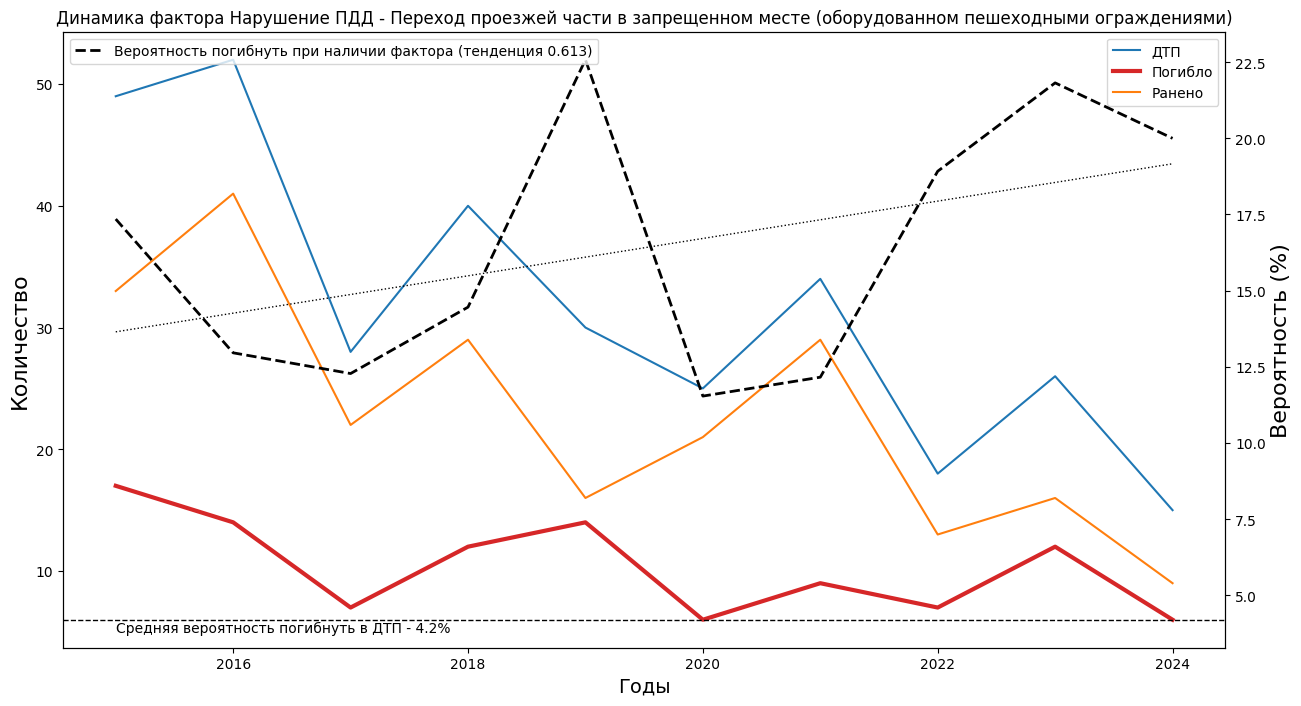

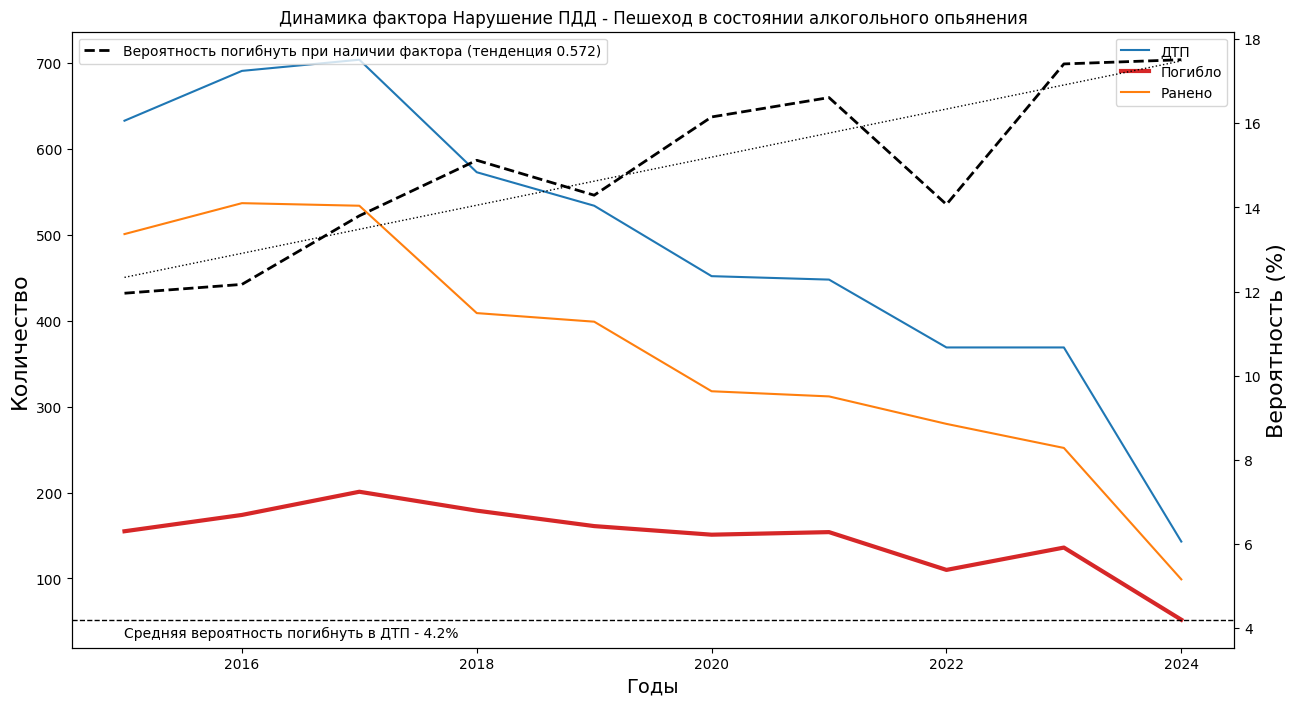

In [ ]:
for i in range(0, len(top_dead_cars)):
    if (top_partic.loc[i, 'zkrit_dead'] < 0.05) & (top_partic.loc[i, 'dead_count'] > 100):
        col = top_partic.loc[i, 'type']
        fact = top_partic.loc[i, 'factor']
        q_str = col + '.str.contains("' + fact + '", regex = False)'
        dd = data[data['dtp_id'].isin(partic.query(q_str)['dtp_id'])].groupby('year')\
            .agg({'dtp_id': 'count', 'dead_count' : 'sum', 'injured_count' : 'sum', 'participants_count' : 'sum'})
        if len(dd) > 5:
            factor_dynamics(dd, col, fact)
    if i > 5: break

### Нарушения ПДД как фактор повышенной вероятности ДТП с пострадавшими (не смертельные)

In [ ]:
partic_all[(partic_all['dtp_count'] > 100) & (partic_all['injured_p'] > injured_p)]\
        .sort_values(by='injured_p', ascending=False).head(30)\
        [['factor', 'type', 'dtp_count', 'dtp_per', 'injured_count', 'injured_per', 'injured_p', 'zkrit_injured']]\
        .style.apply(highlight_stat, subset='zkrit_injured')\
        .format({'dtp_count': '{:.0f}'.format, 'dtp_per': '{:,.2f}'.format, 'injured_count': '{:.0f}'.format, 'injured_per': '{:,.2f}'.format, 'injured_p': '{:,.2f}'.format, 'zkrit_injured': '{:.4f}'.format})

# **Проверка гипотез**

## *Среди пешеходов, попавших в ДТП, одинакова доля мужчин и женщин*


In [ ]:
mendtp = partic.query('role == "Пешеход" & gender == "Мужской"')['dtp_id']
womendtp = partic.query('role == "Пешеход" & gender == "Женский"')['dtp_id']

In [ ]:
mendtp_dtp_by_month = data[data['dtp_id'].isin(mendtp)].groupby(['year','month']).agg({'dtp_id': 'count'})
womendtp_dtp_by_month = data[data['dtp_id'].isin(womendtp)].groupby(['year','month']).agg({'dtp_id': 'count'})

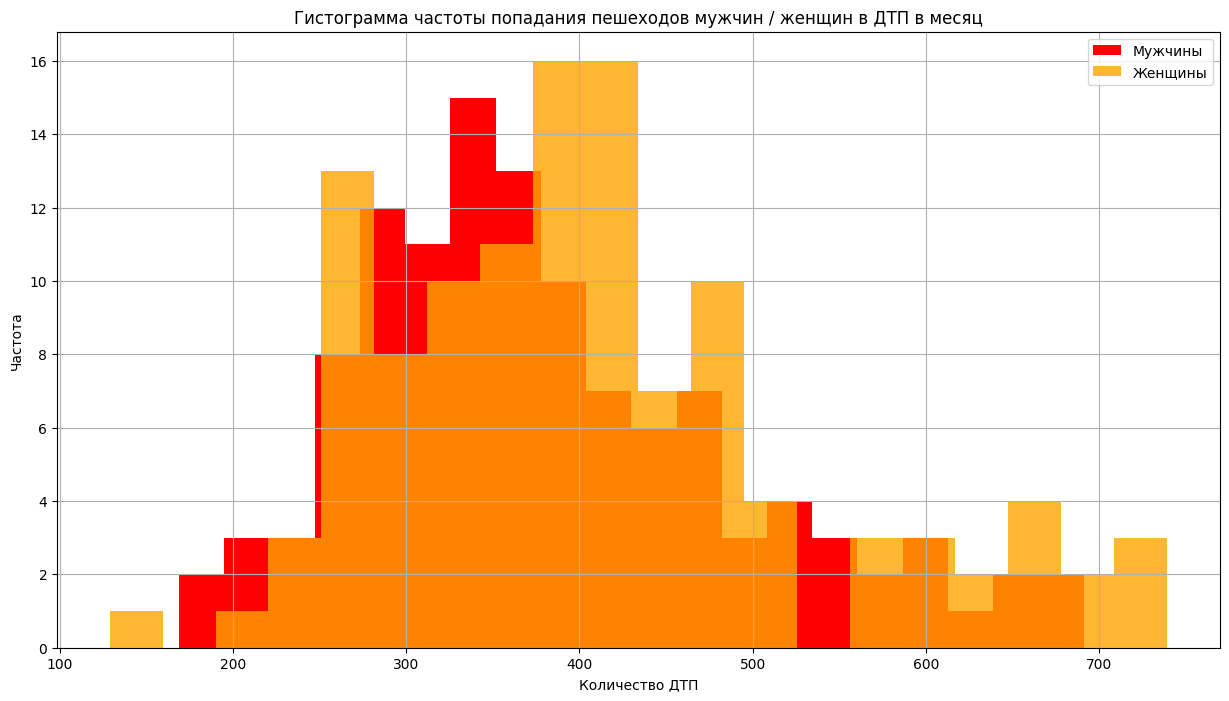

In [ ]:
plt.figure(figsize=(15,8))

mendtp_dtp_by_month['dtp_id'].hist(bins = 20, color = 'red', label = 'Мужчины')
womendtp_dtp_by_month['dtp_id'].hist(bins = 20, alpha = 0.8, color = 'orange', label = 'Женщины')
plt.title('Гистограмма частоты попадания пешеходов мужчин / женщин в ДТП в месяц')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()

In [ ]:
test_selection(
    womendtp_dtp_by_month['dtp_id'], mendtp_dtp_by_month['dtp_id'],
    side='greater',
    h0 = 'Гендерное разделение пешеходов, попавших в ДТП - одинаково',
    h1 = 'Средии пешеходов, попавших в ДТП, больше женщин')

Первая выборка НЕ прошла проверку на нормальное распределение. pval = 0.0044704475078481305
Вторая выборка НЕ прошла проверку на нормальное распределение. pval = 0.005073453553636699
Дисперсии выборок близки. pval = 0.33153733157706355. Применяем equal_var=True 

Выборки имеют размер > 30, либо нормально распределены можно применить ttest
--- Проводим TTest ---
В результате теста получено p-value 0.0407376324786856
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Средии пешеходов, попавших в ДТП, больше женщин 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.041937793273156485
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Средии пешеходов, попавших в ДТП, больше женщин 


## *Пьяных ДТП меньше, но они тяжелее по последствиям*

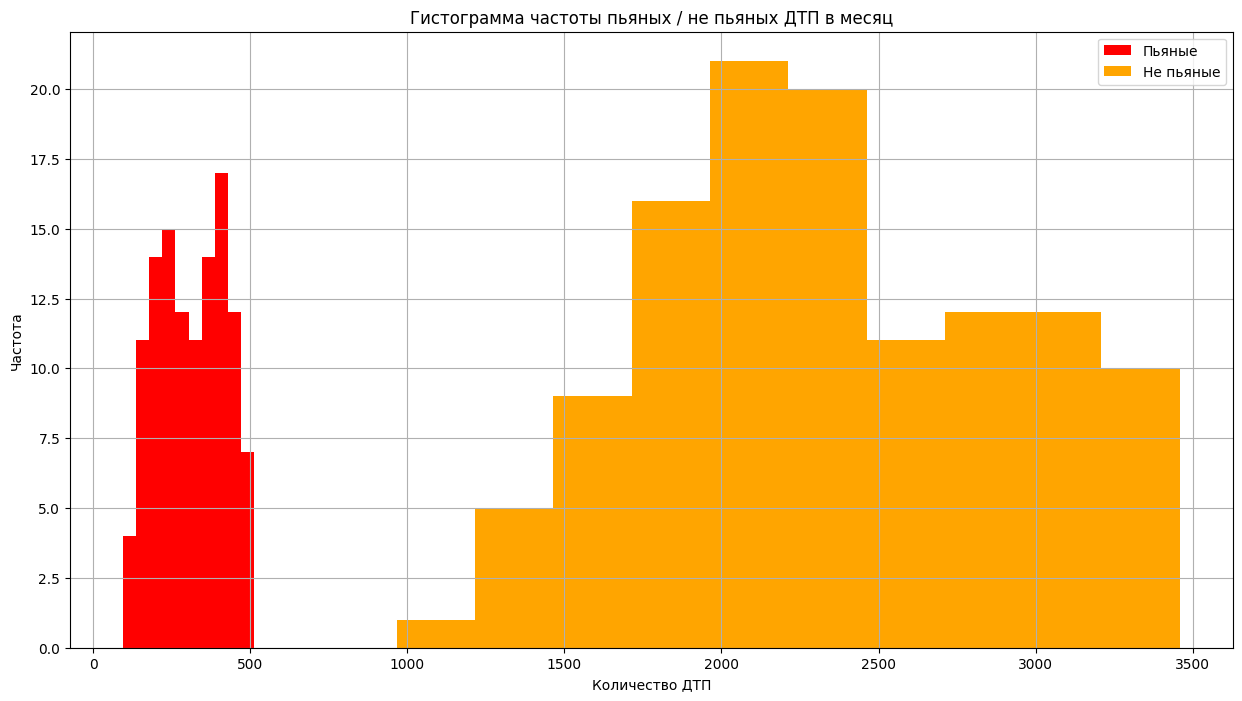

In [ ]:
plt.figure(figsize=(15,8))

alco_dtp_by_month['dtp_count'].hist(bins = 10, color = 'red', label = 'Пьяные')
notalco_dtp_by_month['dtp_count'].hist(bins = 10, color = 'orange', label = 'Не пьяные')
plt.title('Гистограмма частоты пьяных / не пьяных ДТП в месяц')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()

Анализ показывает, что количество обычных ДТП больше, чем пьяных. Проверим это статистическими методами.
Проверим распределение на нормальность и равенство дисперсий


Нулевая гипотеза, что обычных и пьяных ДТП одинакого, альтернитивная - что обычных БОЛЬШЕ.

In [ ]:
test_selection(
    notalco_dtp_by_month['dtp_count'], alco_dtp_by_month['dtp_count'],
    side='greater',
    h0 = 'Количество обычных и пьяных ДТП одинакого',
    h1 = 'Обычных ДТП больше, чем пьяных')

Первая выборка прошла проверку на нормальное распределение. pval = 0.05723102844234958
Вторая выборка НЕ прошла проверку на нормальное распределение. pval = 4.3313526416515955e-06
Дисперсии выборок НЕ близки. pval = 1.0412586020223882e-26. Применяем equal_var=False

Выборки имеют размер > 30, либо нормально распределены можно применить ttest
--- Проводим TTest ---
В результате теста получено p-value 5.343723850056202e-71
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Обычных ДТП больше, чем пьяных 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 3.4301205870583373e-40
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Обычных ДТП больше, чем пьяных 


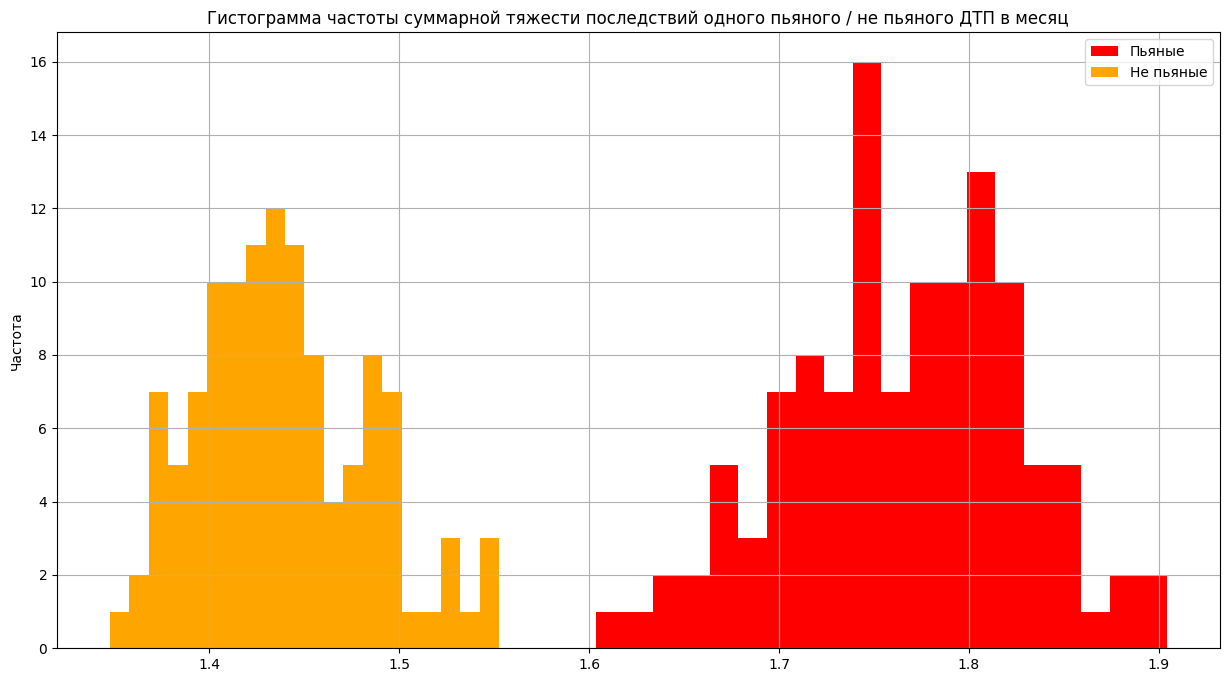

In [ ]:
plt.figure(figsize=(15,8))
alco_dtp_by_month['severity_1dtp'].hist(bins = 20, color = 'red', label = 'Пьяные')
notalco_dtp_by_month['severity_1dtp'].hist(bins = 20, color = 'orange', label = 'Не пьяные')
plt.title('Гистограмма частоты суммарной тяжести последствий одного пьяного / не пьяного ДТП в месяц')
plt.ylabel('Частота')
plt.legend()
plt.show()


Нулевая гипотеза, что у обычных и пьяных ДТП тяжесть последствий одинакова, альтернитивная - что у пьяных ДТП тяжесть последствий БОЛЬШЕ.

In [ ]:
test_selection(
    alco_dtp_by_month['severity_1dtp'], notalco_dtp_by_month['severity_1dtp'],
    side='greater',
    h0 = 'У обычных и пьяных ДТП тяжесть последствий одинакова',
    h1 = 'У пьяных ДТП тяжесть последствий БОЛЬШЕ')

Первая выборка прошла проверку на нормальное распределение. pval = 0.6207336493922464
Вторая выборка прошла проверку на нормальное распределение. pval = 0.13575942120135495
Дисперсии выборок НЕ близки. pval = 0.0018246186823274598. Применяем equal_var=False

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, либо нормально распределены можно применить ttest
--- Проводим TTest ---
В результате теста получено p-value 1.1160664389955207e-115
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У пьяных ДТП тяжесть последствий БОЛЬШЕ 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 3.4326617996723836e-40
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У пьяных ДТП тяжесть последствий БОЛЬШЕ 


## *Что опаснее дождь или снегопад?*

В топе факторов также встречаются погодные факторы Дождь и Снегопад. Интересно, что из них опаснее? Оценим по сумме тяжести последствий

In [ ]:
snow_rain_dtp = data.query('weather == "Дождь"').groupby(['year'], as_index = False)['severity_id'].sum()
snow_rain_dtp['snow'] = data.query('weather == "Снегопад"').groupby(['year'], as_index = False)['severity_id'].sum()['severity_id']
snow_rain_dtp = snow_rain_dtp.rename(columns={'severity_id':'rain'})

<Figure size 1200x800 with 0 Axes>

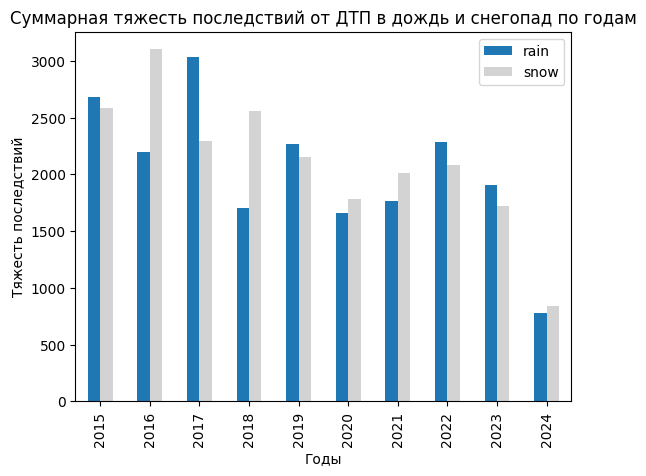

In [ ]:
plt.figure(figsize=(12,8))
snow_rain_dtp.set_index('year')[['rain', 'snow']].plot.bar(color = ['tab:blue', 'lightgrey'])
plt.title('Суммарная тяжесть последствий от ДТП в дождь и снегопад по годам')
plt.ylabel('Тяжесть последствий')
plt.xlabel('Годы')
plt.show()

In [ ]:
test_selection(
    snow_rain_dtp['snow'], snow_rain_dtp['rain'],
    side='greater',
    h0 = 'Дождь и снегопад одинаково опасны по тяжести последствий',
    h1 = 'В снегопад ДТП происходит более тяжкие ДТП')

Первая выборка прошла проверку на нормальное распределение. pval = 0.3136267504904607
Вторая выборка прошла проверку на нормальное распределение. pval = 0.5300269948120713
Дисперсии выборок близки. pval = 0.829871269626068. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
--- Проводим TTest ---
В результате теста получено p-value 0.3788430133406993
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3115881119410587
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


Выборки маловаты для ttestа и Mann-Whitneyu =(

Применим тест ANOVA, тем более, что выборки имеют нормальное распределение.

In [ ]:
pval = stats.f_oneway(snow_rain_dtp['snow'], snow_rain_dtp['rain'])[1]
pval_print(pval,
           h0='Дождь и снегопад одинаково опасны по тяжести последствий',
           h1='В снегопад ДТП происходит более тяжкие ДТП')

В результате теста получено p-value 0.757686026681397
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 


Ну или просто увеличим выборку за счет разбивки на области

In [ ]:
snow_rain_dtp_big = data.query('weather == "Дождь"').groupby(['year', 'oblast'], as_index = False)['severity_id'].sum()
snow_rain_dtp_big['snow'] = data.query('weather == "Снегопад"').groupby(['year', 'oblast'], as_index = False)['severity_id'].sum()['severity_id']
snow_rain_dtp_big = snow_rain_dtp_big.rename(columns={'severity_id':'rain'})

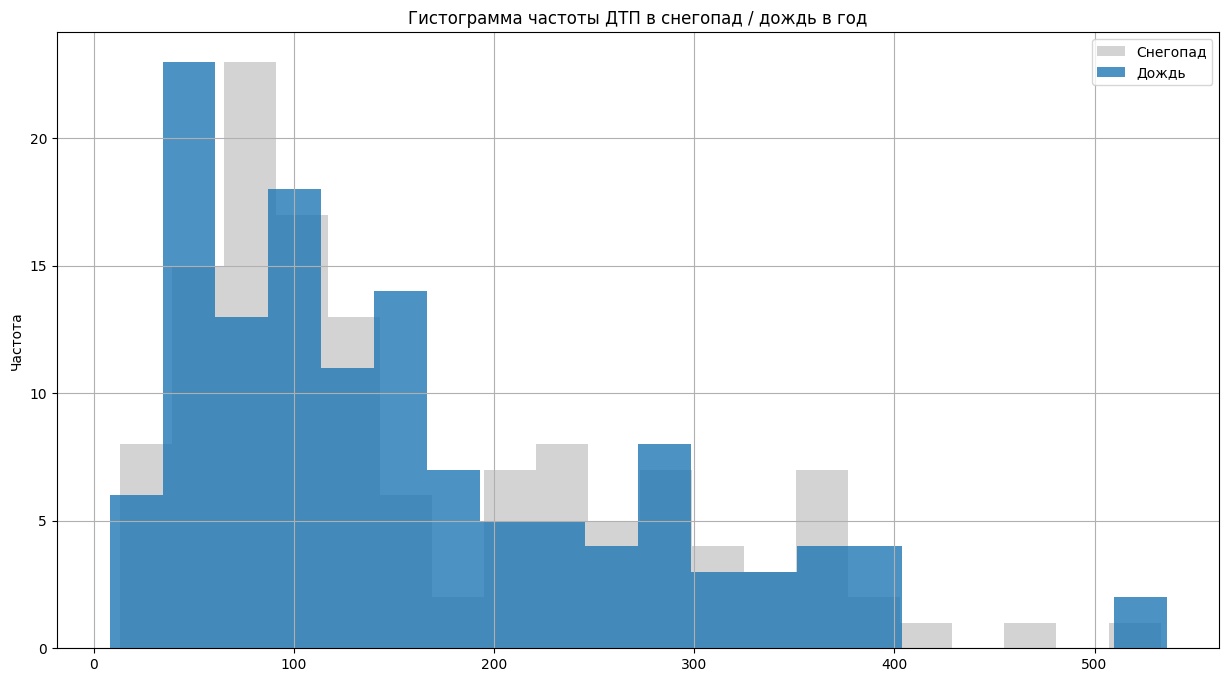

In [ ]:
plt.figure(figsize=(15,8))

snow_rain_dtp_big['snow'].hist(bins = 20, color = 'lightgrey', label = 'Снегопад')
snow_rain_dtp_big['rain'].hist(bins = 20, alpha = 0.8, color = 'tab:blue', label = 'Дождь')
plt.title('Гистограмма частоты ДТП в снегопад / дождь в год')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [ ]:
test_selection(
    snow_rain_dtp_big['snow'], snow_rain_dtp_big['rain'],
    side='greater',
    h0 = 'Дождь и снегопад одинаково опасны по тяжести последствий',
    h1 = 'В снегопад ДТП происходит более тяжкие ДТП')

Первая выборка НЕ прошла проверку на нормальное распределение. pval = 0.00043956501217889835
Вторая выборка НЕ прошла проверку на нормальное распределение. pval = 1.7588333808914838e-05
Дисперсии выборок близки. pval = 0.7702853653098948. Применяем equal_var=True 

Выборки имеют размер > 30, либо нормально распределены можно применить ttest
--- Проводим TTest ---
В результате теста получено p-value 0.31587976117038796
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.32714007818950147
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Дождь и снегопад одинаково опасны по тяжести последствий 


## *В ДТП с пешеходами кто чаще нарушает - водители или пешеходы?*

In [ ]:
walker_dtp = partic.query('role == "Пешеход"')['dtp_id']
#dead_walker_dtp = partic.query('role == "Пешеход" & result == "Погиб"')['dtp_id']
print('Всего ДТП с пешеходами', len(walker_dtp))
print('Количество водителей, у которых НЕТ нарушений', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Водитель" & violations == "Не заполнено"')))
print('Количество водитель, у которых есть нарушения', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Водитель" & violations != "Не заполнено"')))
print('Количество пешеходов, которые НЕТ нарушений', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Пешеход" & violations == "Не заполнено"')))
print('Количество пешеходов, у которые есть нарушения', len(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Пешеход" & violations != "Не заполнено"')))

Всего ДТП с пешеходами 97901
Количество водителей, у которых НЕТ нарушений 21889
Количество водитель, у которых есть нарушения 71975
Количество пешеходов, которые НЕТ нарушений 60573
Количество пешеходов, у которые есть нарушения 37328


In [ ]:
walker_dtp_violat_walker = set(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Пешеход" & violations != "Не заполнено"')['dtp_id'])
walker_dtp_violat_driver = set(partic[partic['dtp_id'].isin(walker_dtp)].query('role == "Водитель" & violations != "Не заполнено"')['dtp_id'])

In [ ]:
walker_dtp_violat_walker_ym = data[data['dtp_id'].isin(walker_dtp_violat_walker)].groupby(['year','month'], as_index=False).agg({'dtp_id': 'count'})
walker_dtp_violat_driver_ym = data[data['dtp_id'].isin(walker_dtp_violat_driver)].groupby(['year','month'], as_index=False).agg({'dtp_id': 'count'})

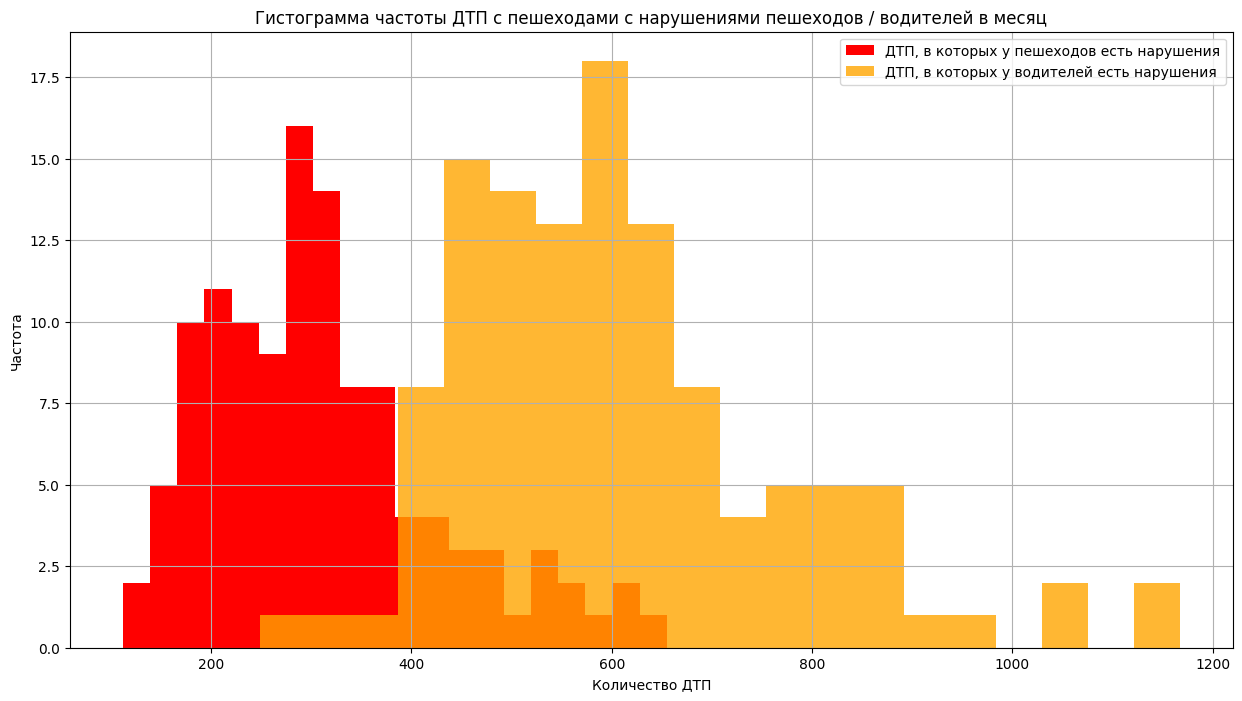

In [ ]:

plt.figure(figsize=(15,8))

walker_dtp_violat_walker_ym['dtp_id'].hist(bins = 20, alpha = 1, color = 'red', label = 'ДТП, в которых у пешеходов есть нарушения')
walker_dtp_violat_driver_ym['dtp_id'].hist(bins = 20, alpha = 0.8,  color = 'orange', label = 'ДТП, в которых у водителей есть нарушения')
plt.title('Гистограмма частоты ДТП с пешеходами с нарушениями пешеходов / водителей в месяц')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.legend()
plt.show()



Нулевая гипотеза, что у пешеходы и водители одинаково нарушают в ДТП с пешеходами, альтернитивная - что у водителей нарушений БОЛЬШЕ.

In [ ]:
test_selection(
    walker_dtp_violat_driver_ym['dtp_id'], walker_dtp_violat_walker_ym['dtp_id'],
    side='greater',
    h0 = 'Пешеходы и водители одинаково нарушают в ДТП с пешеходами',
    h1 = 'У водителей в ДТП с пешеходами нарушений БОЛЬШЕ')

Первая выборка НЕ прошла проверку на нормальное распределение. pval = 3.405419165993153e-05
Вторая выборка НЕ прошла проверку на нормальное распределение. pval = 0.000783760328426088
Дисперсии выборок НЕ близки. pval = 0.0054918181826337535. Применяем equal_var=False

Выборки имеют размер > 30, либо нормально распределены можно применить ttest
--- Проводим TTest ---
В результате теста получено p-value 5.895452900677924e-39
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У водителей в ДТП с пешеходами нарушений БОЛЬШЕ 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 5.783470743505573e-32
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У водителей в ДТП с пешеходами нарушений БОЛЬШЕ 


## *Начинающие водители чаще попападют в ДТП*

Гипотеза: В первый год начала вождения водители попадают в ДТП чаще, чем в последующие годы вождения

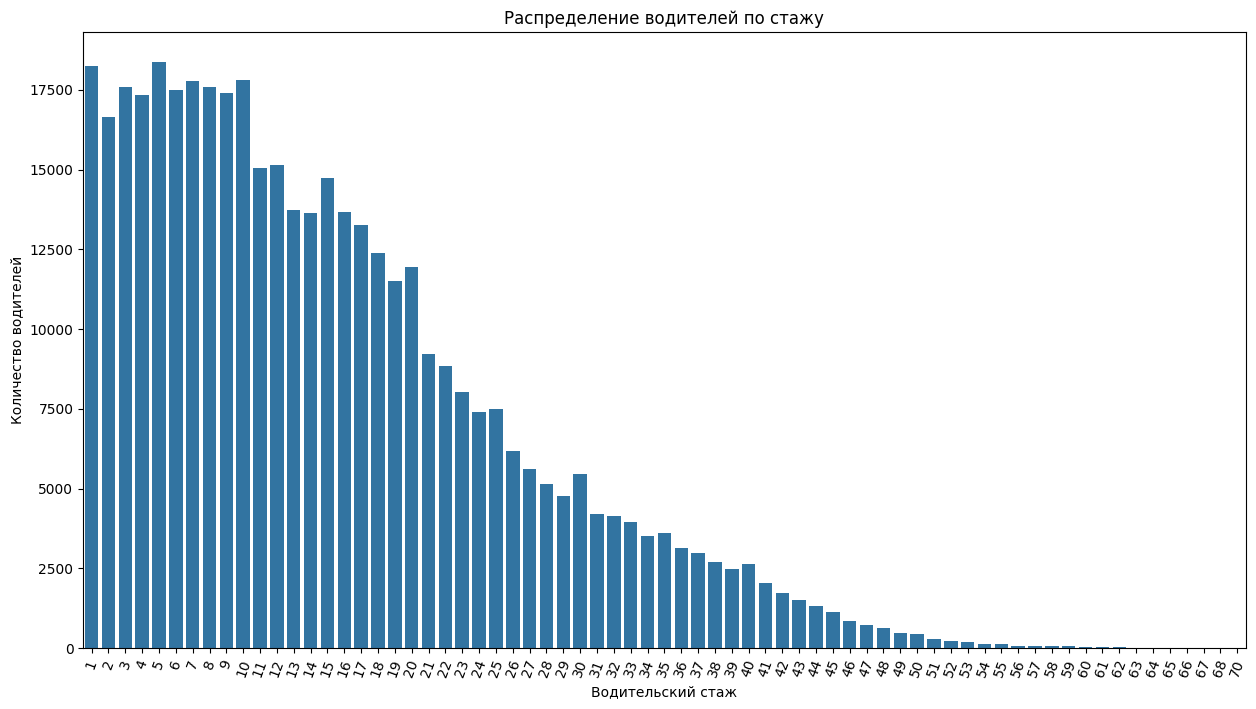

In [ ]:
plt.figure(figsize=(15,8))

dd = partic[partic['years_of_driving_experience'] > 0].groupby('years_of_driving_experience', as_index = False)['partic_id'].count()
ax = sns.barplot(x=dd['years_of_driving_experience'], y=dd['partic_id'], color='tab:blue')
plt.xticks(rotation=70)
plt.title('Распределение водителей по стажу')
plt.ylabel('Количество водителей')
plt.xlabel('Водительский стаж')
plt.show()

In [ ]:
stag_dtp_by_month = []
for y in range(1, 16):
    d = partic.query('(role == "Водитель") & (years_of_driving_experience == @y)')['dtp_id'].unique()
    stag_dtp_by_month.append(data[data['dtp_id'].isin(d)].groupby(['year','month'])['dtp_id'].count())

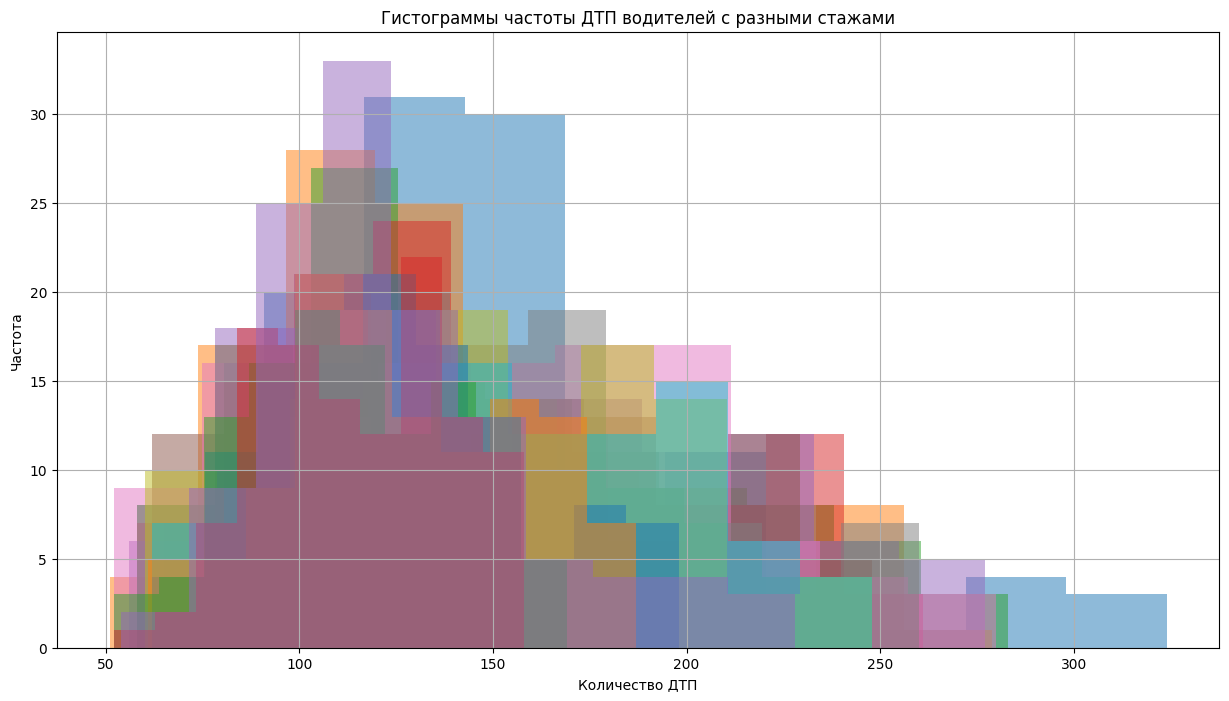

In [ ]:
plt.figure(figsize=(15,8))
for y in range(0, 15):
    stag_dtp_by_month[y].hist(bins=10, alpha = 0.5)
plt.title('Гистограммы частоты ДТП водителей с разными стажами')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.show()

Проверка на нормальное распределение. В ячейцках значения p-value для распределени года стажа.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения НЕ пройдена.

In [ ]:
stag_dtp_by_month_norm = pd.DataFrame(columns=[])
for y in range(0, 10):
        pval = stats.normaltest(stag_dtp_by_month[y])[1]
        stag_dtp_by_month_norm.loc['norm', y+1] = pval
stag_dtp_by_month_norm.style.apply(highlight_stat, color='tomato')

In [ ]:
len(stag_dtp_by_month[0])

117

Проверка на равенства дисперсий. В ячейцках значения p-value для теста сравнения выборок в год стажа по вертикали Y и в год стажа по горизонтали X.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [ ]:
stag_dtp_by_month_leneve = pd.DataFrame(columns=[])
for y1 in range(0, 10):
    for y2 in range(0, 10):
        #if y1 == y2: continue
        pval = stats.levene(stag_dtp_by_month[y1], stag_dtp_by_month[y2])[1]
        stag_dtp_by_month_leneve.loc[y1+1, y2+1] = pval
stag_dtp_by_month_leneve.style.apply(highlight_stat, color='tomato')

По парное сравнение ДТП для годов стажа. В ячейках - p-value гипозеты, что в год стажа по вертикали Y происходит столько же ДТП, сколько в год стажа по горизонтали X, альтернативная гипотеза - что ДТП происходит БОЛЬШЕ.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

На разных датасетов не всегда проходит проверка на нормальность распределения, поэтому провожу и ТТ-Тест, и тест Манн-Уитни.

Для подкрашенной ячейки читается так: в Y год стажа происходит больше ДТП, чем в X.

In [ ]:
stag_test = pd.DataFrame(columns = [])
for y1 in range(0, 10):
    for y2 in range(0, 10):
        stag_test.loc[y1+1, y2+1] = stats.ttest_ind(stag_dtp_by_month[y1], stag_dtp_by_month[y2], alternative = 'greater', equal_var=False)[1]
stag_test.style.apply(highlight_stat)

In [ ]:
stag_test_manwh = pd.DataFrame(columns = []) #
for y1 in range(0, 10):
    for y2 in range(0, 10):
        stag_test_manwh.loc[y1+1, y2+1] = stats.mannwhitneyu(stag_dtp_by_month[y1], stag_dtp_by_month[y2], alternative = 'greater')[1]
stag_test_manwh.style.apply(highlight_stat)

In [ ]:
pval = stats.f_oneway(stag_dtp_by_month[0],
                      stag_dtp_by_month[1],
                      stag_dtp_by_month[2],
                      stag_dtp_by_month[4],
                      stag_dtp_by_month[5],
                      stag_dtp_by_month[6],
                      stag_dtp_by_month[7],
                      stag_dtp_by_month[8],
                      stag_dtp_by_month[9],
                      )[1]

pval_print(pval,
           h0='Количество ДТП у водителей с разным стажем - однаково',
           h1='Количество ДТП у водителей с разным стажем - отличается')

В результате теста получено p-value 0.6287340062894862
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Количество ДТП у водителей с разным стажем - однаково 


## *Есть дни недели, в которые ДТП происходят чаще*

Гипотеза: Количество ДТП одинаково распределно по дням недели.

In [ ]:
weekday_dtp_by_month = []
for wd in range(0, 7):
    weekday_dtp_by_month.append(data[data['weekday'] == wd].groupby(['year','month'])['dtp_id'].count())

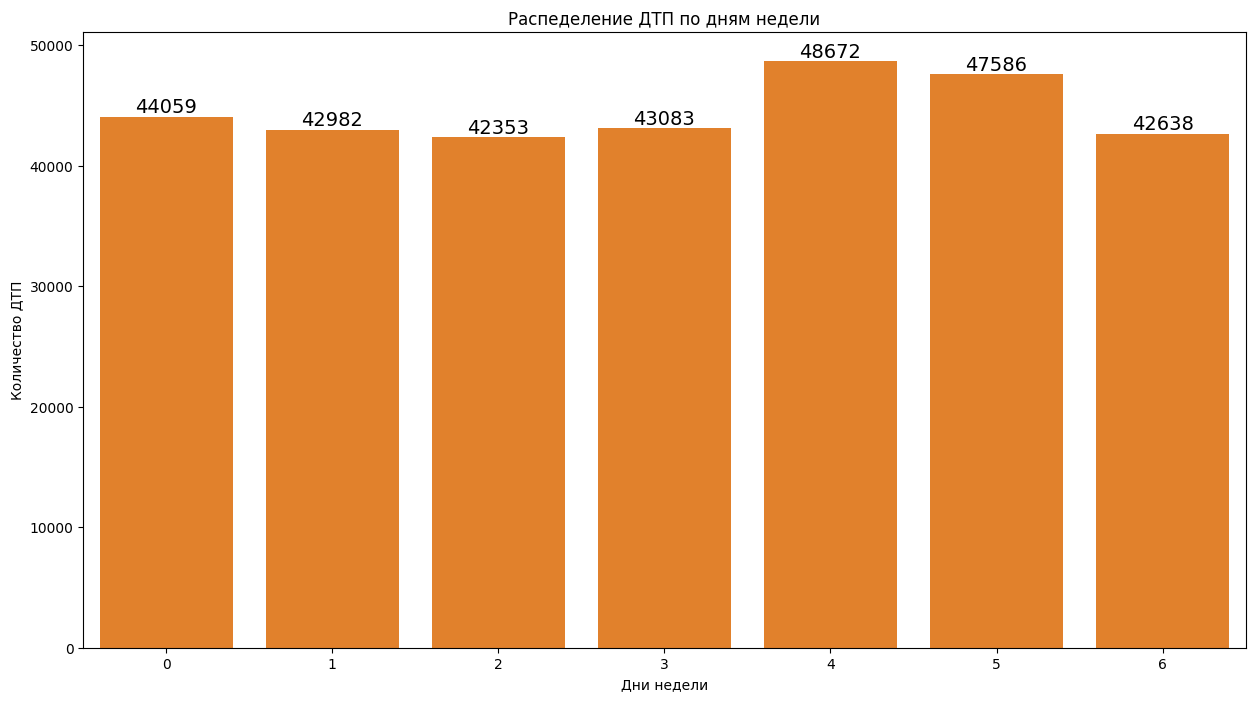

In [ ]:
plt.figure(figsize=(15,8))
dd = data.groupby('weekday', as_index=False)['dtp_id'].count().sort_values(by='weekday', ascending=False)
ax = sns.barplot(x=dd['weekday'], y=dd['dtp_id'], color='tab:orange')
ax.bar_label(ax.containers[0], fontsize=14,label_type='edge', color='black')
plt.title('Распеделение ДТП по дням недели')
plt.ylabel('Количество ДТП')
plt.xlabel('Дни недели')
plt.show()

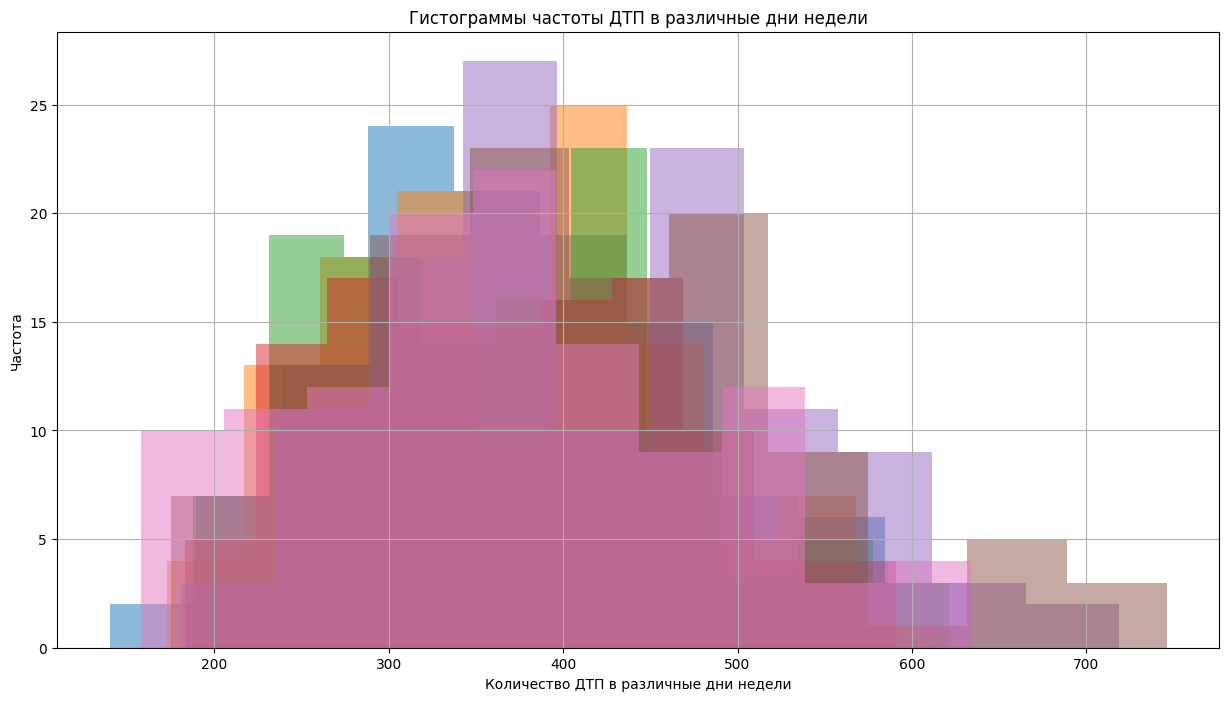

In [ ]:
plt.figure(figsize=(15,8))
for i in range(0, 7):
  weekday_dtp_by_month[i].hist(alpha = 0.5)

plt.title('Гистограммы частоты ДТП в различные дни недели')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП в различные дни недели')
plt.show()

Проверка гипотезы статистическими методами.
надо, чтобы данные были независимы, нормально распределены (но с учетом Предельной теоремы можно и нет), равны дисперсии (иначе оказать)

Проверка на нормальное распределение. В ячейцках значения p-value для распределени аварий в этот день.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения не пройдена.

In [ ]:
weekday_dtp_norm = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7])
for wd in range(0, 7):
        pval = stats.normaltest(weekday_dtp_by_month[wd])[1]
        weekday_dtp_norm.loc['norm', wd+1] = pval
weekday_dtp_norm.style.apply(highlight_stat, color='tomato')
#weekday_dtp_norm

Проверка на равенства дисперсий. В ячейцках значения p-value для теста сравнения выборок в номер дня по вертикали Y и в номер дня недели по горизонтали X.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий не пройдена.

In [ ]:
weekday_dtp_levene = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7])
for wd in range(0, 7):
    for wd2 in range(0, 7):
        if wd == wd2: continue
        pval = stats.levene(weekday_dtp_by_month[wd], weekday_dtp_by_month[wd2])[1]

        weekday_dtp_levene.loc[wd+1, wd2+1] = pval
weekday_dtp_levene.style.apply(highlight_stat, color='tomato')

По парное сравнение ДТП в день недели. В ячейках - p-value гипозеты, что в номер дня по вертикали Y происходит столько же ДТП, сколько в номер дня недели по горизонтали X, альтернативная гипотеза - что ДТП происходит БОЛЬШЕ.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

На разных датасетов не всегда проходит проверка на нормальность распределения, поэтому провожу и ТТ-Тест, и тест Манн-Уитни.

f_oneway(stag_dtp_by_month[0], stag_dtp_by_month[1], stag_dtp_by_month[2], stag_dtp_by_month[3])

In [ ]:
weekday_dtp_prob = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7])
for wd in range(0, 7):
    for wd2 in range(0, 7):
        if wd == wd2: continue
        pval = stats.ttest_ind(weekday_dtp_by_month[wd], weekday_dtp_by_month[wd2],
                                               alternative = 'greater',\
                                               equal_var=False)[1]
        weekday_dtp_prob.loc[wd+1, wd2+1] = pval
weekday_dtp_prob.style.apply(highlight_stat, color='lime')

In [ ]:
weekday_dtp_prob = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7])
for wd in range(0, 7):
    for wd2 in range(0, 7):
        if wd == wd2: continue
        pval = stats.mannwhitneyu(weekday_dtp_by_month[wd], weekday_dtp_by_month[wd2], alternative = 'greater')[1]
        weekday_dtp_prob.loc[wd+1, wd2+1] = pval
weekday_dtp_prob.style.apply(highlight_stat, color='lime')


Для подкрашенной ячейки читается так: в Y день недели происходит больше ДТП, чем в X.

In [ ]:
pval = stats.f_oneway(weekday_dtp_by_month[0],
               weekday_dtp_by_month[1],
               weekday_dtp_by_month[2],
               weekday_dtp_by_month[3],
               weekday_dtp_by_month[4],
               weekday_dtp_by_month[5],
               weekday_dtp_by_month[6])[1]

pval_print(pval,
           h0='Количество ДТП в разные дни недели - однаково',
           h1='Количество ДТП разыне дни недели - отличается')

В результате теста получено p-value 3.685720192489452e-05
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Количество ДТП разыне дни недели - отличается 


In [ ]:
pval = stats.f_oneway(weekday_dtp_by_month[0],
               weekday_dtp_by_month[1],
               weekday_dtp_by_month[2],
               weekday_dtp_by_month[3],
               weekday_dtp_by_month[6])[1]

pval_print(pval,
           h0='Количество ДТП в дни недели, кроме пятницы и субботы - однаково',
           h1='Количество ДТП разные дни недели, кроме пятницы и субботы - отличается')

В результате теста получено p-value 0.8399443932371888
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Количество ДТП в дни недели, кроме пятницы и субботы - однаково 


## *Распределение ДТП по месяцам не одинаково*

Гипотеза: Количество ДТП одинаково распределно по месяцам

In [ ]:
dtp_by_month = []
for m in range(1, 13):
    dtp_by_month.append(data[data['month'] == m].groupby(['day'])['dtp_id'].count())

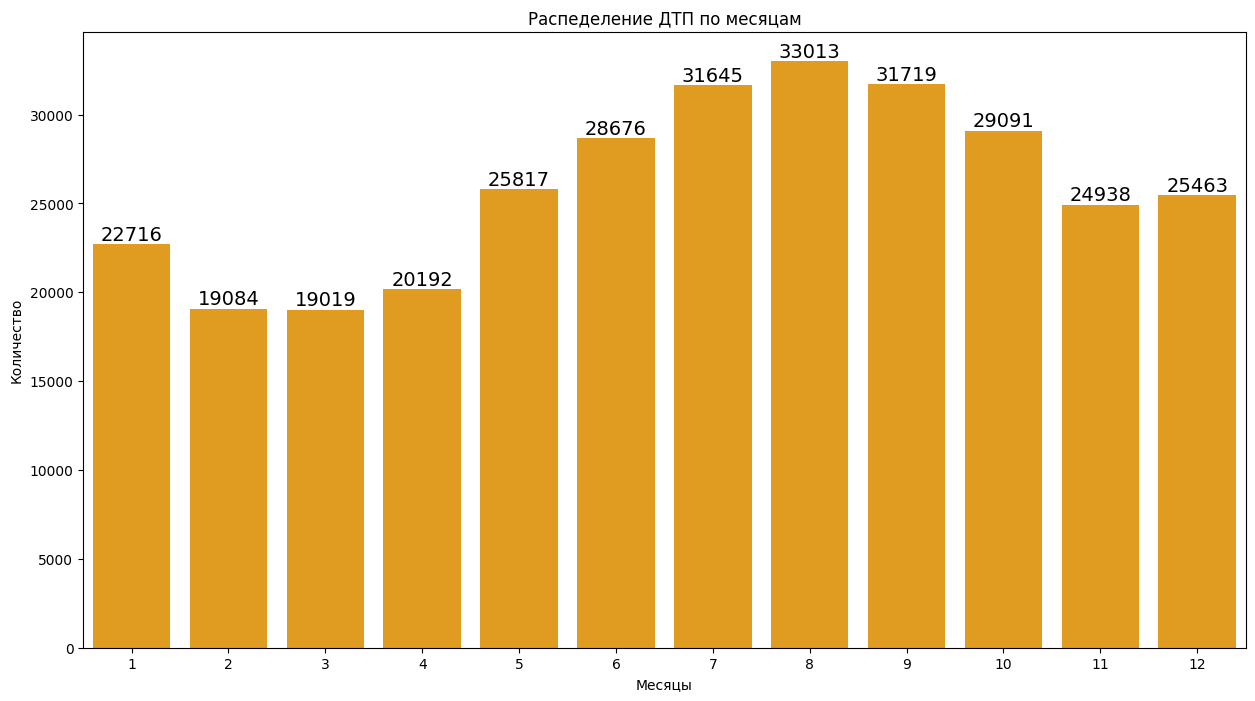

In [ ]:
plt.figure(figsize=(15,8))
dd = data.groupby('month', as_index=False)['dtp_id'].count().sort_values(by='month', ascending=False)
ax = sns.barplot(x=dd['month'], y=dd['dtp_id'], color='orange')
ax.bar_label(ax.containers[0], fontsize=14,label_type='edge', color='black')
plt.title('Распеделение ДТП по месяцам')
plt.ylabel('Количество')
plt.xlabel('Месяцы')
plt.show()

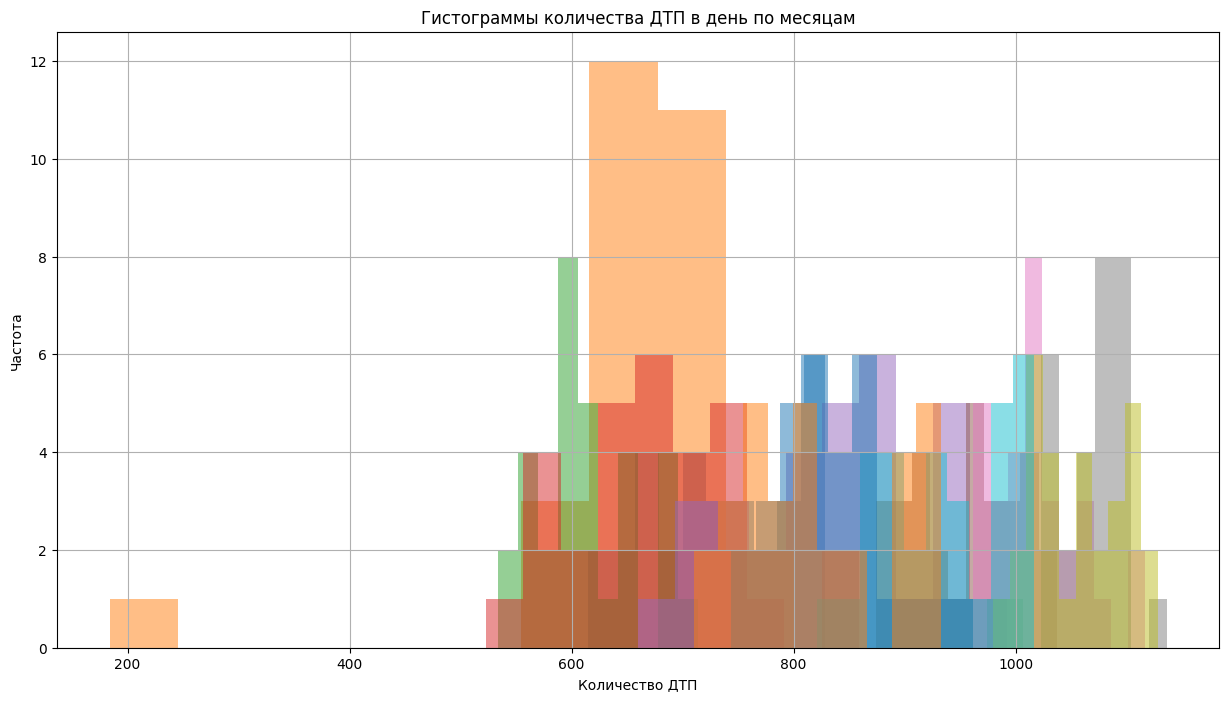

In [ ]:
plt.figure(figsize=(15,8))
for i in range(0, 12):
  dtp_by_month[i].hist(alpha = 0.5)
plt.title('Гистограммы количества ДТП в день по месяцам')
plt.ylabel('Частота')
plt.xlabel('Количество ДТП')
plt.show()

In [ ]:
month_dtp_norm = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    pval = stats.normaltest(dtp_by_month[wd])[1]
    month_dtp_norm.loc['norm', wd+1] = pval
month_dtp_norm.style.apply(highlight_stat, color='tomato')

In [ ]:
month_dtp_leneve = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    for wd2 in range(0, 12):
        if wd == wd2: continue
        pval = stats.levene(dtp_by_month[wd], dtp_by_month[wd2])[1]

        month_dtp_leneve.loc[wd, wd2] = pval
month_dtp_leneve.style.apply(highlight_stat, color='tomato')

Таблица по парного сравнения ДТП по месяцам. В ячейках p-value гипозеты, что в номер месяца по вертикали происходит столько же ДТП, сколько в номер месяца по горизонтали, альтернативная гипотеза - что происходит ДТП больше. Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

Для первой строки читается так: в январе происходит больше ДТП, чем в марте.

In [ ]:
month_dtp_prob = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    for wd2 in range(0, 12):
        if wd == wd2: continue
        pval = stats.ttest_ind(dtp_by_month[wd], dtp_by_month[wd2],\
                               alternative = 'greater',\
                               equal_var=False)[1]
        month_dtp_prob.loc[wd, wd2] = pval
month_dtp_prob.style.apply(highlight_stat)

In [ ]:
month_dtp_prob = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for wd in range(0, 12):
    for wd2 in range(0, 12):
        if wd == wd2: continue
        pval = stats.mannwhitneyu(dtp_by_month[wd], dtp_by_month[wd2],\
                                               alternative = 'greater')[1]
        month_dtp_prob.loc[wd, wd2] = pval
month_dtp_prob.style.apply(highlight_stat)

In [ ]:
pval = stats.f_oneway(dtp_by_month[0],
               dtp_by_month[1],
               dtp_by_month[2],
               dtp_by_month[3],
               dtp_by_month[4],
               dtp_by_month[5],
               dtp_by_month[6],
               dtp_by_month[7],
               dtp_by_month[8],
               dtp_by_month[9],
               dtp_by_month[10],
               dtp_by_month[11],
                      )[1]

pval_print(pval, h0='Количество ДТП в день для разных месяцев - однаково', h1='Количество ДТП в день для разных месяцев - отличается')

В результате теста получено p-value 2.568962193567322e-143
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Количество ДТП в день для разных месяцев - отличается 


# **Карта очагов аварийности**

In [ ]:
data['lat_r'] = round(data['lat'], 3)
data['lng_r'] = round(data['lng'], 3)

In [ ]:
#Сегментация

qq = 'region != ""'
#qq = 'region == "Сызранский район" or region == "Шигонский район" or region == "Октябрьск"'
#qq = 'region == "Сызранский район"'

In [ ]:
dtp_points = pd.DataFrame(columns=['lat_r', 'lng_r', 'dtp_id', 'participants_count', 'injured_count', 'dead_count', 'oblast', 'address', 'year'])

oblast = (data['oblast'].unique())
for o in oblast:
  qq = 'oblast == "' + o + '"'
  dtp_points_oblast = data.query(qq).groupby(['lat_r', 'lng_r'], as_index=False)\
    .agg({'dtp_id': 'count', 'participants_count' : 'sum', 'injured_count' : 'sum', 'dead_count' : 'sum', 'oblast': 'first', 'address': 'first', 'year': 'max'})\
    .sort_values(by = 'dtp_id', ascending = False).head(10)
  dtp_points = pd.concat([dtp_points, dtp_points_oblast])

<ipython-input-181-06da90da6046>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dtp_points = pd.concat([dtp_points, dtp_points_oblast])


In [ ]:
dtp_points = dtp_points[dtp_points['lat_r'] != round(dtp_points['lat_r'])]
dtp_points = dtp_points[dtp_points['year'] > 2022]
dtp_points = dtp_points.reset_index(drop=True)

In [ ]:
for i in range(0, len(dtp_points)):
    qsrt = 'lat_r == (' + str(dtp_points.loc[i, 'lat_r']) + ') & (lng_r == ' + str(dtp_points.loc[i, 'lng_r']) + ')'
    dd = data.query(qsrt).groupby('year', as_index = False ).agg({'dtp_id' : 'count'})

    kline = k_linear(dd[['year']], dd['dtp_id'])

    dtp_points.loc[i, 'k_line'] = round(kline, 3)

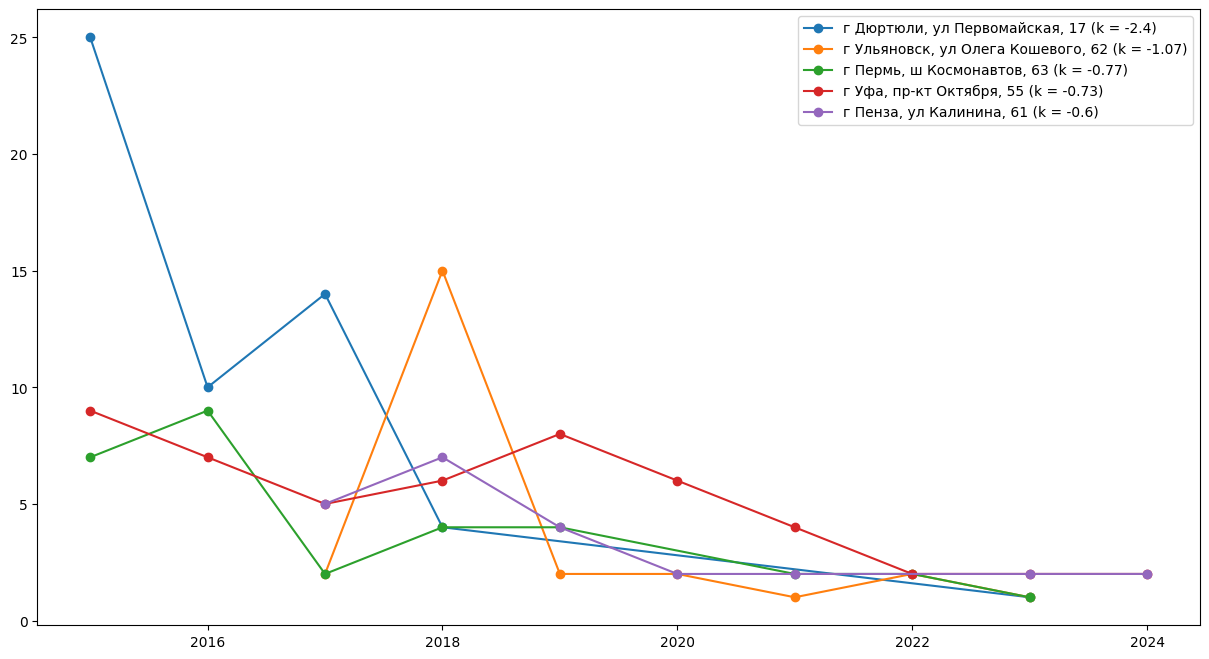

In [ ]:
plt.figure(figsize=(15,8))
positive_point = dtp_points.query('(k_line < -0.2)').sort_values(by='k_line').head(5)
positive_point = positive_point.reset_index(drop=True)
for i in range(0, len(positive_point)):
    lg = positive_point.loc[i, 'address'] + ' (k = ' + str(round(positive_point.loc[i, 'k_line'], 2)) + ')'
    qsrt = 'lat_r == (' + str(positive_point.loc[i, 'lat_r']) + ') & (lng_r == ' + str(positive_point.loc[i, 'lng_r']) + ')'
    dd = data.query(qsrt).groupby('year', as_index = False ).agg({'dtp_id' : 'count'})
    x = dd['year']
    y = dd['dtp_id']
    plt.plot(x, y, linestyle="solid", marker="o", label=lg)
plt.legend()
plt.show()

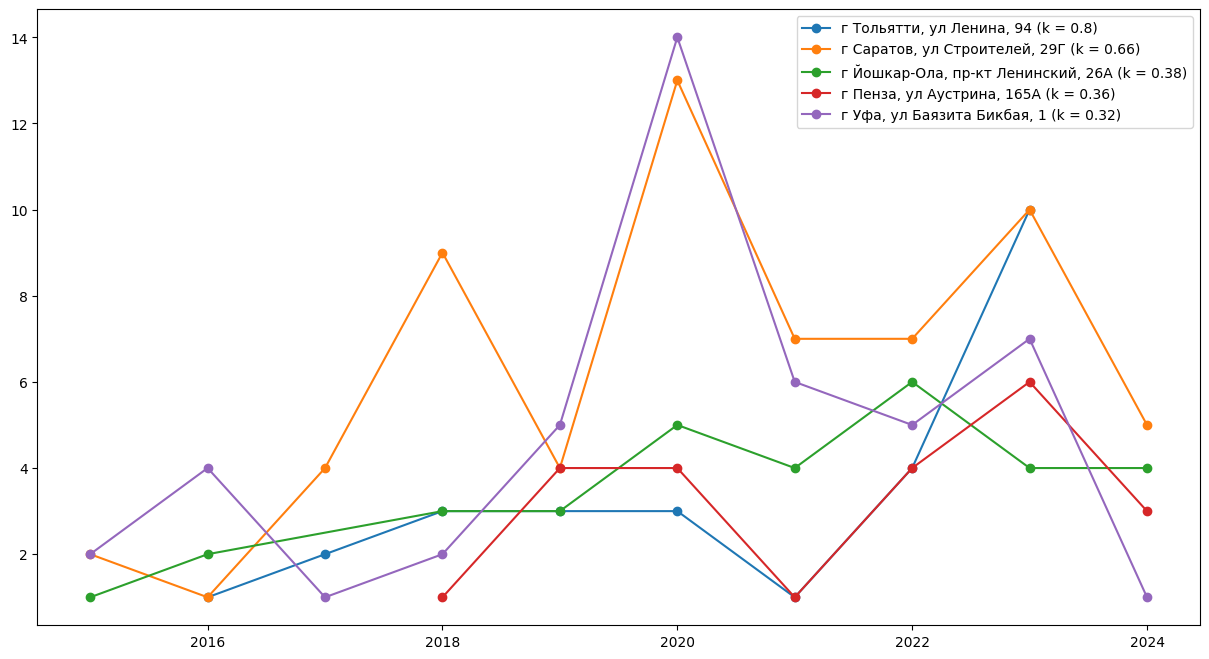

In [ ]:
plt.figure(figsize=(15,8))
positive_point = dtp_points.query('(k_line > 0.2) & (lat_r != 53)').sort_values(by='k_line', ascending=False).head(5)
positive_point = positive_point.reset_index(drop=True)
for i in range(0, len(positive_point)):
    lg = positive_point.loc[i, 'address'] + ' (k = ' + str(round(positive_point.loc[i, 'k_line'], 2)) + ')'
    qsrt = 'lat_r == (' + str(positive_point.loc[i, 'lat_r']) + ') & (lng_r == ' + str(positive_point.loc[i, 'lng_r']) + ')'
    dd = data.query(qsrt).groupby('year', as_index = False ).agg({'dtp_id' : 'count'})
    x = dd[['year']]
    y = dd['dtp_id']
    plt.plot(x, y, linestyle="solid", marker="o", label=lg)
plt.legend()
plt.show()

In [ ]:
map = folium.Map(location=[dtp_points['lat_r'].median(), dtp_points['lng_r'].median()], zoom_start=8, tiles='Cartodb Positron')


for i in range(0, len(dtp_points)):
    text = f"{dtp_points.loc[i,'address']} \n Количество ДТП {dtp_points.loc[i,'dtp_id']} \n Погибло {dtp_points.loc[i,'dead_count']} \n Ранено {dtp_points.loc[i,'injured_count']} \n Тенденция {dtp_points.loc[i,'k_line']}"
    cl = 'blue'
    if dtp_points.loc[i,'k_line'] < -0.2: cl = 'green'
    if dtp_points.loc[i,'k_line'] > 0.2: cl = 'red'

    folium.Marker(location=[dtp_points.loc[i,'lat_r'], dtp_points.loc[i,'lng_r']],
            popup=folium.Popup(text, max_width=500, min_width=300),
            icon=folium.Icon(color=cl, icon=''),
            ).add_to(map)

map

In [ ]:
map = folium.Map(location=[dtp_points['lat_r'].median(), dtp_points['lng_r'].median()], zoom_start=7, tiles='Cartodb Positron')

marker_cluster = MarkerCluster().add_to(map)

def create_clusters(row):
    folium.Marker(
        [row['lat_r'], row['lng_r']],
        popup=f"{row['lat_r']} {row['lng_r']} \n\r Количество ДТП {row['dtp_id']}",
    ).add_to(marker_cluster)

dtp_points.apply(create_clusters, axis=1)

map

# **ЭКСперименты**

In [ ]:
partic[(partic['health_status'].str.contains('Скончался', case=False, flags=0, na=False, regex=False)) & (partic['role'] == 'Водитель') & (partic['violations'] == 'Не заполнено')]

partic_id    car_id      dtp_id      role   gender    violations  \
318       1_319     1_189   1_2257201  Водитель  Женский  Не заполнено   
349       1_350     1_208   1_2258363  Водитель  Мужской  Не заполнено   
430       1_431     1_262   1_2709023  Водитель  Мужской  Не заполнено   
629       1_630     1_382   1_2851021  Водитель  Женский  Не заполнено   
664       1_665     1_404   1_2264854  Водитель  Мужской  Не заполнено   
...         ...       ...         ...       ...      ...           ...   
61530  13_61531  13_38087  13_1682754  Водитель  Мужской  Не заполнено   
62650  13_62651  13_38766  13_1668558  Водитель  Мужской  Не заполнено   
62686  13_62687  13_38787  13_1666174  Водитель  Мужской  Не заполнено   
63647  13_63648  13_39415  13_1678976  Водитель  Мужской  Не заполнено   
66236  13_66237  13_41048  13_1681768  Водитель  Мужской  Не заполнено   

                                                     health_status  \
318                                    Скончался в течение 2 суток   
349    Скончался на месте ДТП до приезда скорой медицинской помощи   
430    Скончался на месте ДТП до приезда скорой медицинской помощи   
629    Скончался на месте ДТП до приезда скорой медицинской помощи   
664    Скончался на месте ДТП до приезда скорой медицинской помощи   
...                                                            ...   
61530                                  Скончался в течение 1 суток   
62650  Скончался на месте ДТП до приезда скорой медицинской помощи   
62686                                  Скончался в течение 8 суток   
63647  Скончался на месте ДТП до приезда скорой медицинской помощи   
66236                                  Скончался в течение 1 суток   

       years_of_driving_experience result  
318                              3  Погиб  
349                             48  Погиб  
430                             23  Погиб  
629                              3  Погиб  
664                              5  Погиб  
...                            ...    ...  
61530                           19  Погиб  
62650                            8  Погиб  
62686                           36  Погиб  
63647                           26  Погиб  
66236                           25  Погиб  

[1886 rows x 9 columns]

In [ ]:
partic[(partic['health_status'].str.contains('Скончался', case=False, flags=0, na=False, regex=False)) & (partic['role'] == 'Велосипедист')]

partic_id    car_id      dtp_id          role        gender  \
625       1_626     1_378   1_3001942  Велосипедист       Женский   
883       1_884     1_535   1_2616038  Велосипедист       Мужской   
3641     1_3642    1_2304   1_2259743  Велосипедист  Не заполнено   
5170     1_5171    1_3302   1_2258880  Велосипедист       Мужской   
7125     1_7126    1_4577   1_2269202  Велосипедист       Мужской   
...         ...       ...         ...           ...           ...   
45072  13_45073  13_27850  13_1665505  Велосипедист       Мужской   
50537  13_50538  13_31260  13_1677494  Велосипедист       Мужской   
57920  13_57921  13_35868  13_1680596  Велосипедист       Мужской   
58871  13_58872  13_36442  13_1671803  Велосипедист       Мужской   
66407  13_66408  13_41163  13_1682727  Велосипедист       Мужской   

                                                                                                                      violations  \
625                                                                                                                 Не заполнено   
883                                                                                                                 Не заполнено   
3641   Несоблюдение очередности проезда; Управление при движении по автодороге велосипедом, гужевой повозкой лицом моложе 14 лет   
5170                                                                                                              Иные нарушения   
7125                                                                                            Несоблюдение очередности проезда   
...                                                                                                                          ...   
45072                                                                                              Нарушение правил перестроения   
50537                                                                                                               Не заполнено   
57920                                                                           Управление ТС в состоянии алкогольного опьянения   
58871                                                                                                               Не заполнено   
66407                                                          Пересечение велосипедистом проезжей части по пешеходному переходу   

                                                     health_status  \
625    Скончался на месте ДТП до приезда скорой медицинской помощи   
883    Скончался на месте ДТП до приезда скорой медицинской помощи   
3641                                   Скончался в течение 1 суток   
5170   Скончался на месте ДТП до приезда скорой медицинской помощи   
7125                                   Скончался в течение 1 суток   
...                                                            ...   
45072                                  Скончался в течение 5 суток   
50537  Скончался на месте ДТП до приезда скорой медицинской помощи   
57920  Скончался на месте ДТП до приезда скорой медицинской помощи   
58871  Скончался на месте ДТП до приезда скорой медицинской помощи   
66407                                  Скончался в течение 8 суток   

       years_of_driving_experience result  
625                              0  Погиб  
883                              0  Погиб  
3641                             0  Погиб  
5170                             0  Погиб  
7125                             0  Погиб  
...                            ...    ...  
45072                            0  Погиб  
50537                            0  Погиб  
57920                            0  Погиб  
58871                            0  Погиб  
66407                            0  Погиб  

[631 rows x 9 columns]

<Axes: xlabel='health_status'>

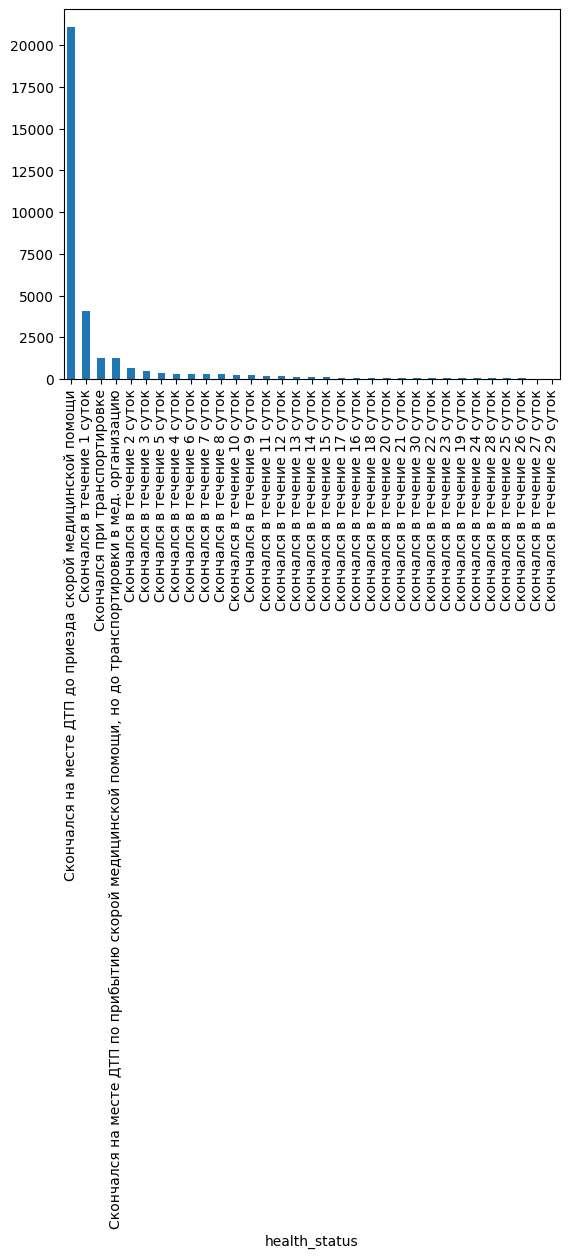

In [ ]:
partic[partic['result'] == 'Погиб']['health_status'].value_counts().plot.bar()

# **Общие выводы**

In [ ]:
print(f"Расчет начат в {start}, закончен в {datetime.datetime.now(tz)}. Затрачено времени {(datetime.datetime.now(tz) - start)}")

Расчет начат в 2024-12-11 13:54:31.010186+04:00, закончен в 2024-12-11 14:12:12.041333+04:00. Затрачено времени 0:17:41.031178
